In [46]:
#!/usr/bin/env python
import git
import sys
import datetime
from pathlib import Path
sys.path.append('/home/bij/Projects/fdtd/')
import math
import time
import fdtd
import fdtd.backend as bd
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.optim as optim
import torchvision
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import scipy
from autoencoder import AutoEncoder
import argparse
from os import listdir
from os.path import isfile, join
import util

parser = argparse.ArgumentParser(description='Process args.')
parser.add_argument('-f', '--load-file', type=str, default=None,
                    help='File to load params from before training starts. Overrides --load-step.')
parser.add_argument('-l', '--load-step', type=str, default='0',
                    help='Where to start training. If latest, will start at the latest checkpoint.')
parser.add_argument('-s', '--save-steps', type=int, default='1000',
                    help='How often to save the model.')
parser.add_argument('-c', '--coverage-ratio', type=float, default=1.0,
                    help='How much distance a wave can cover as a proportion of the diagonal length of the sim.')
parser.add_argument('-m', '--max-steps', type=int, default='1000000000000000',
                    help='How many steps to train.')
parser.add_argument('-d', '--dry-run', type=bool, default=False,
                    help='If true, does not save model checkpoint.')
parser.add_argument('-rog', '--reset-grid-optim', default=False, action='store_true',
                    help='If true, loads completely new params for the grid and optimizer.')
parser.add_argument('-is', '--image-size', type=int, default=40,
                    help='Size of each side of the image. Determines grid size.')
parser.add_argument('-sc', '--image-scaler', type=int, default=1,
                    help='How much to scale the entire simulation by (changes the dimensions of the model).')
parser.add_argument('-oc', '--old-scaler', type=int, default=1,
                    help='If the loaded file was scaled, that scaler value.')
parser.add_argument('-bem', '--bypass-em', default=False, action='store_true',
                    help='If set, will disable the EM component of the model.')
parser.add_argument('-gray', '--grayscale', default=False, action='store_true',
                    help='If set, will force the input and output images to be grayscale.')
parser.add_argument('-thw', '--target-half-way', default=False, action='store_true',
                    help='If set, will only produce loss for the timestep halfway up the coverage ratio.')
parser.add_argument('-sds', '--source-down-scaler', type=int, default=1, 
                    help='How much to stride sources in the cortical substrate.')
parser.add_argument('-sgd', '--use-sgd', default=False, action='store_true',
                    help='If set, will switch to SGD instead of Adam. Useful for finetuning.')
parser.add_argument('-ti', '--target-img', default=None, action='store_true',
                    help='If set, will only process this image file.')
args = parser.parse_args()

args.load_file = 'model_checkpoints/stability-improvements/md_000000037800.pt'
args.grayscale = True
args.image_scaler = 4

def get_sorted_paths(directory_list, target_ext='.png'):
    path_list = []
    for directory in directory_list:
        paths = [join(directory,f) for f in listdir(directory) if isfile(join(directory, f)) and f.endswith(target_ext)]
        print(f'Found {len(paths)} files in {directory}')
        path_list += paths
    path_list.sort()
    return path_list

#img_paths = get_sorted_paths(['./optical_illusions/'])
img_paths = ['./optical_illusions/Cornsweet_illusion.png',
     './optical_illusions/Ehrenstein_Illusion.png',
     './optical_illusions/dots_Brightness-Optical-Illusion.png',
     './optical_illusions/illusory_brigntness.png',
     './optical_illusions/illusory_brigntness_reverse.png',
     './optical_illusions/rectangle_Brightness-Optical-Illusion2.png']

# ## Set Backend
backend_name = "torch"
fdtd.set_backend(backend_name)
if(backend_name.startswith("torch.cuda")):
    device = "cuda"
else:
    device = "cpu"

In [47]:
img_paths

['./optical_illusions/Cornsweet_illusion.png',
 './optical_illusions/Ehrenstein_Illusion.png',
 './optical_illusions/dots_Brightness-Optical-Illusion.png',
 './optical_illusions/illusory_brigntness.png',
 './optical_illusions/illusory_brigntness_reverse.png',
 './optical_illusions/rectangle_Brightness-Optical-Illusion2.png']

In [9]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((args.image_size*args.image_scaler, args.image_size*args.image_scaler))])

img_file = img_paths[0]
print(img_file.split('/')[-1].split('.')[0])
img = Image.open(img_file)
img = image_transform(img)[None, ...]
if(args.grayscale):
    img = torchvision.transforms.Grayscale()(img)[None, 0, ...]
else:
    img = torchvision.transforms.Grayscale()(img)
print('Image shape: ', img.shape)
ih, iw = tuple(img.shape[2:4])
print('ih, iw: ', ih, iw)

# Physics constants
WAVELENGTH = 1550e-9 # meters
SPEED_LIGHT: float = 299_792_458.0  # [m/s] speed of light
GRID_SPACING = 0.1 * WAVELENGTH # meters



# Size of grid boundary layer
bw = 10*args.image_scaler
# Create FDTD Grid
grid_h, grid_w = (ih+bw*2, iw+bw*2)
print('Grid height and width: ', grid_h, grid_w)
# Boundaries with width bw
grid = fdtd.Grid(
    (grid_h, grid_w, 1),
    grid_spacing=GRID_SPACING,
    permittivity=1.0,
    permeability=1.0,
)

# Calculate how long it takes a wave to cross the entire grid.
grid_diag_cells = math.sqrt(grid_h**2 + grid_w**2)
grid_diag_len = grid_diag_cells * GRID_SPACING
grid_diag_steps = int(grid_diag_len/SPEED_LIGHT/grid.time_step)+1
print('Time steps to cover entire grid: ', grid_diag_steps)
# The number of steps is based on the coverage ratio.
if(args.target_half_way):
    em_steps = int(grid_diag_steps*args.coverage_ratio/2)
else:
    em_steps = int(grid_diag_steps*args.coverage_ratio)
print('Time steps the grid will run for: ', em_steps)


# Create learnable objects at the boundaries
grid[  0: bw, :, :] = fdtd.LearnableAnisotropicObject(permittivity=2.5, name="xlow", device=device)
grid[-bw:   , :, :] = fdtd.LearnableAnisotropicObject(permittivity=2.5, name="xhigh", device=device)
grid[:,   0:bw, :] = fdtd.LearnableAnisotropicObject(permittivity=2.5, name="ylow", device=device)
grid[:, -bw:  , :] = fdtd.LearnableAnisotropicObject(permittivity=2.5, name="yhigh", device=device)
grid[:, :, 0] = fdtd.PeriodicBoundary(name="zbounds")

# Creat the cortical column sources
grid[bw:bw+ih,bw:bw+iw,0] = fdtd.CorticalColumnPlaneSource(
    period = WAVELENGTH / SPEED_LIGHT,
    polarization = 'x', # BS value, polarization is not used.
    name = 'cc',
    source_stride = args.source_down_scaler,
)

# Object defining the cortical column substrate 
grid[bw:-bw, bw:-bw, :] = fdtd.LearnableAnisotropicObject(permittivity=2.5, is_substrate=True, name="cc_substrate", device=device)

torch.autograd.set_detect_anomaly(True)
# The weights for the reconstruction loss at each em time step. 
loss_step_weights = torch.ones(em_steps, device=device)/em_steps
#loss_step_weights = torch.nn.Parameter(torch.reshape(loss_step_weights, (-1, 1, 1, 1, 1)))
loss_step_weights.requires_grad = True
softmax = torch.nn.Softmax(dim=0)

# Initialize the model and grid with default params.
if(args.grayscale):
    chans = 1
else:
    chans = 3
model = AutoEncoder(num_em_steps=em_steps, grid=grid, input_chans=chans, output_chans=chans, source_stride=args.source_down_scaler, bypass_em=args.bypass_em).to(device)
print('All grid objects: ', [obj.name for obj in grid.objects])
grid_params_to_learn = []
grid_params_to_learn += [util.get_object_by_name(grid, 'xlow').inverse_permittivity]
grid_params_to_learn += [util.get_object_by_name(grid, 'xhigh').inverse_permittivity]
grid_params_to_learn += [util.get_object_by_name(grid, 'ylow').inverse_permittivity]
grid_params_to_learn += [util.get_object_by_name(grid, 'yhigh').inverse_permittivity]
grid_params_to_learn += [util.get_object_by_name(grid, 'cc_substrate').inverse_permittivity]
# Nonlinearity weights for the substrate. 
grid_params_to_learn += [util.get_object_by_name(grid, 'cc_substrate').nonlin_conv.weight]
grid_params_to_learn += [util.get_object_by_name(grid, 'cc_substrate').nonlin_conv.bias]
# Nonlinearity weights for the cortical columns. 
grid_params_to_learn += [util.get_source_by_name(grid, 'cc').nonlin_conv.weight]
grid_params_to_learn += [util.get_source_by_name(grid, 'cc').nonlin_conv.bias]
# The weights for the loss.
grid_params_to_learn += [loss_step_weights]

# Load saved params for model and optimizer.
#checkpoint_steps = [int(cf.split('_')[-1].split('.')[0]) for cf in checkpoints]
if(args.load_file is not None):
    start_step = int(args.load_file.split('/')[-1].split('_')[-1].split('.')[0])
    print('Loading model {0}. Starting at step {1}.'.format(args.load_file, start_step))
    optimizer_path = args.load_file.rsplit('.', 1)[0] + '.opt'
    grid_path = args.load_file.rsplit('.', 1)[0] + '.grd'
    model.load_state_dict(torch.load(args.load_file))
else:
    if(args.load_step == 'latest'):
        if(len(checkpoint_steps) > 0):
            latest_idx = np.argmax(checkpoint_steps)
            start_step = checkpoint_steps[latest_idx]
            model_dict_path = model_checkpoint_dir + checkpoints[latest_idx]
            optimizer_path = model_dict_path.rsplit('.', 1)[0] + '.opt'
            grid_path = model_dict_path.rsplit('.', 1)[0] + '.grd'
            print('Loading model {0} with optimizer {1} and grid {2}.'.format(model_dict_path, optimizer_path, grid_path))
            model.load_state_dict(torch.load(model_dict_path))
        else:
            start_step = 0
    elif(int(args.load_step) != 0):
        if(int(args.load_step) not in checkpoint_steps):
            print('Checkpoint {0} not found in {1}'.format(args.load_step, model_checkpoint_dir))
            sys.exit()
        start_step = int(args.load_step)
        model_idx = np.where(np.array(checkpoint_steps) == start_step)[0][0]
        model_dict_path = model_checkpoint_dir + checkpoints[model_idx]
        optimizer_path = model_dict_path.rsplit('.', 1)[0] + '.opt'
        grid_path = model_dict_path.rsplit('.', 1)[0] + '.grd'
        print('Loading model {0} with optimizer {1} and grid {2}.'.format(model_dict_path, optimizer_path, grid_path))
        model.load_state_dict(torch.load(model_dict_path))
    else:
        print('Starting model at step 0')
        start_step = 0
        optimizer_path = None
        grid_path = None

reset_optimizer = False
if((grid_path is not None) and (not args.reset_grid_optim)):
    print('Loading grid params...')
    with torch.no_grad():
        load_grid_params_to_learn = torch.load(grid_path)
        for idx, tensor in enumerate(load_grid_params_to_learn):
            if(tensor.shape == grid_params_to_learn[idx][...].shape):
                grid_params_to_learn[idx][...] = tensor[...]
            else:
                if(idx == len(load_grid_params_to_learn) - 1):
                    tensor = torch.squeeze(tensor)
                # Interpolate the thing....
                print('INFO: Shapes are mismatched: {0} vs {1}'.format(tensor[...].shape, grid_params_to_learn[idx][...].shape))
                
                # If this is a grid param, expand it over the spatial dims.
                if(len(tensor.shape) > 1):
                    reps = np.ones(len(tensor.shape), dtype=int)
                    for i in range(len(reps)):
                        reps[i] = int(args.image_scaler / args.old_scaler)
                        if(i >= 1):
                            break

                    tensor_np_interp = scipy.ndimage.zoom(tensor.detach().numpy(), reps, order=1)
                    grid_params_to_learn[idx][...] = torch.from_numpy(tensor_np_interp)
                    print('INFO: Grid object scaled to shape: ', grid_params_to_learn[idx][...].shape)
                # If this is the loss step weights, scale it linearly to fit the new size.
                else:
                    tensor_interp = torch.nn.functional.interpolate(tensor[None, None, ...], grid_params_to_learn[idx][...].shape, mode='linear')
                    grid_params_to_learn[idx][...] = tensor_interp
                    print('INFO: EM Step loss object scaled to shape: ', grid_params_to_learn[idx][...].shape)
                    print('EM Steps: ', em_steps)
                    print('Loss step weights: ', loss_step_weights.shape)

                # Since parameter shapes have changed, the optimizer weights are obsolete.
                reset_optimizer = True

# Combine grid and model params and register them with the optimizer.
params_to_learn = [*model.parameters()] + grid_params_to_learn

mse = torch.nn.MSELoss(reduce=False)
loss_fn = torch.nn.MSELoss()

grid.H.requires_grad = True
grid.H.retain_grad()
grid.E.requires_grad = True
grid.E.retain_grad()


Cornsweet_illusion
Image shape:  torch.Size([1, 1, 160, 160])
ih, iw:  160 160
Grid height and width:  240 240
Time steps to cover entire grid:  485
Time steps the grid will run for:  485
All grid objects:  ['xlow', 'xhigh', 'ylow', 'yhigh', 'cc_substrate']
Loading model model_checkpoints/stability-improvements/md_000000037800.pt. Starting at step 37800.
Loading grid params...


/home/bij/anaconda3/envs/Torch/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [42]:
#old_weight = model.conv_linear.weight
#model.conv_linear.weight = torch.nn.Parameter(torch.roll(model.conv_linear.weight, shifts=-1))
#model.conv_linear.weight = torch.nn.Parameter(torch.roll(old_weight, shifts=3))
#model.conv_linear.weight = torch.nn.Parameter(torch.Tensor(np.array([0,0,0,0,1,0]))[None, :, None, None])
#model.conv_linear.weight = old_weight
#model.conv_linear.weight
#old_weight.shape

Parameter containing:
tensor([[[[-1.1324e-02]],

         [[-1.1427e+00]],

         [[ 2.9428e-02]],

         [[ 1.4054e-03]],

         [[-3.2225e-03]],

         [[ 1.0804e-04]]]], requires_grad=True)

Processing:  Cornsweet_illusion
Making grayscale:  torch.Size([1, 3, 160, 160])
torch.Size([1, 1, 160, 160])
Opening image ./optical_illusions/Cornsweet_illusion.png with test strip file ./optical_illusions/test_strips/Cornsweet_illusion_teststrip_part_a.png
Could not find ./optical_illusions/test_strips/Cornsweet_illusion_teststrip_part_b.png, making zeros.
Test strip stats:  tensor(0.0875, dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(1., dtype=torch.float32)
Test strip stats:  tensor(0., dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(0., dtype=torch.float32)
img:  torch.Size([1, 1, 160, 160])
torch.Size([160])


/tmp/ipykernel_31943/1937759225.py:52: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert np.sum(((test_strip_img_a > 0) * (test_strip_img_a < 1)).astype(np.int)) <= 0
/tmp/ipykernel_31943/1937759225.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link f

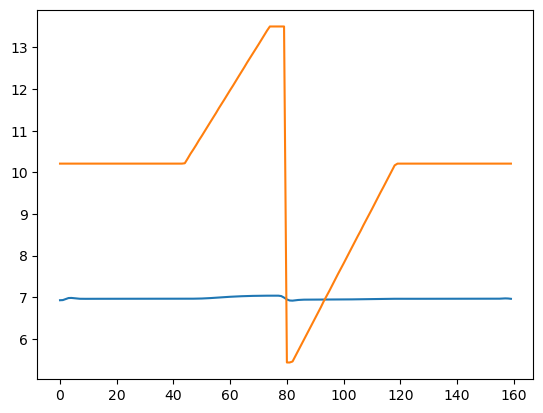

img:  torch.Size([1, 1, 160, 160])85
torch.Size([160])


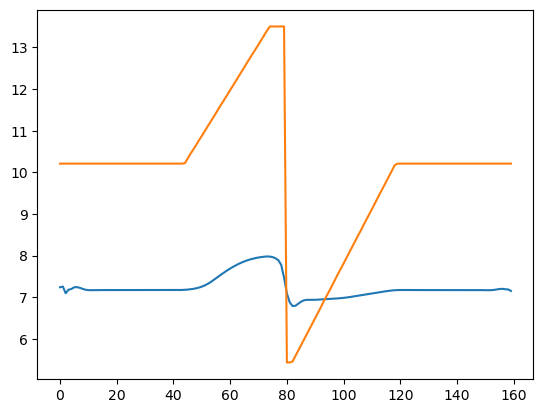

img:  torch.Size([1, 1, 160, 160])85
torch.Size([160])


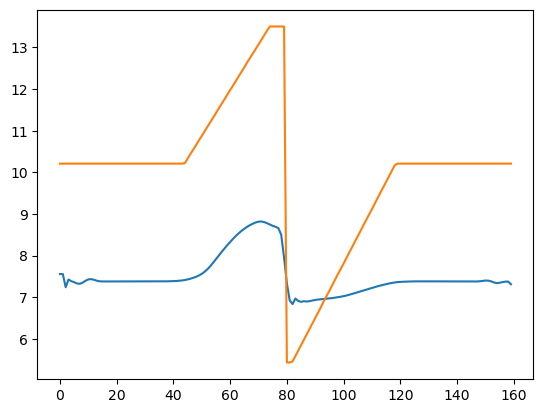

img:  torch.Size([1, 1, 160, 160])85
torch.Size([160])


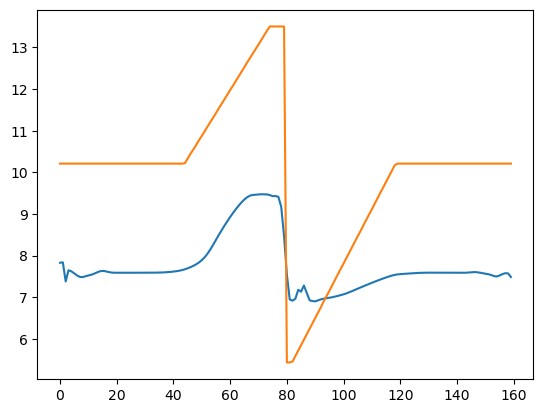

img:  torch.Size([1, 1, 160, 160])85
torch.Size([160])


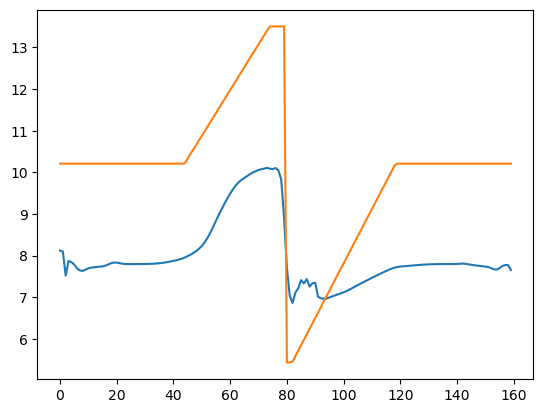

img:  torch.Size([1, 1, 160, 160])85
torch.Size([160])


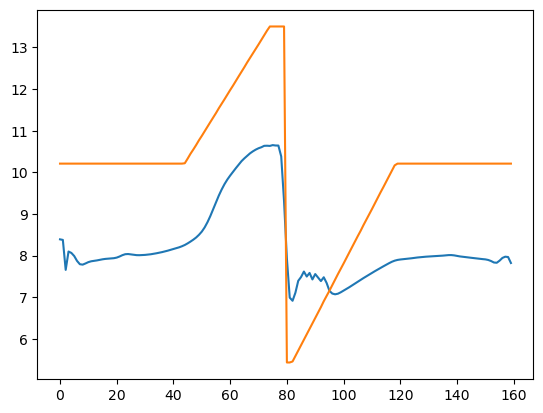

img:  torch.Size([1, 1, 160, 160])85
torch.Size([160])


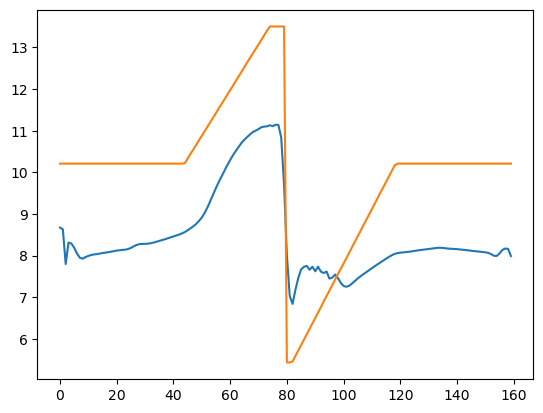

img:  torch.Size([1, 1, 160, 160])85
torch.Size([160])


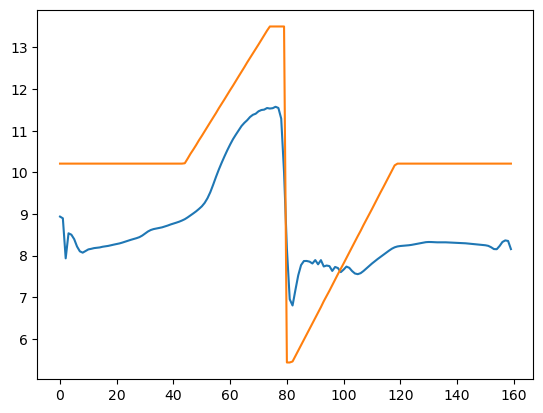

img:  torch.Size([1, 1, 160, 160])85
torch.Size([160])


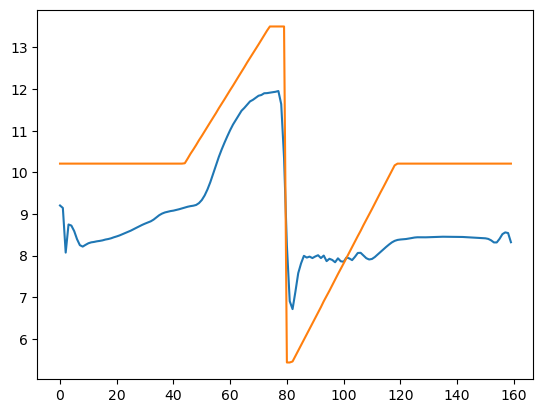

img:  torch.Size([1, 1, 160, 160])85
torch.Size([160])


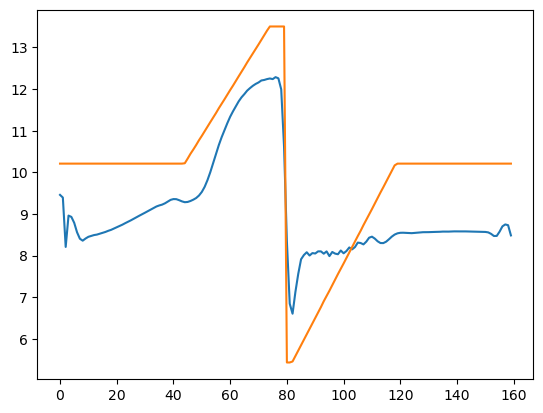

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


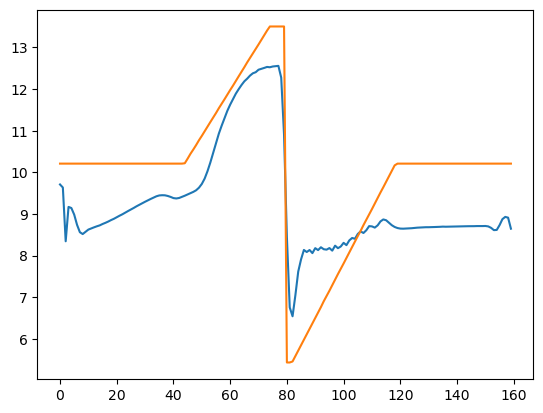

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


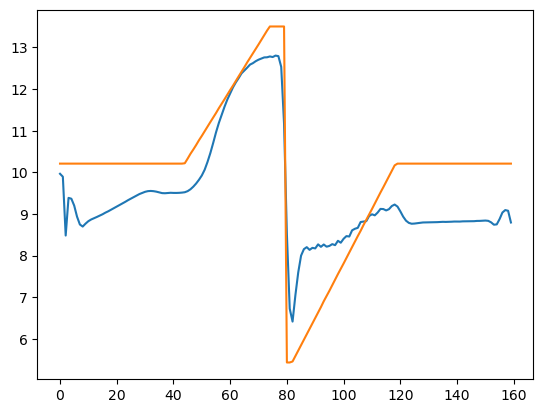

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


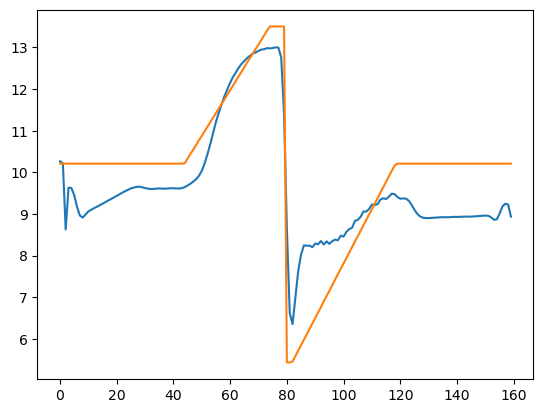

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


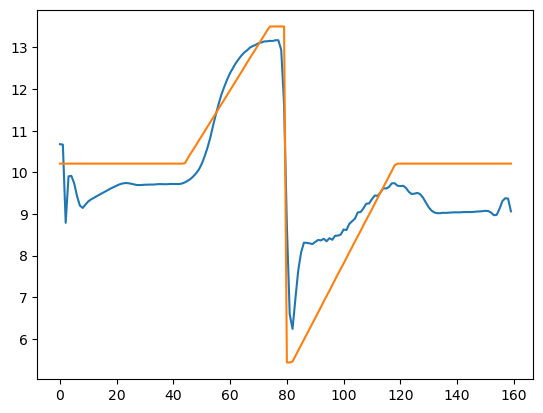

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


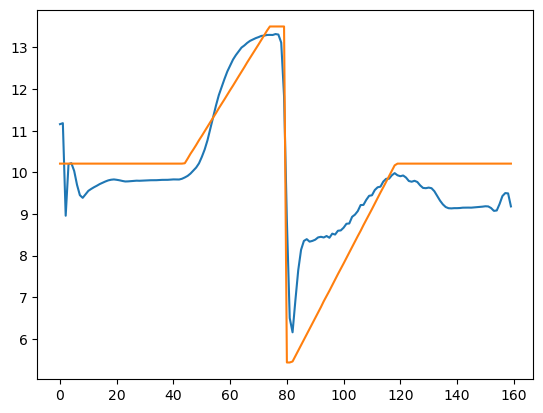

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


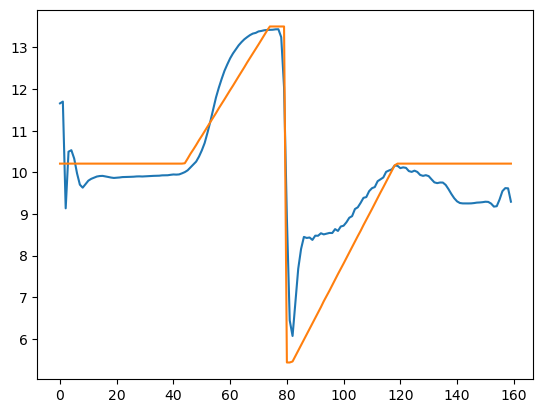

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


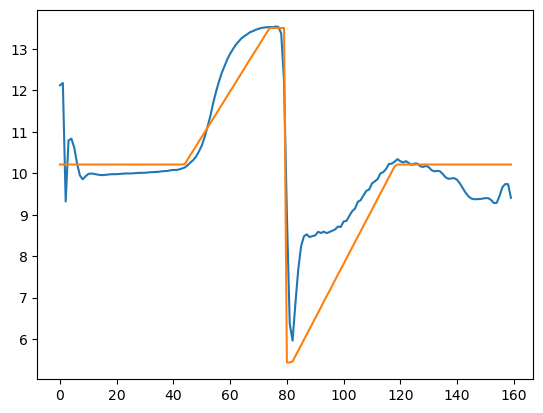

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


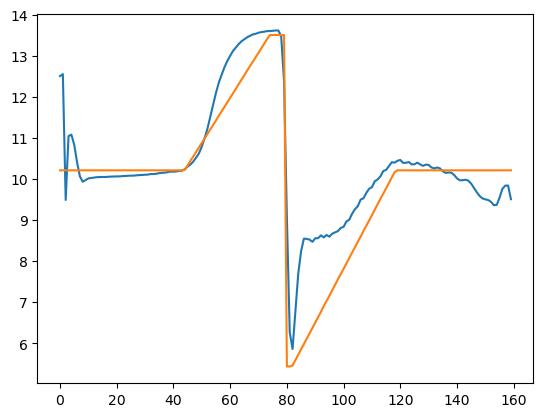

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


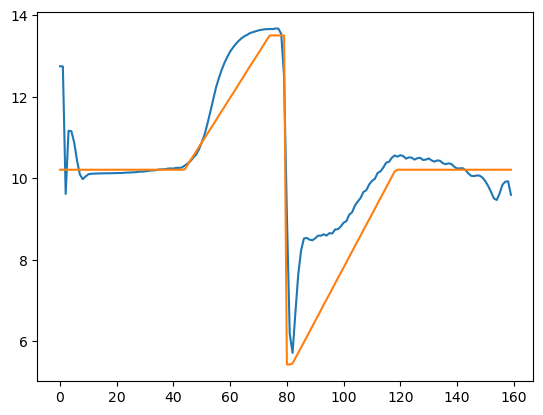

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


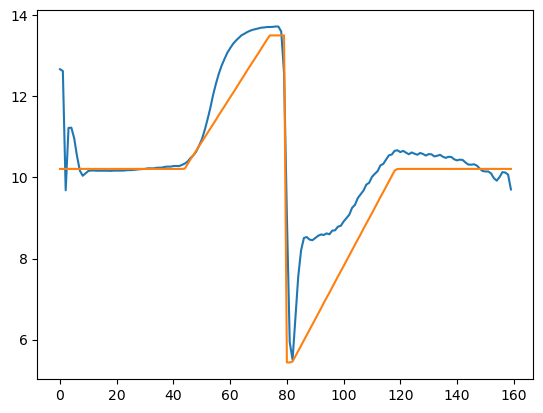

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


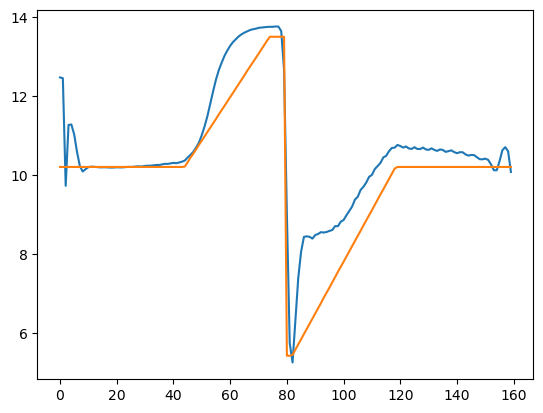

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


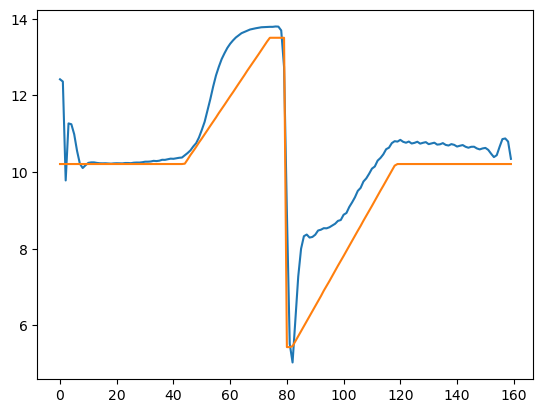

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


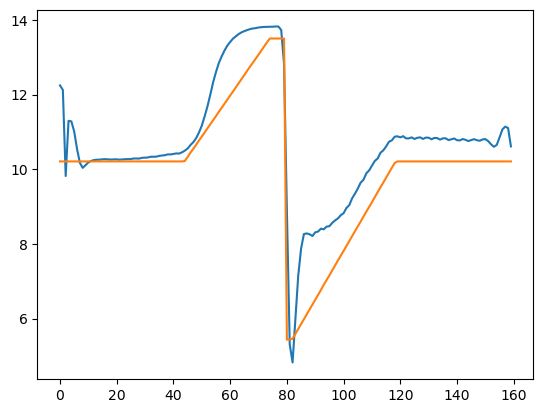

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


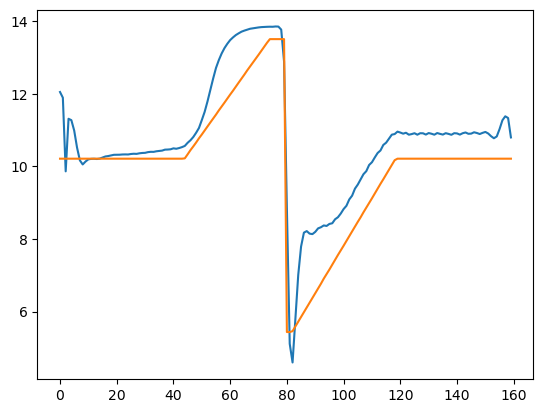

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


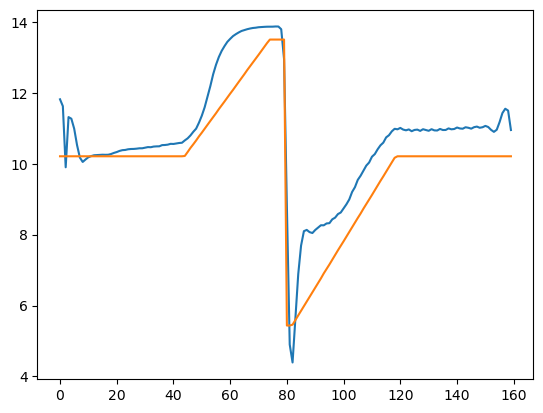

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


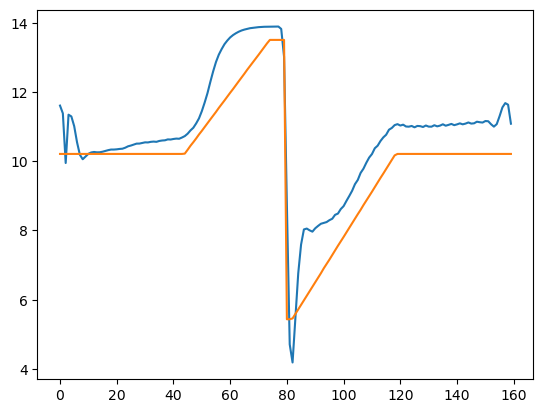

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


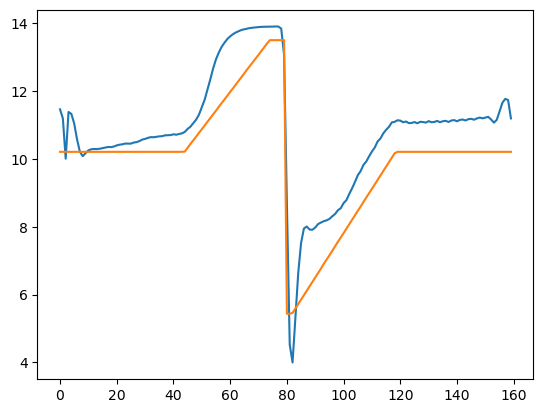

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


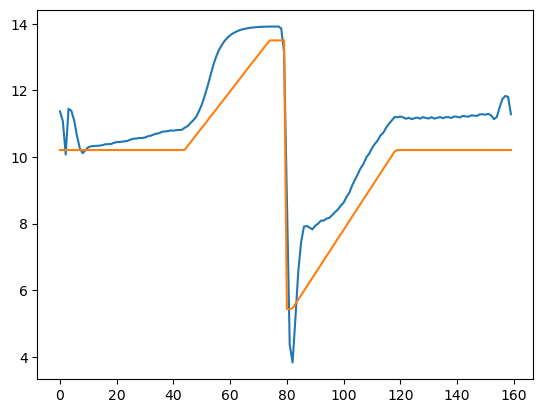

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


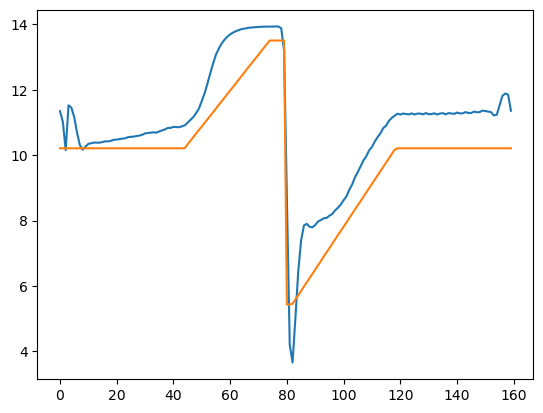

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


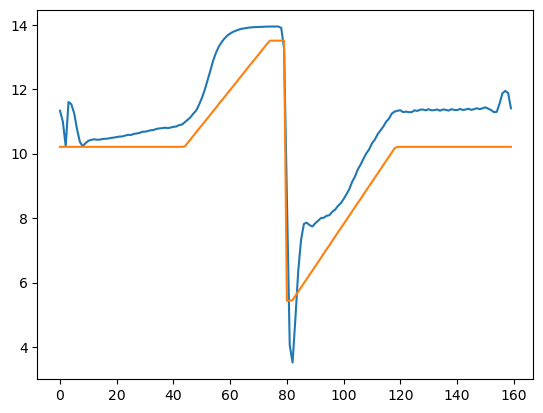

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


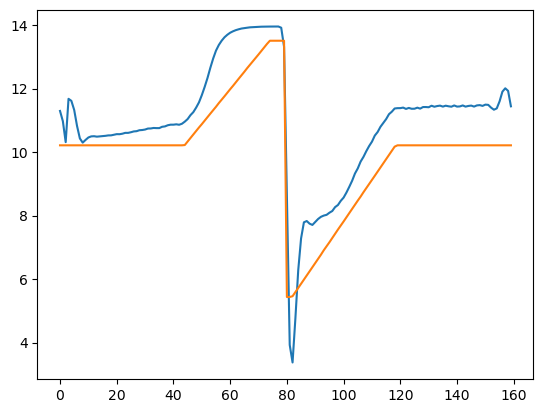

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


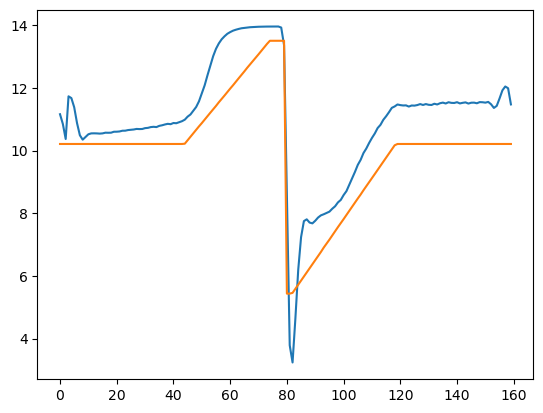

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


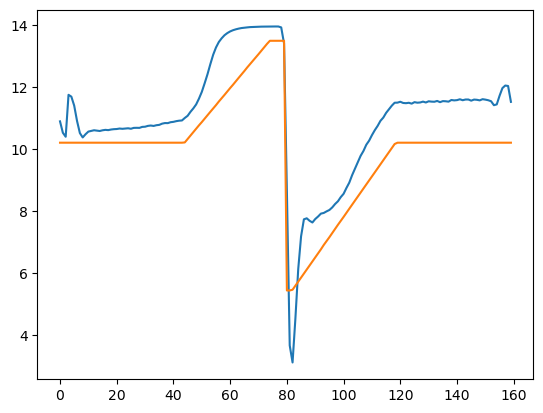

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


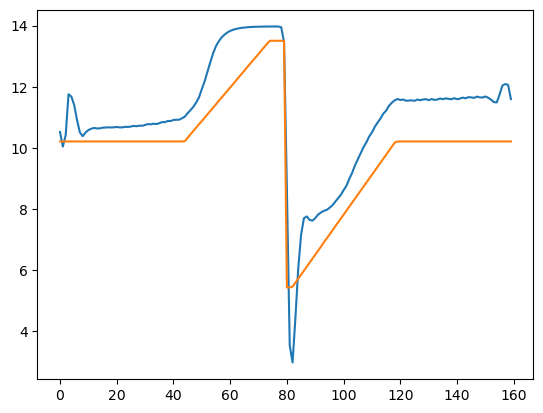

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


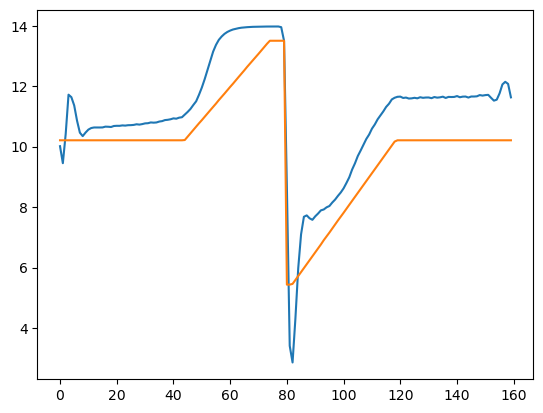

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


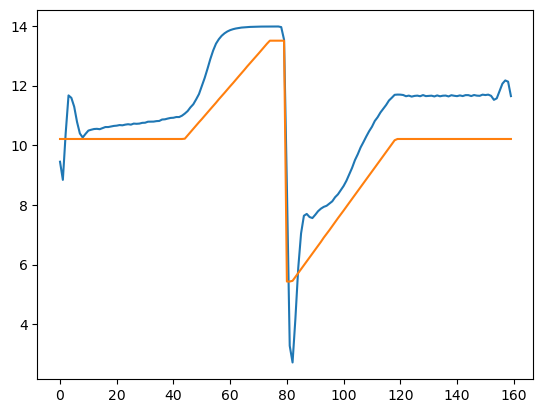

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


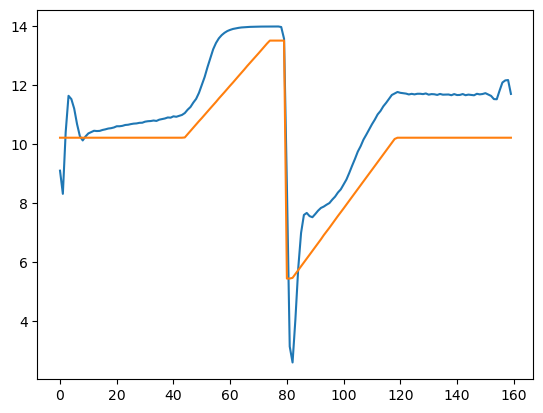

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


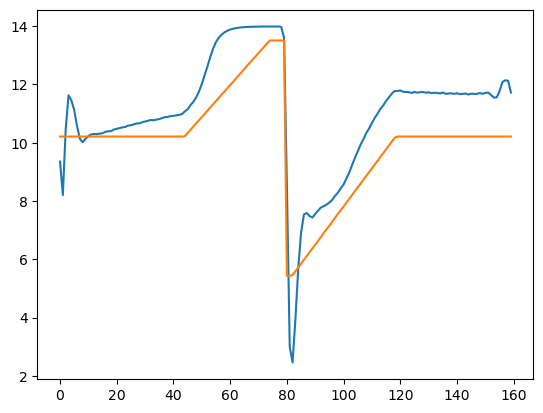

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


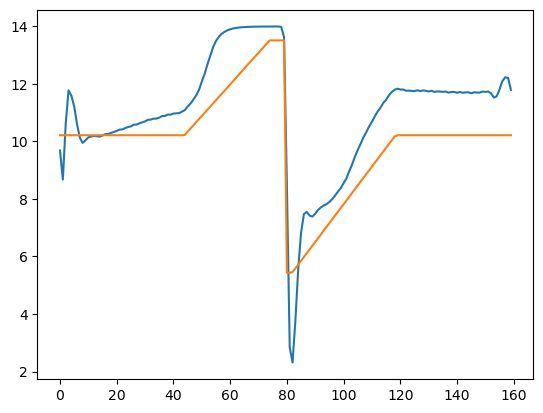

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


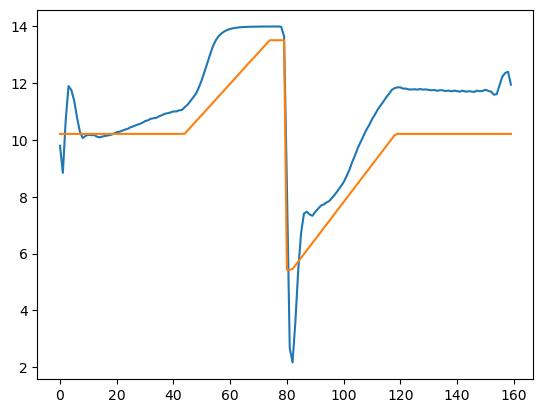

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


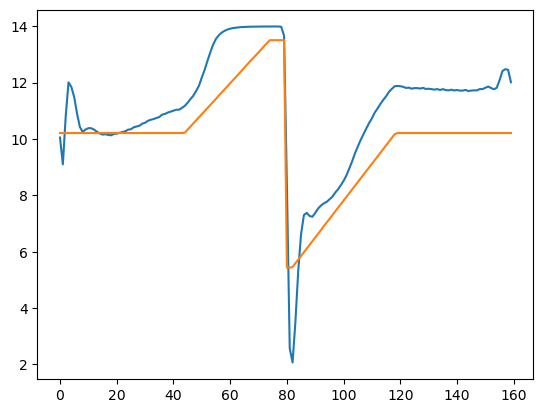

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


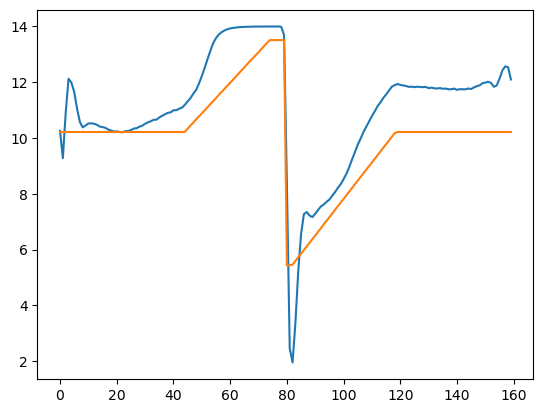

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


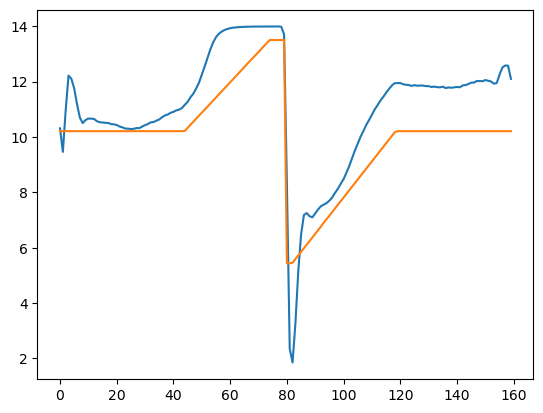

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


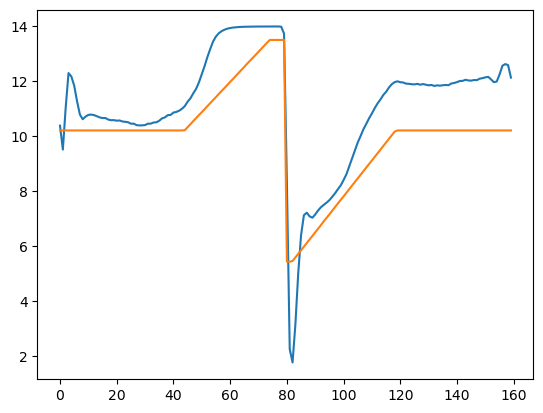

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


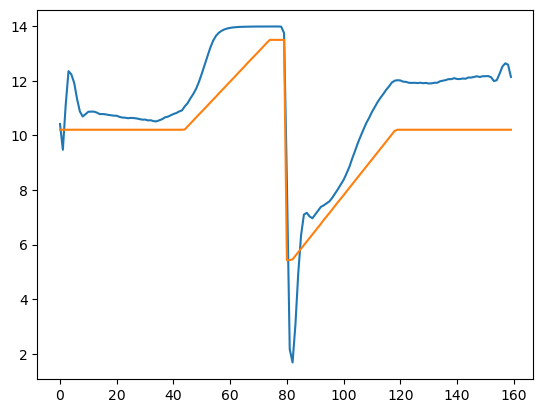

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


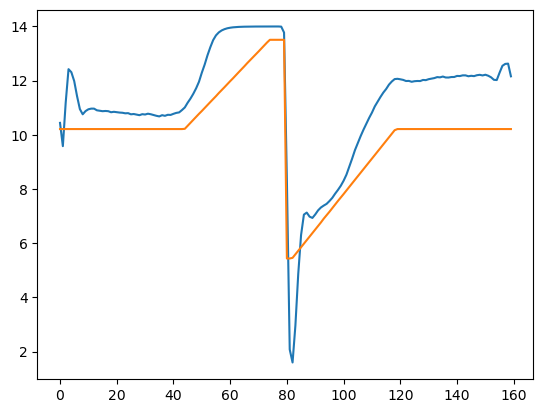

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


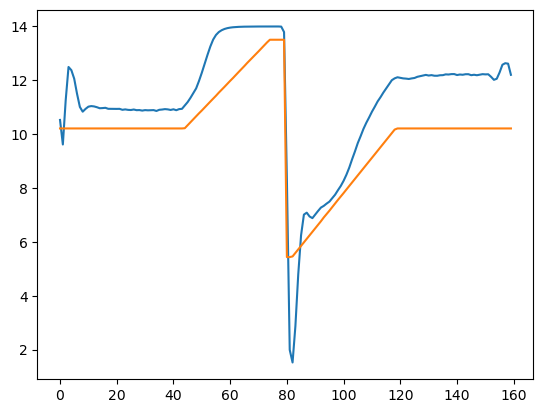

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


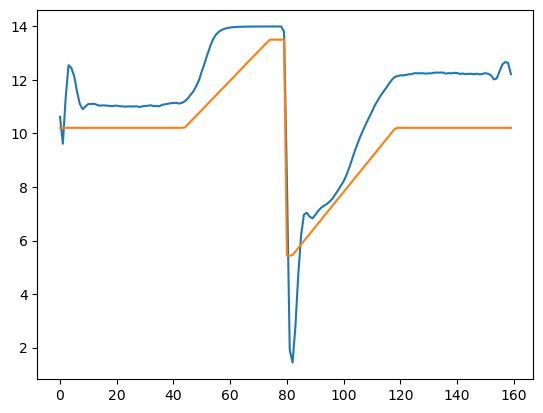

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


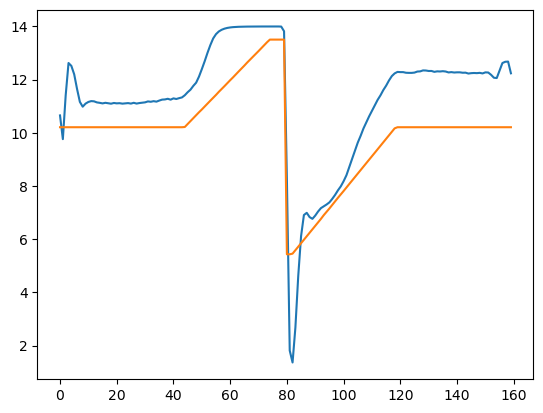

Cornsweet_illusion 	em step:  484 485
Processing:  Ehrenstein_Illusion
Making grayscale:  torch.Size([1, 3, 160, 160])
torch.Size([1, 1, 160, 160])
Opening image ./optical_illusions/Ehrenstein_Illusion.png with test strip file ./optical_illusions/test_strips/Ehrenstein_Illusion_teststrip_part_a.png
Test strip stats:  tensor(0.1570, dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(1., dtype=torch.float32)
Test strip stats:  tensor(0.0697, dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(1., dtype=torch.float32)
img:  torch.Size([1, 1, 160, 160])85
torch.Size([160])


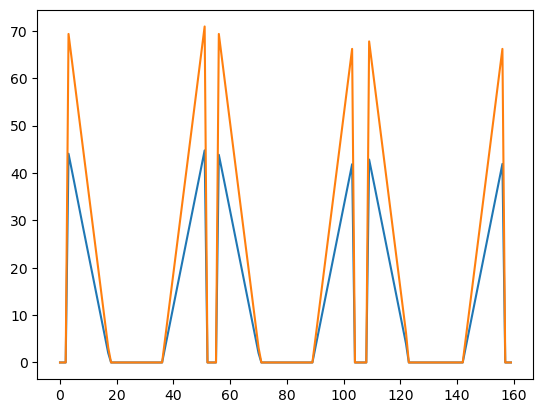

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


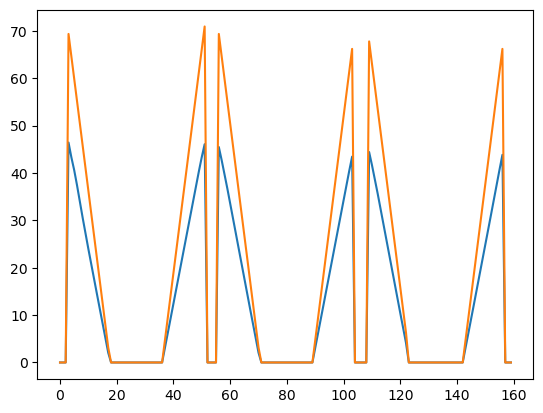

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


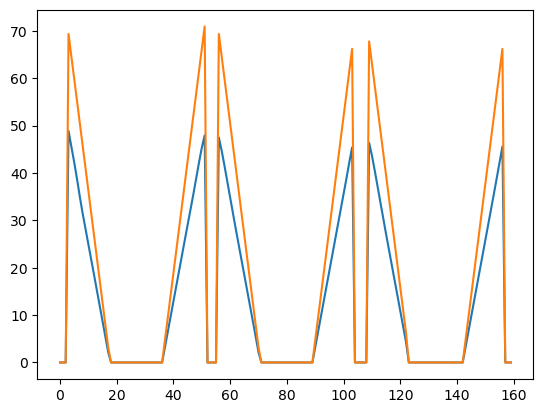

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


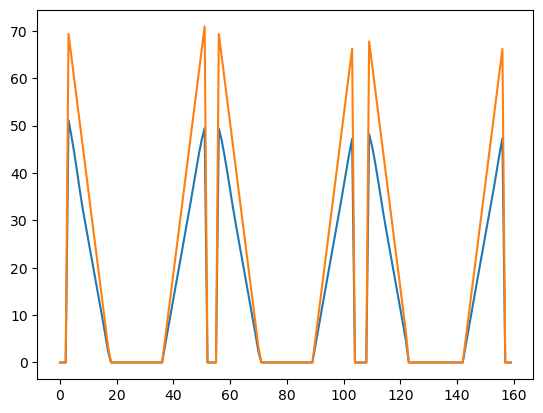

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


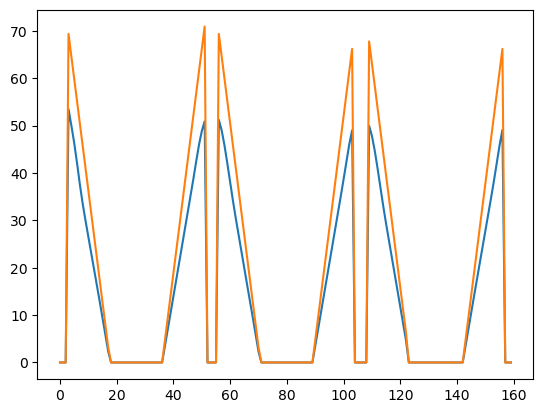

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


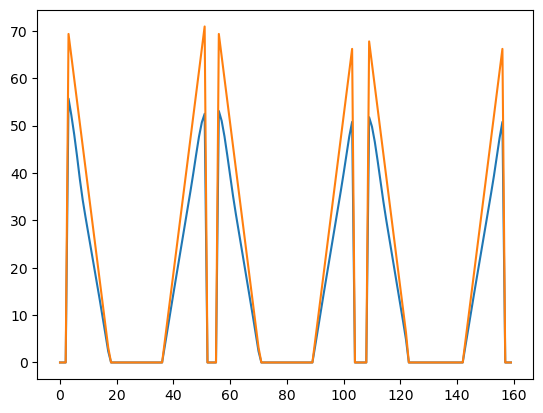

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


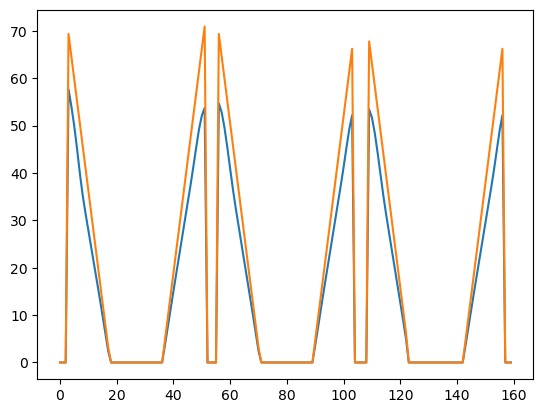

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


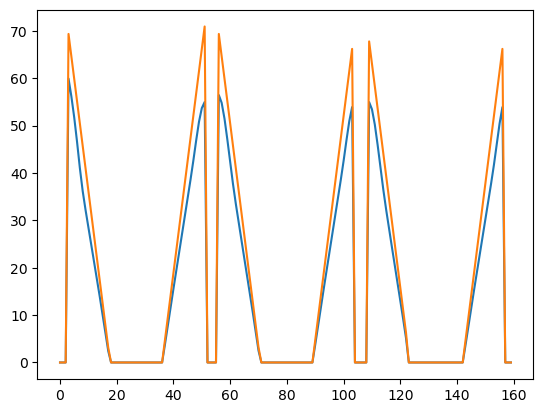

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


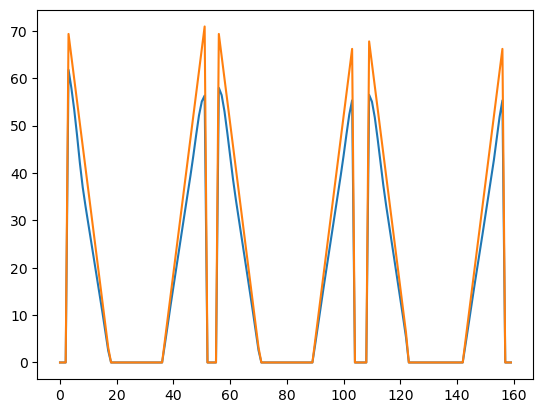

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


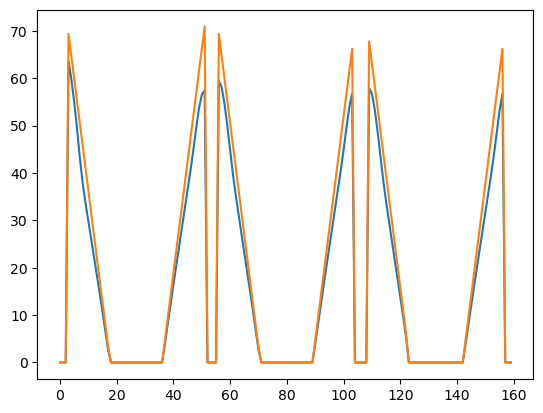

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


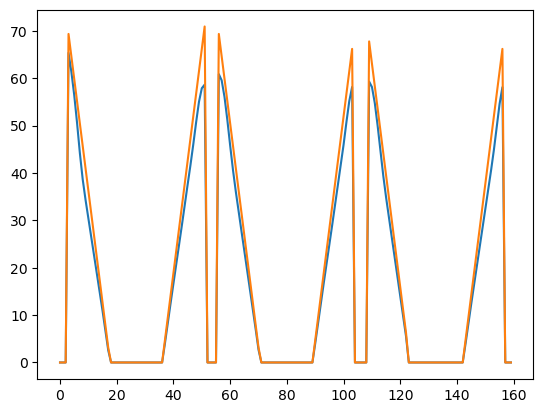

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


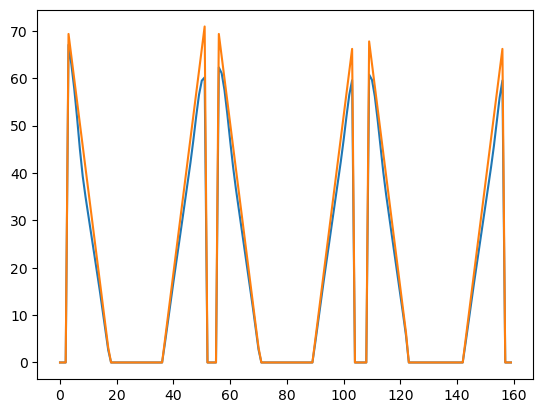

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


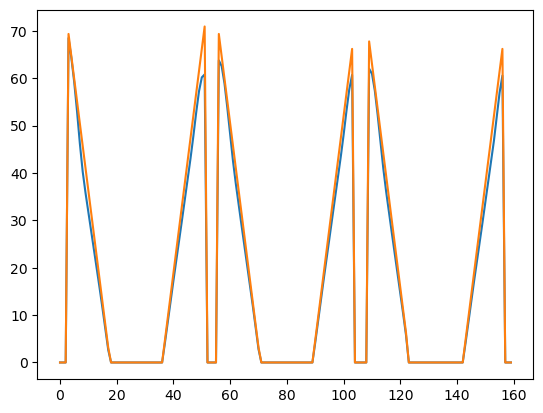

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


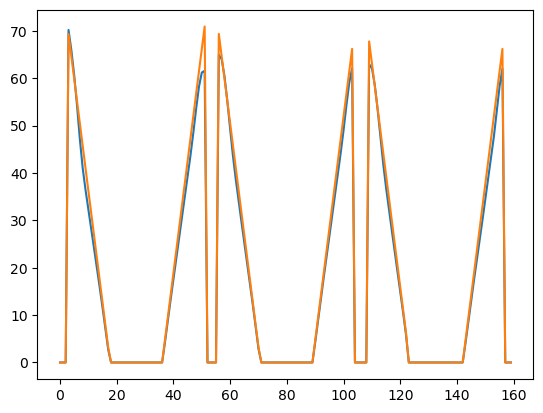

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


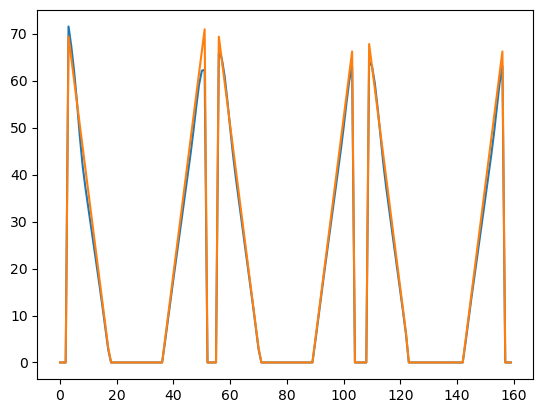

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


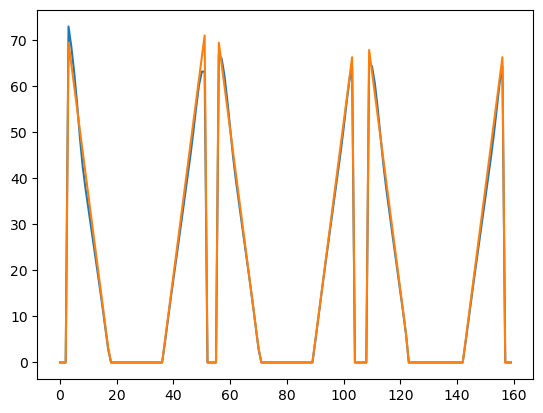

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


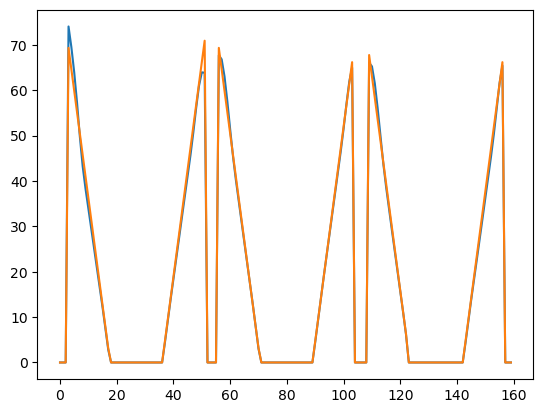

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


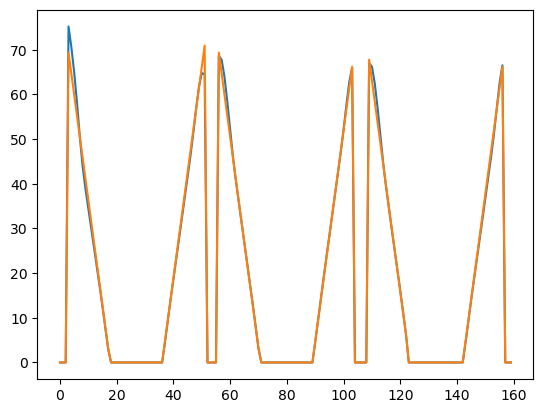

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


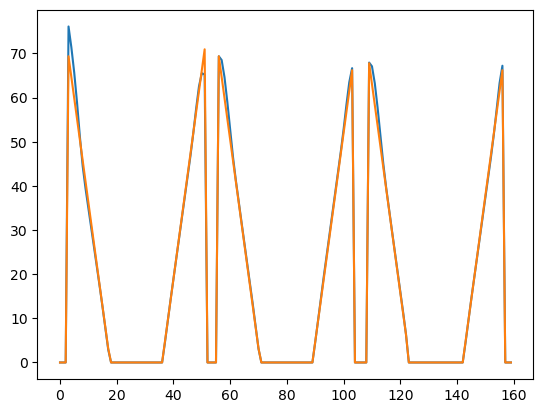

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


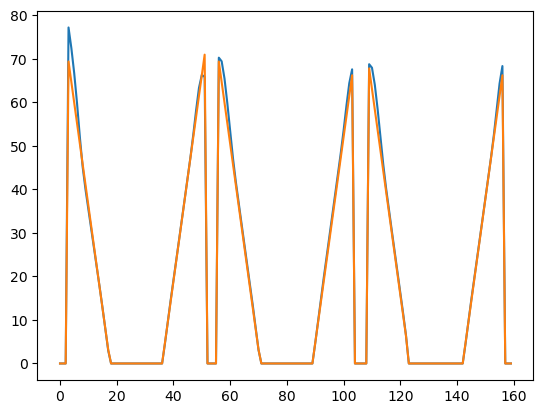

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


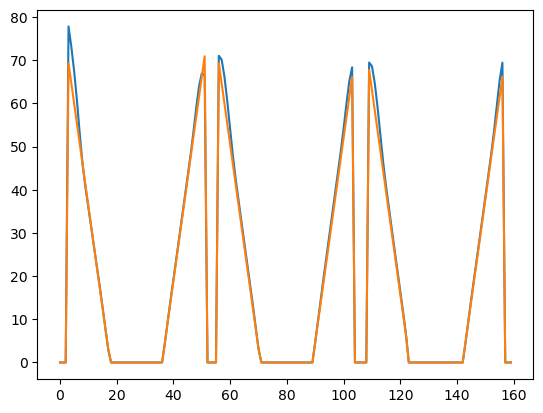

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


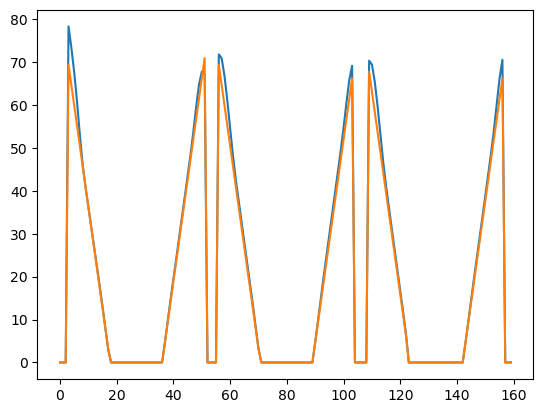

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


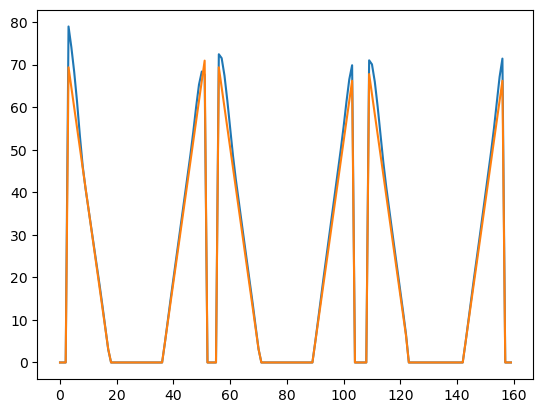

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


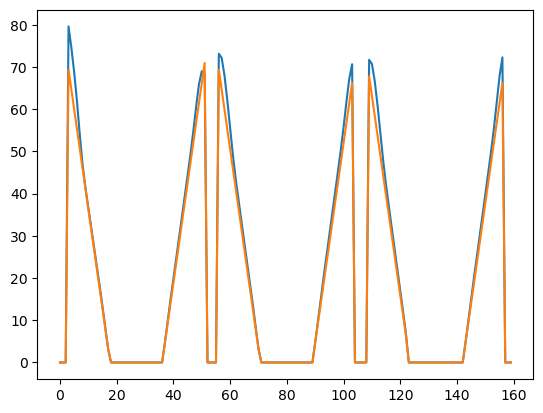

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


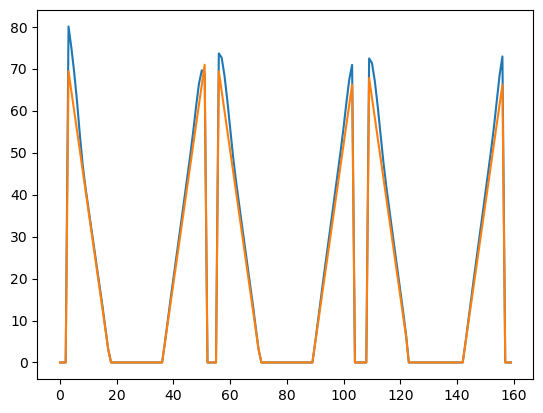

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


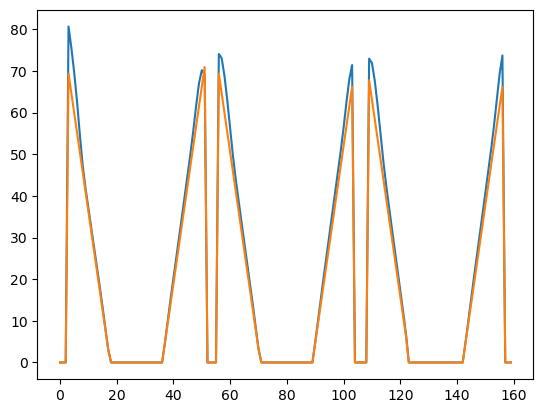

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


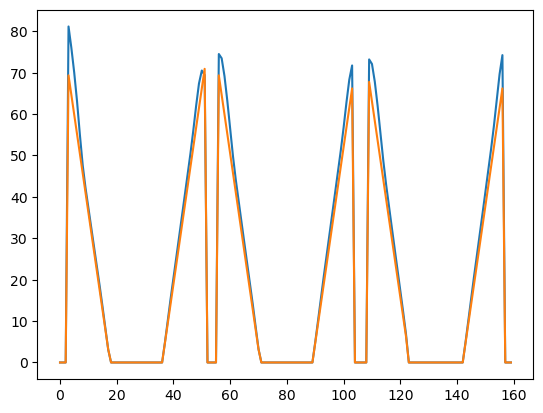

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


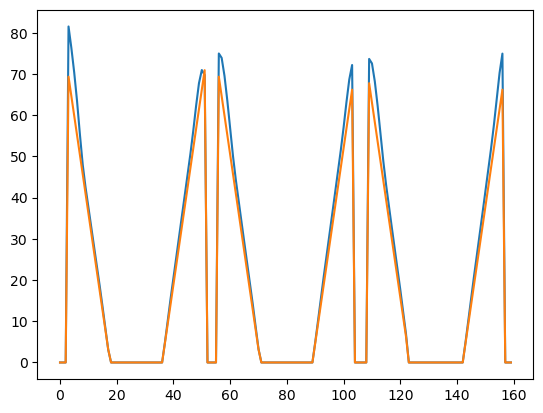

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


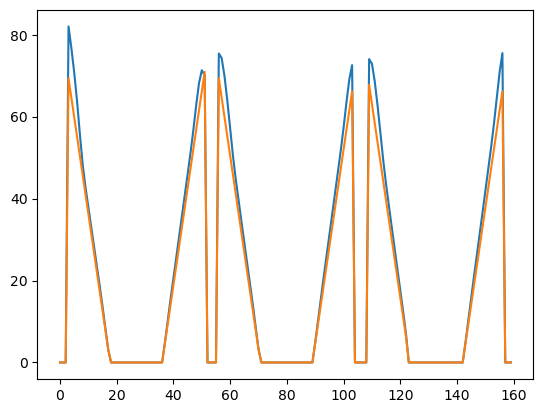

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


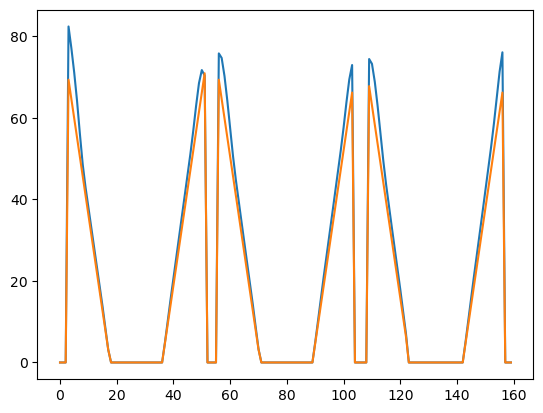

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


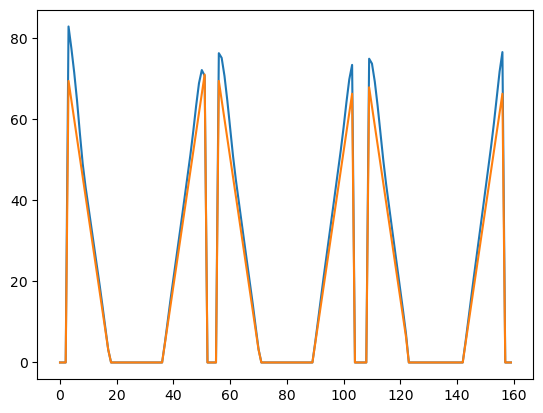

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


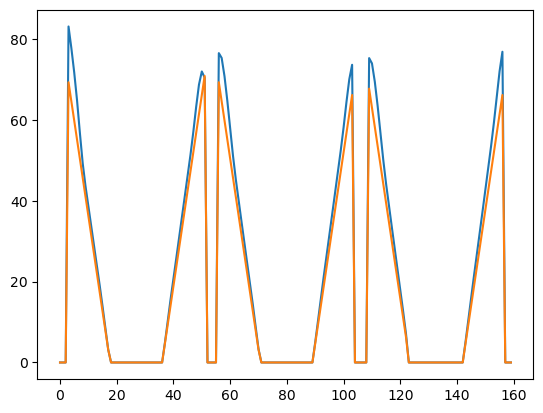

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


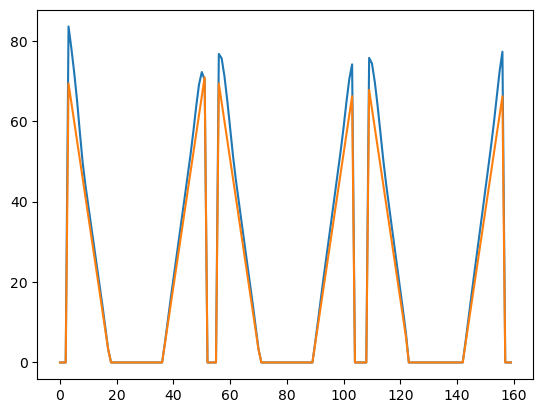

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


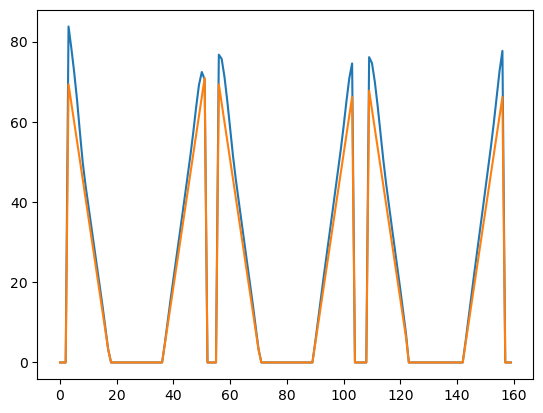

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


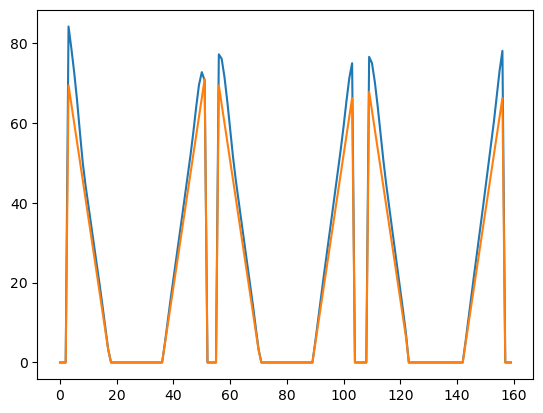

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


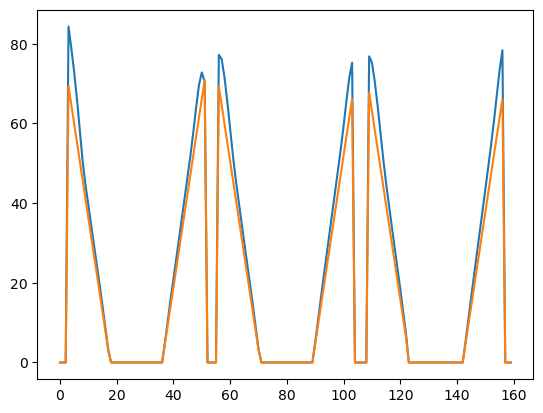

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


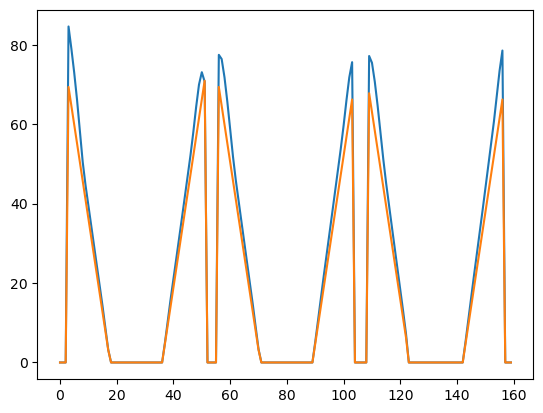

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


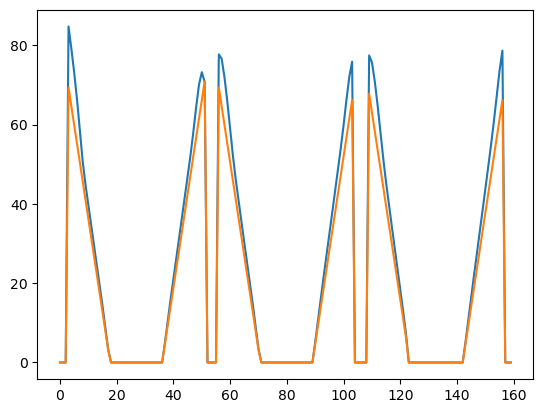

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


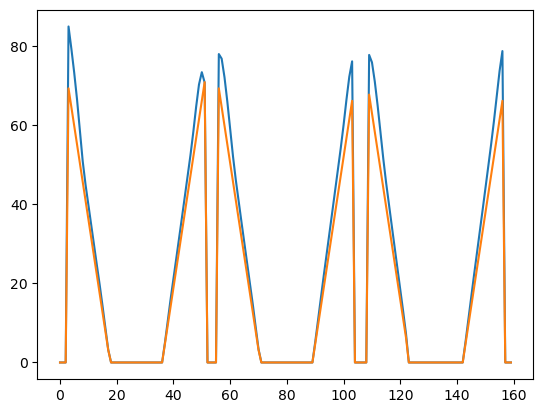

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


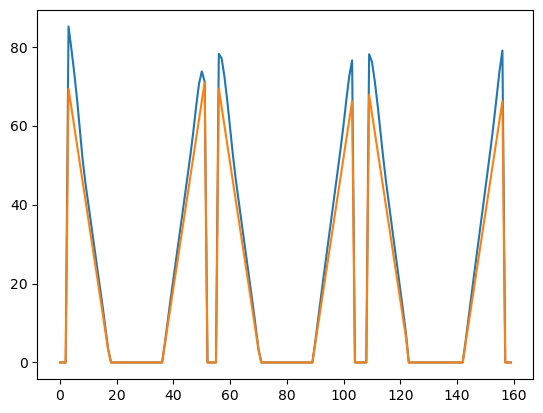

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


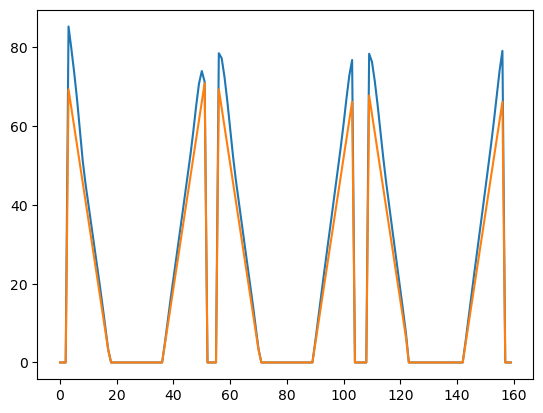

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


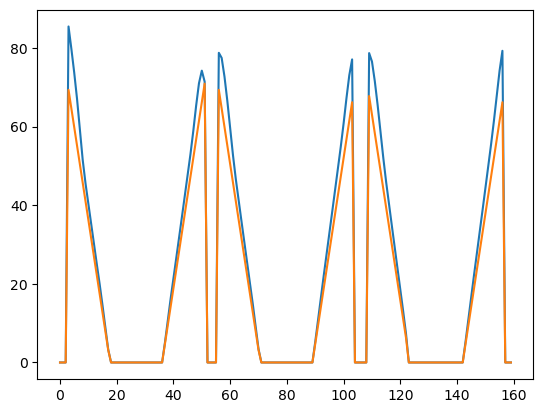

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


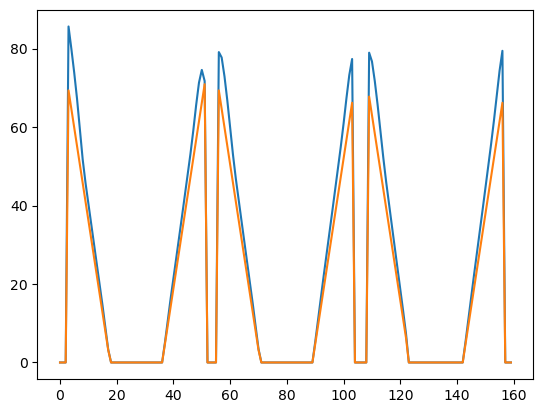

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


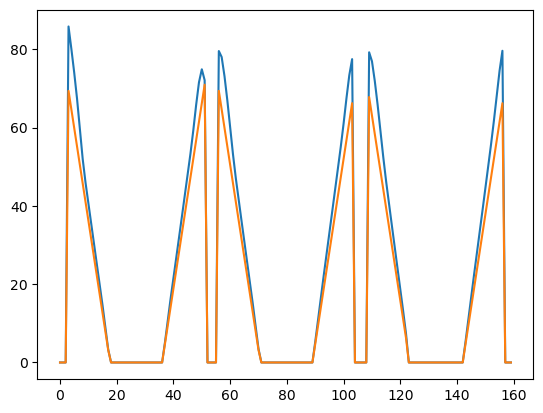

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


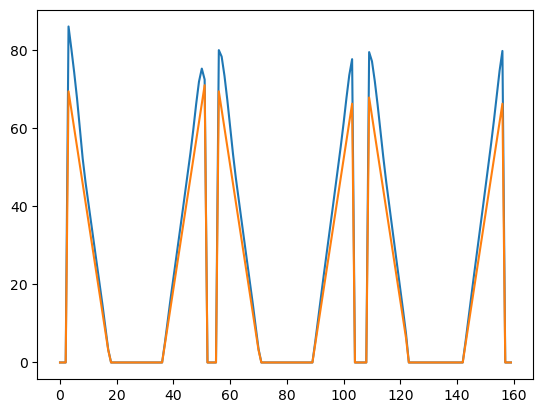

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


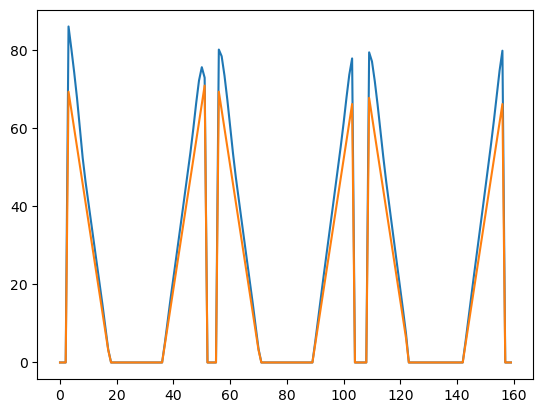

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


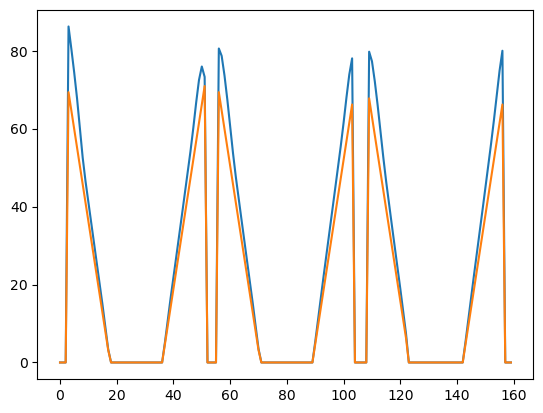

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


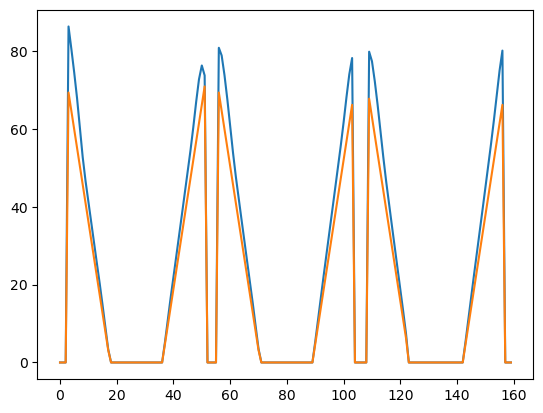

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


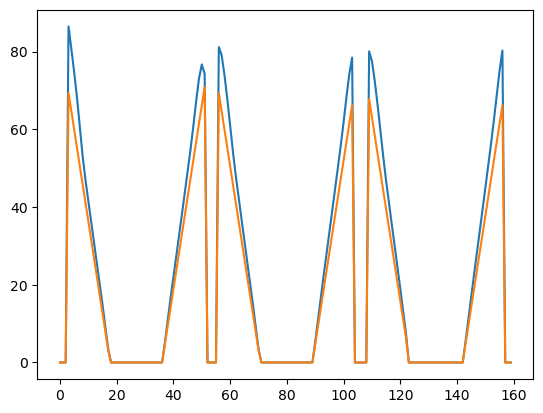

Ehrenstein_Illusion 	em step:  484 485
Processing:  dots_Brightness-Optical-Illusion
Making grayscale:  torch.Size([1, 3, 160, 160])
torch.Size([1, 1, 160, 160])
Opening image ./optical_illusions/dots_Brightness-Optical-Illusion.png with test strip file ./optical_illusions/test_strips/dots_Brightness-Optical-Illusion_teststrip_part_a.png
Could not find ./optical_illusions/test_strips/dots_Brightness-Optical-Illusion_teststrip_part_b.png, making zeros.
Test strip stats:  tensor(0.0437, dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(1., dtype=torch.float32)
Test strip stats:  tensor(0., dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(0., dtype=torch.float32)
img:  torch.Size([1, 1, 160, 160])em step:  0 485
torch.Size([160])


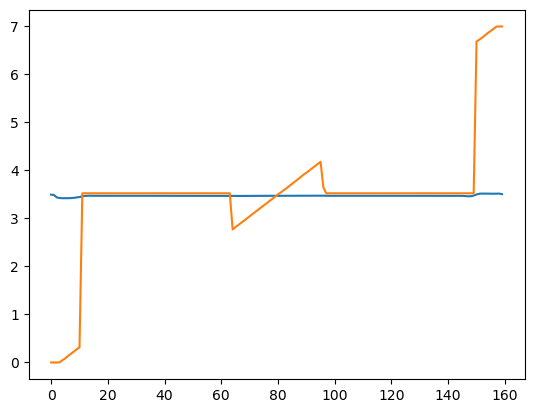

img:  torch.Size([1, 1, 160, 160])em step:  10 485
torch.Size([160])


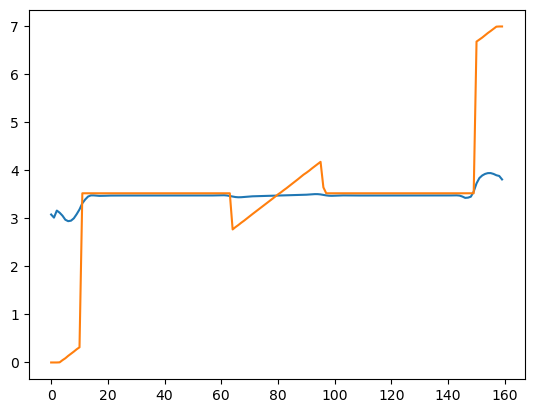

img:  torch.Size([1, 1, 160, 160])em step:  20 485
torch.Size([160])


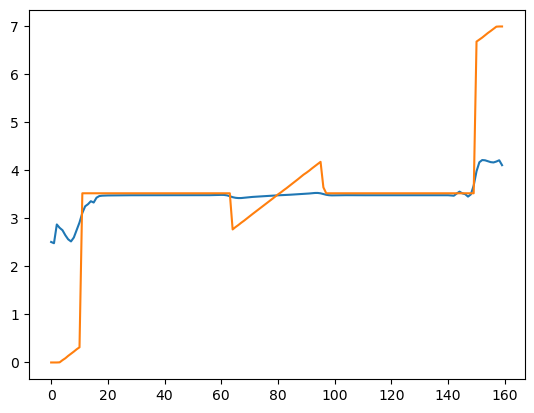

img:  torch.Size([1, 1, 160, 160])em step:  30 485
torch.Size([160])


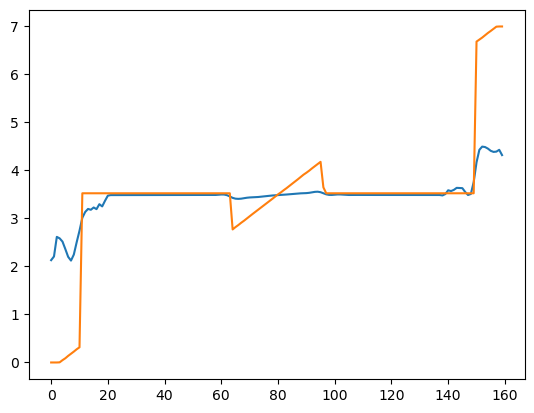

img:  torch.Size([1, 1, 160, 160])em step:  40 485
torch.Size([160])


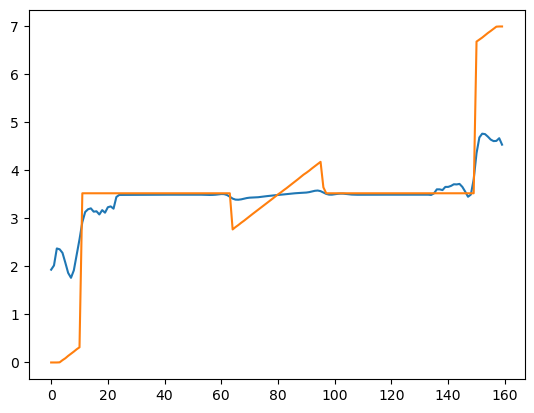

img:  torch.Size([1, 1, 160, 160])em step:  50 485
torch.Size([160])


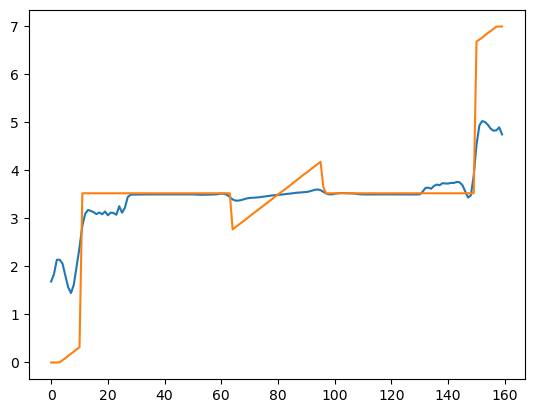

img:  torch.Size([1, 1, 160, 160])em step:  60 485
torch.Size([160])


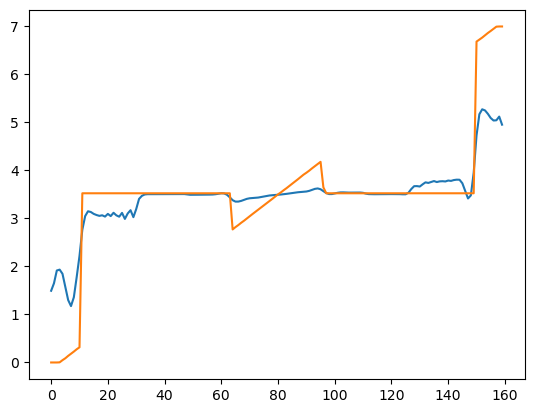

img:  torch.Size([1, 1, 160, 160])em step:  70 485
torch.Size([160])


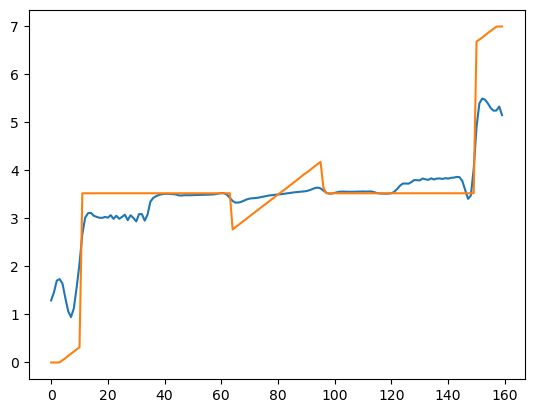

img:  torch.Size([1, 1, 160, 160])em step:  80 485
torch.Size([160])


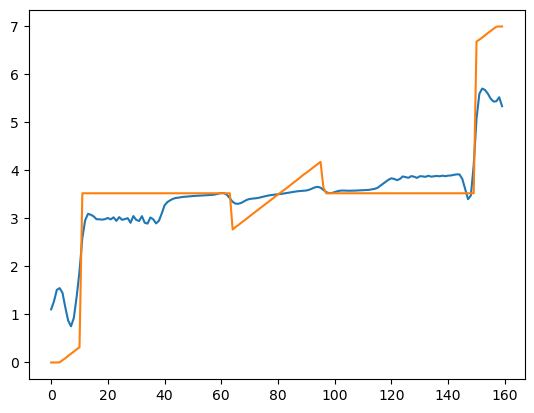

img:  torch.Size([1, 1, 160, 160])em step:  90 485
torch.Size([160])


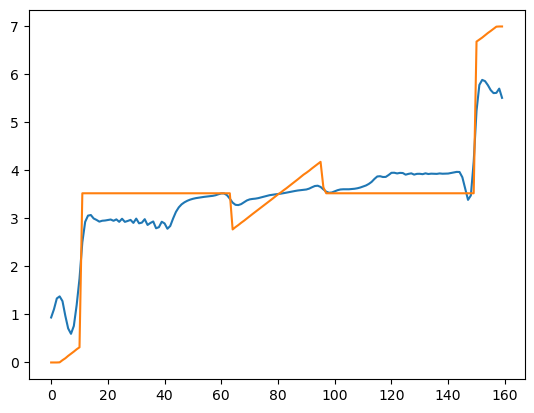

img:  torch.Size([1, 1, 160, 160])em step:  100 485
torch.Size([160])


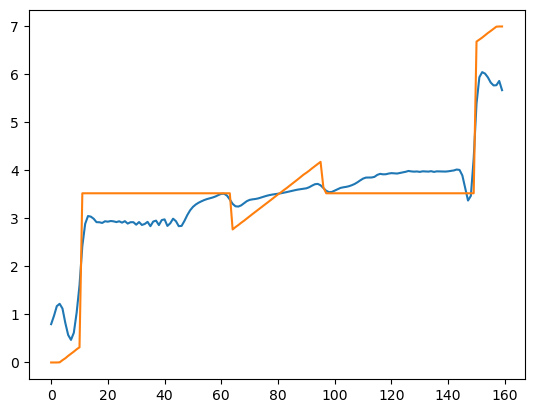

img:  torch.Size([1, 1, 160, 160])em step:  110 485
torch.Size([160])


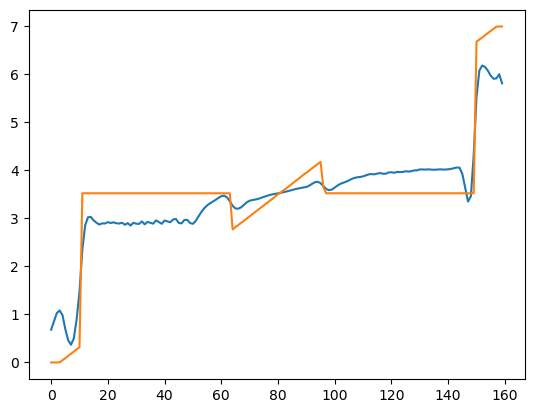

img:  torch.Size([1, 1, 160, 160])em step:  120 485
torch.Size([160])


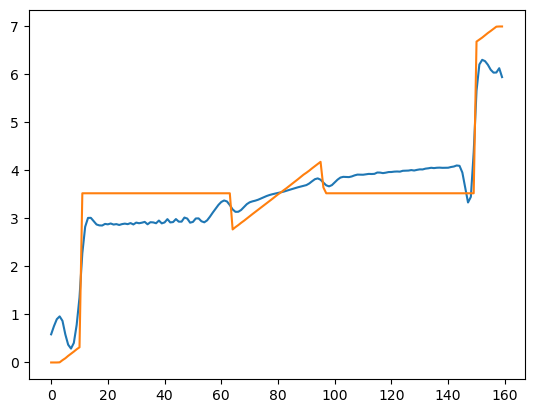

img:  torch.Size([1, 1, 160, 160])em step:  130 485
torch.Size([160])


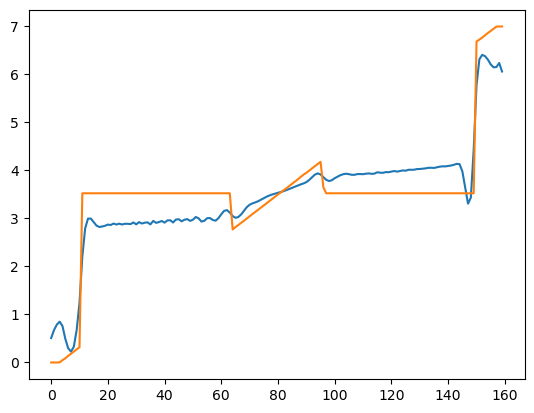

img:  torch.Size([1, 1, 160, 160])em step:  140 485
torch.Size([160])


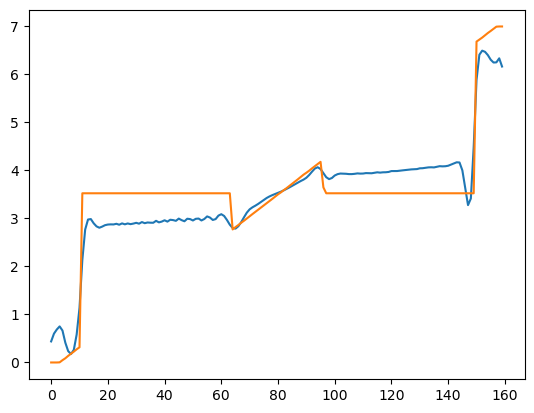

img:  torch.Size([1, 1, 160, 160])em step:  150 485
torch.Size([160])


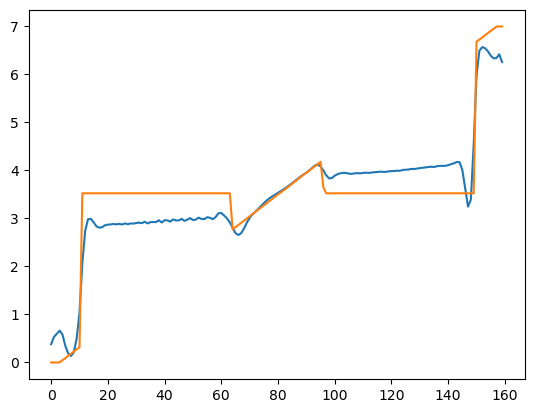

img:  torch.Size([1, 1, 160, 160])em step:  160 485
torch.Size([160])


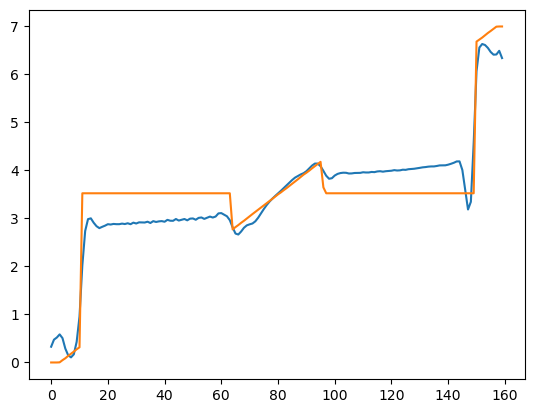

img:  torch.Size([1, 1, 160, 160])em step:  170 485
torch.Size([160])


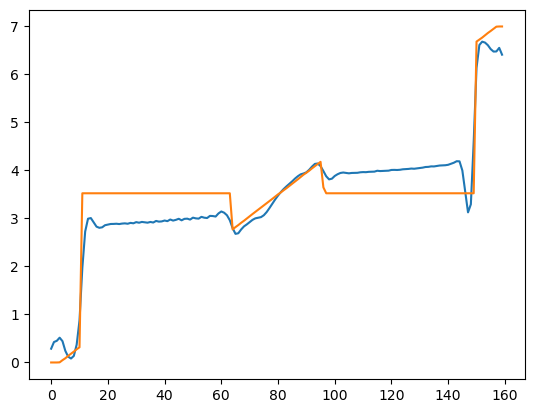

img:  torch.Size([1, 1, 160, 160])em step:  180 485
torch.Size([160])


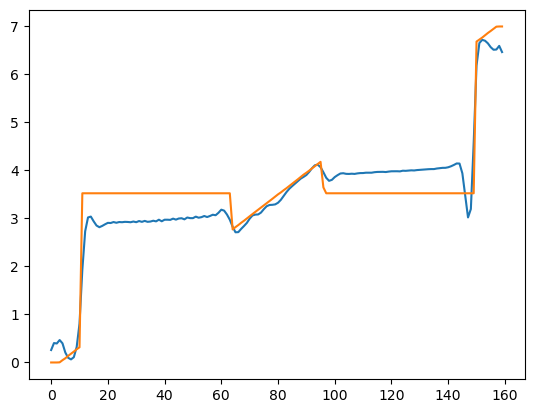

img:  torch.Size([1, 1, 160, 160])em step:  190 485
torch.Size([160])


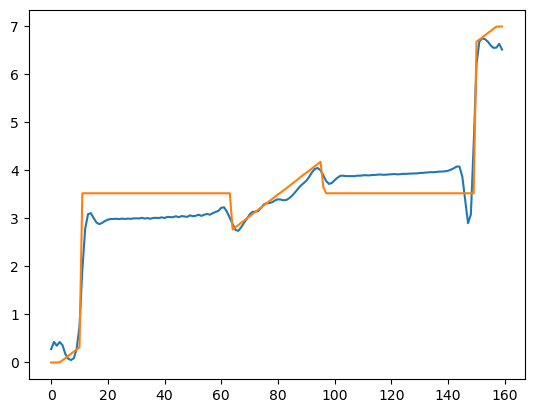

img:  torch.Size([1, 1, 160, 160])em step:  200 485
torch.Size([160])


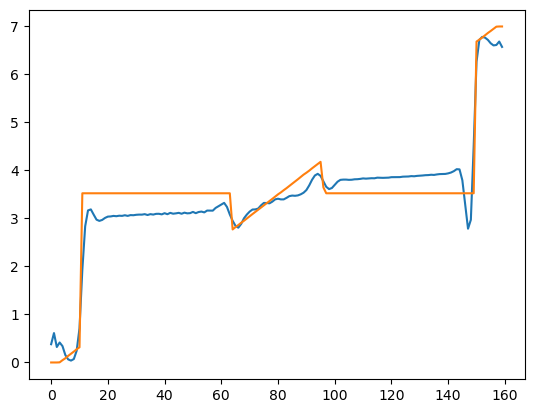

img:  torch.Size([1, 1, 160, 160])em step:  210 485
torch.Size([160])


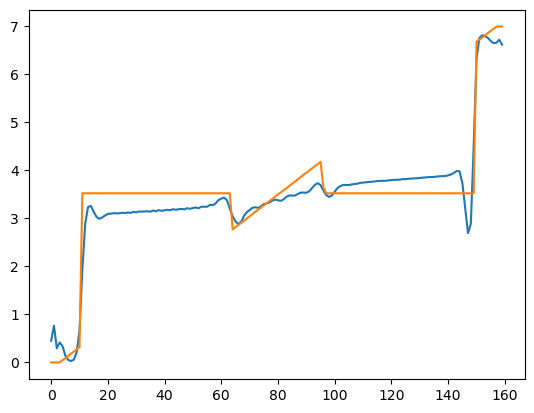

img:  torch.Size([1, 1, 160, 160])em step:  220 485
torch.Size([160])


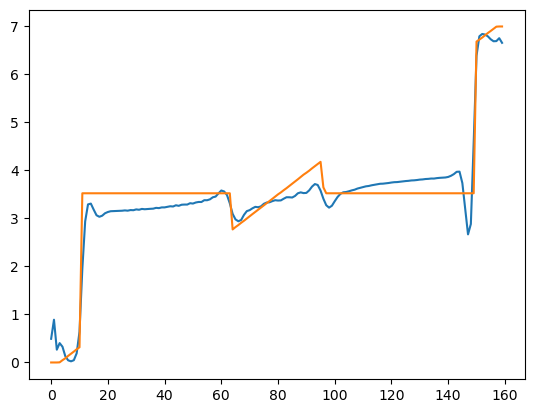

img:  torch.Size([1, 1, 160, 160])em step:  230 485
torch.Size([160])


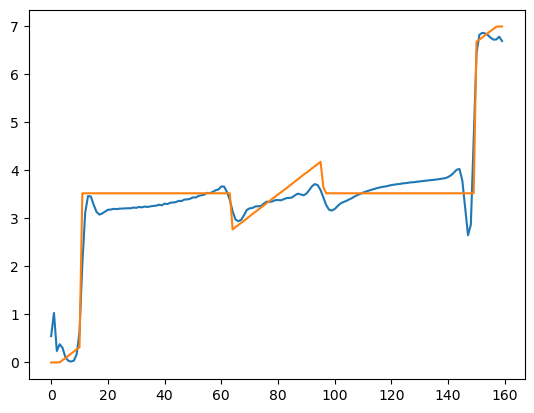

img:  torch.Size([1, 1, 160, 160])em step:  240 485
torch.Size([160])


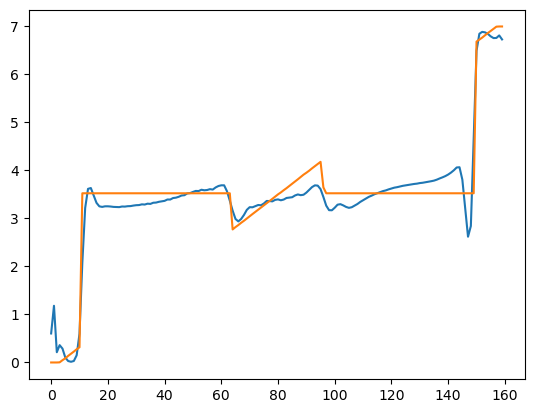

img:  torch.Size([1, 1, 160, 160])em step:  250 485
torch.Size([160])


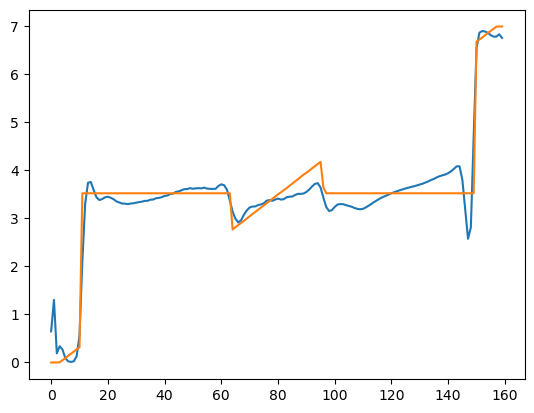

img:  torch.Size([1, 1, 160, 160])em step:  260 485
torch.Size([160])


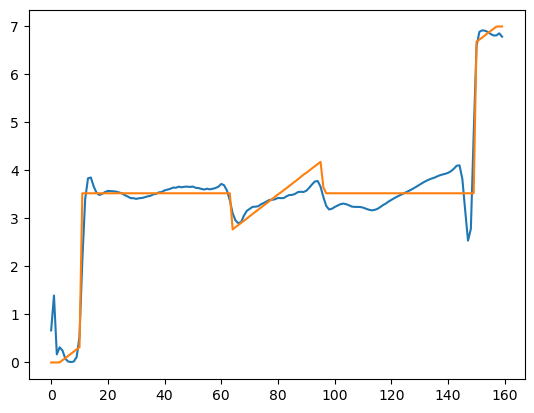

img:  torch.Size([1, 1, 160, 160])em step:  270 485
torch.Size([160])


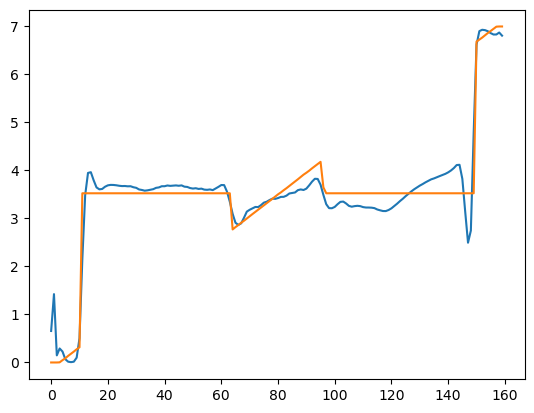

img:  torch.Size([1, 1, 160, 160])em step:  280 485
torch.Size([160])


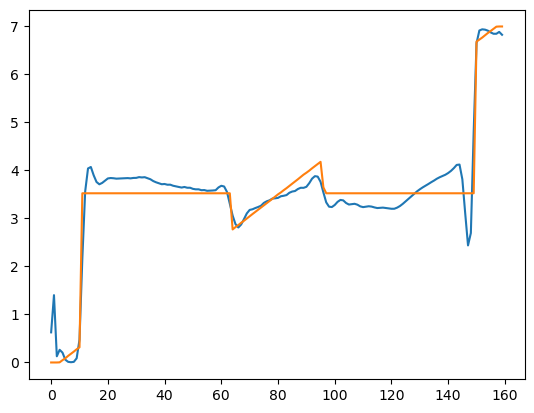

img:  torch.Size([1, 1, 160, 160])em step:  290 485
torch.Size([160])


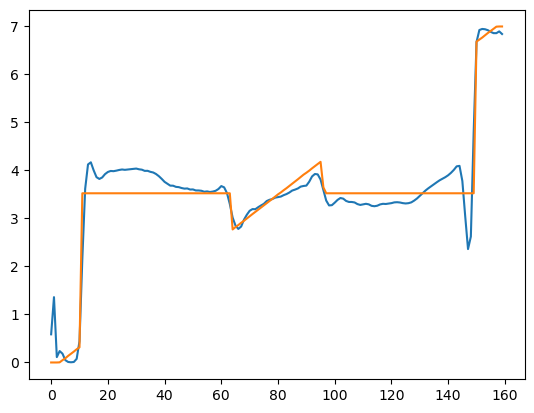

img:  torch.Size([1, 1, 160, 160])em step:  300 485
torch.Size([160])


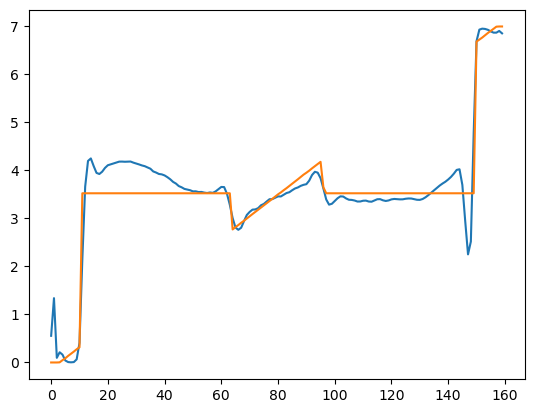

img:  torch.Size([1, 1, 160, 160])em step:  310 485
torch.Size([160])


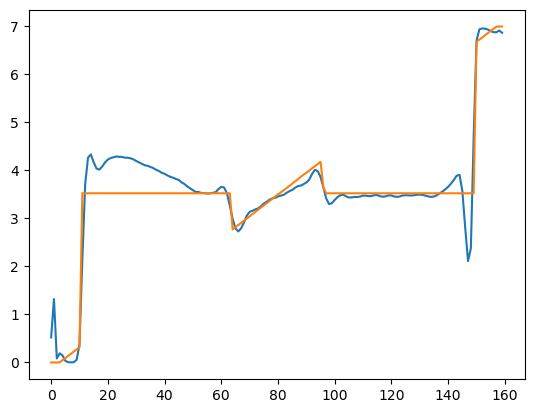

img:  torch.Size([1, 1, 160, 160])em step:  320 485
torch.Size([160])


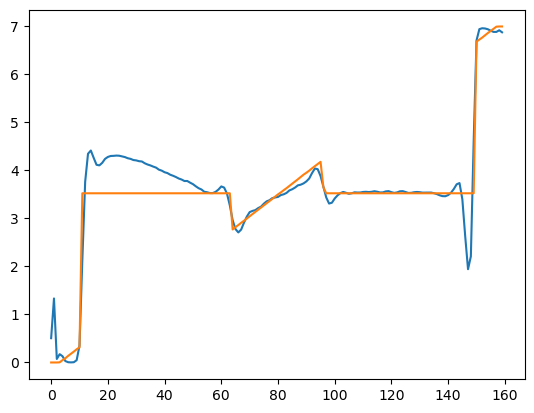

img:  torch.Size([1, 1, 160, 160])em step:  330 485
torch.Size([160])


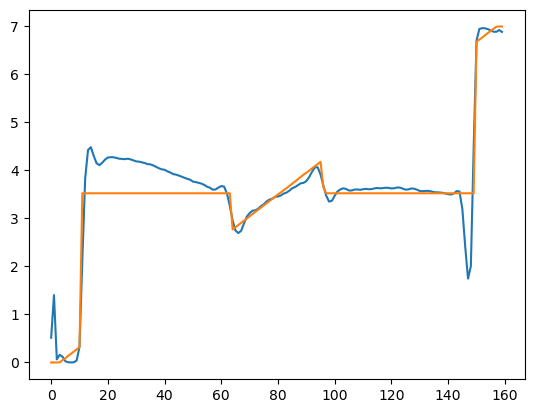

img:  torch.Size([1, 1, 160, 160])em step:  340 485
torch.Size([160])


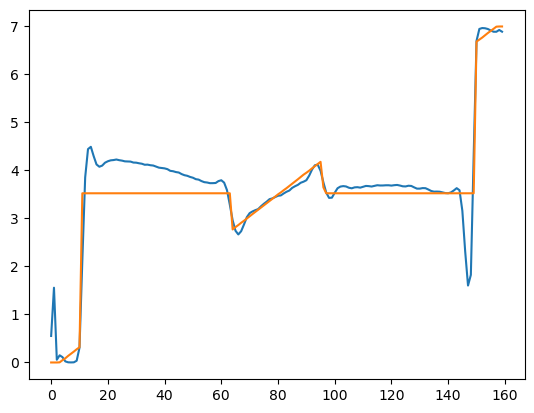

img:  torch.Size([1, 1, 160, 160])em step:  350 485
torch.Size([160])


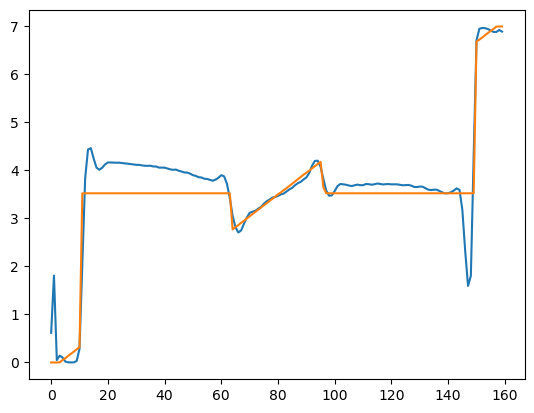

img:  torch.Size([1, 1, 160, 160])em step:  360 485
torch.Size([160])


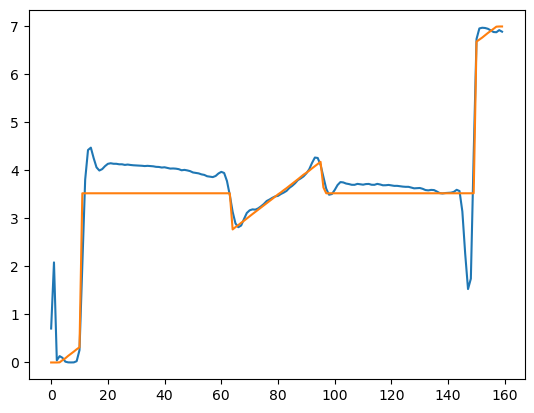

img:  torch.Size([1, 1, 160, 160])em step:  370 485
torch.Size([160])


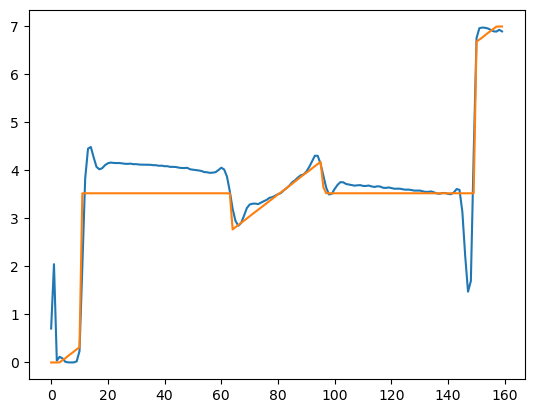

img:  torch.Size([1, 1, 160, 160])em step:  380 485
torch.Size([160])


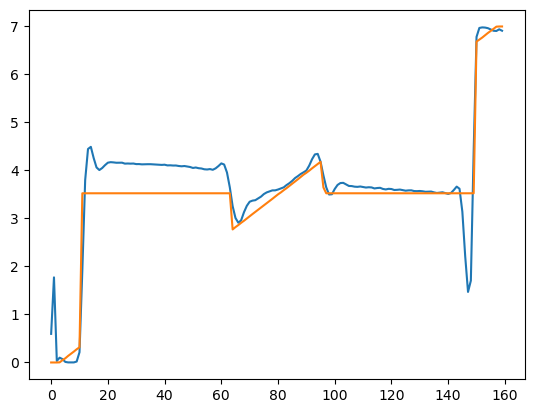

img:  torch.Size([1, 1, 160, 160])em step:  390 485
torch.Size([160])


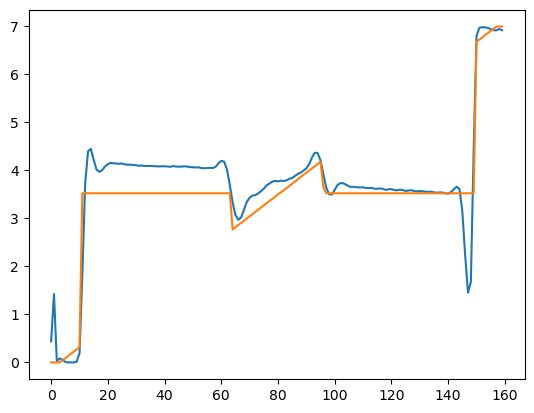

img:  torch.Size([1, 1, 160, 160])em step:  400 485
torch.Size([160])


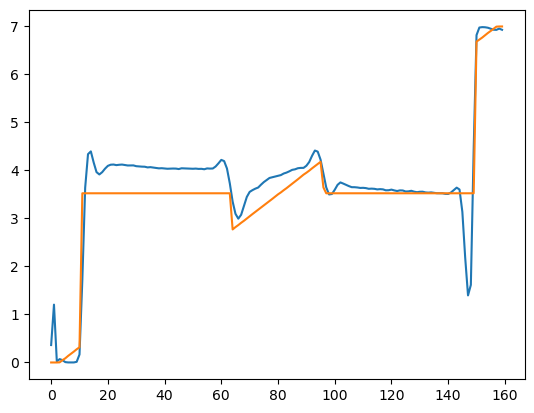

img:  torch.Size([1, 1, 160, 160])em step:  410 485
torch.Size([160])


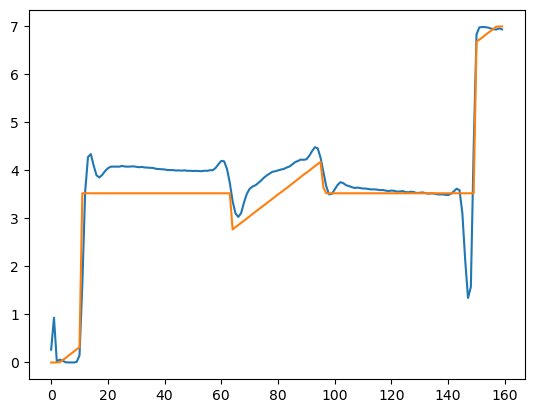

img:  torch.Size([1, 1, 160, 160])em step:  420 485
torch.Size([160])


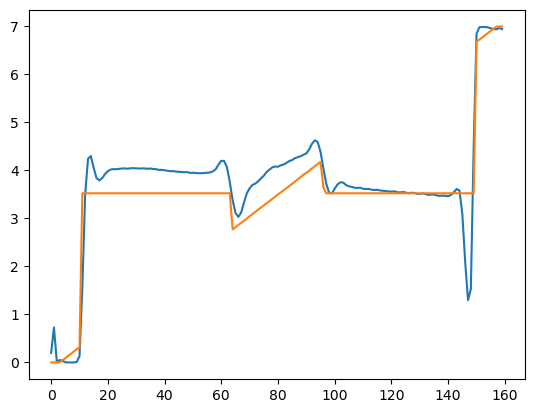

img:  torch.Size([1, 1, 160, 160])em step:  430 485
torch.Size([160])


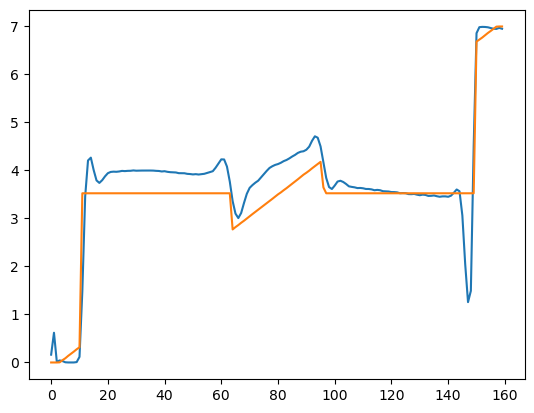

img:  torch.Size([1, 1, 160, 160])em step:  440 485
torch.Size([160])


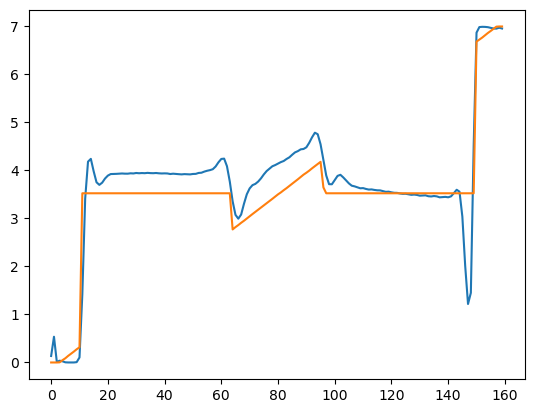

img:  torch.Size([1, 1, 160, 160])em step:  450 485
torch.Size([160])


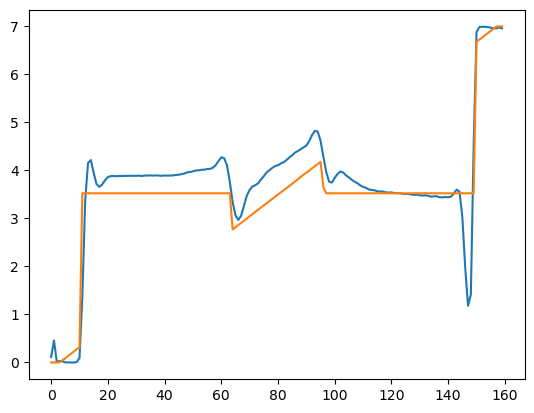

img:  torch.Size([1, 1, 160, 160])em step:  460 485
torch.Size([160])


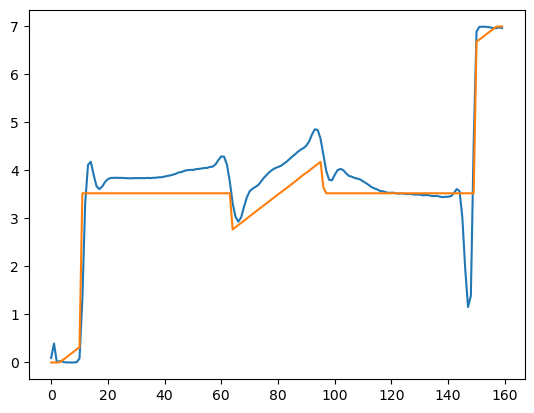

img:  torch.Size([1, 1, 160, 160])em step:  470 485
torch.Size([160])


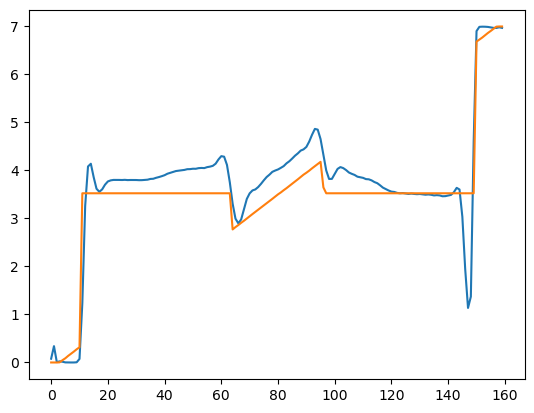

img:  torch.Size([1, 1, 160, 160])em step:  480 485
torch.Size([160])


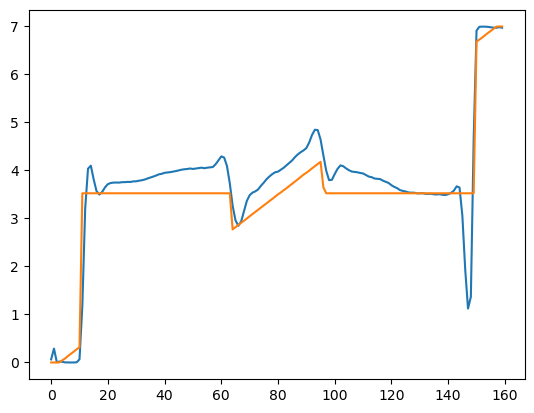

dots_Brightness-Optical-Illusion 	em step:  484 485
Processing:  illusory_brigntness
Making grayscale:  torch.Size([1, 3, 160, 160])
torch.Size([1, 1, 160, 160])
Opening image ./optical_illusions/illusory_brigntness.png with test strip file ./optical_illusions/test_strips/illusory_brigntness_teststrip_part_a.png
Test strip stats:  tensor(0.5377, dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(1., dtype=torch.float32)
Test strip stats:  tensor(0.1365, dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(1., dtype=torch.float32)
img:  torch.Size([1, 1, 160, 160])85
torch.Size([160])


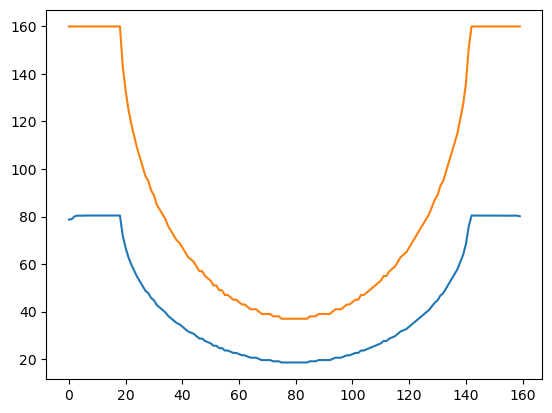

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


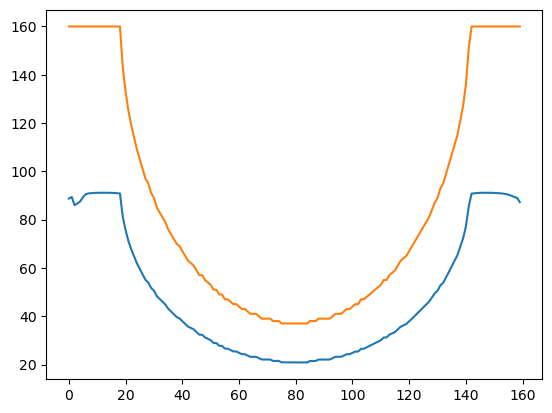

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


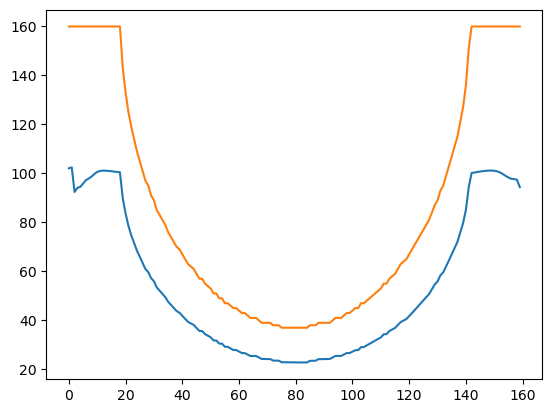

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


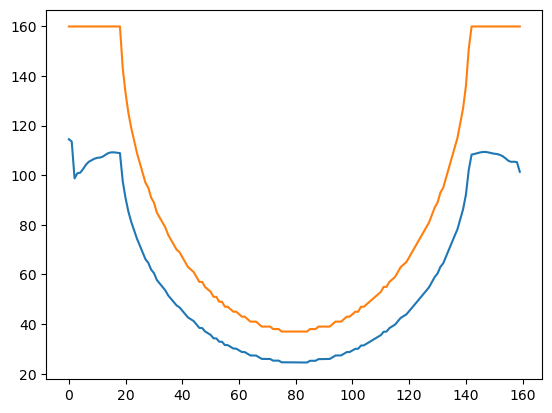

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


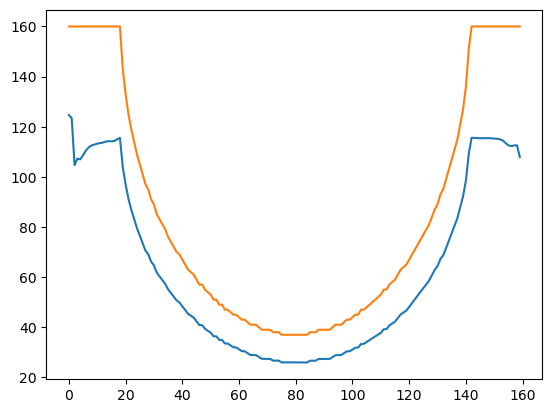

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


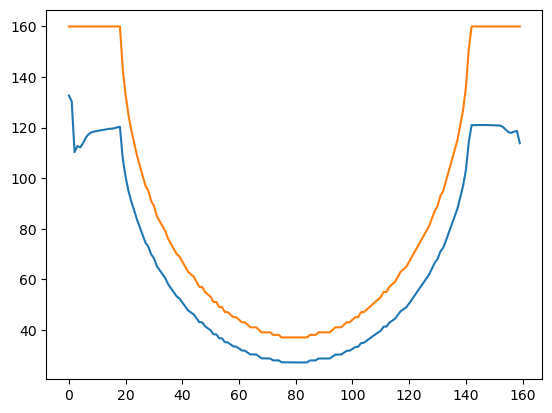

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


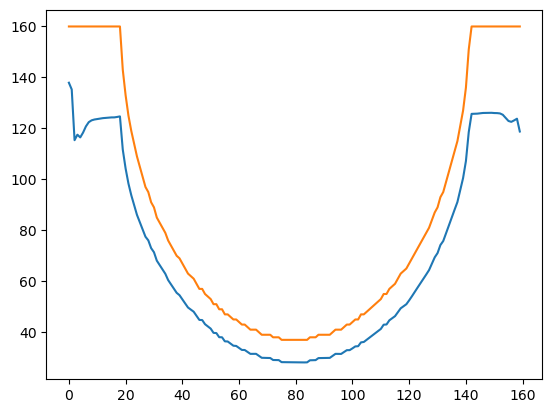

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


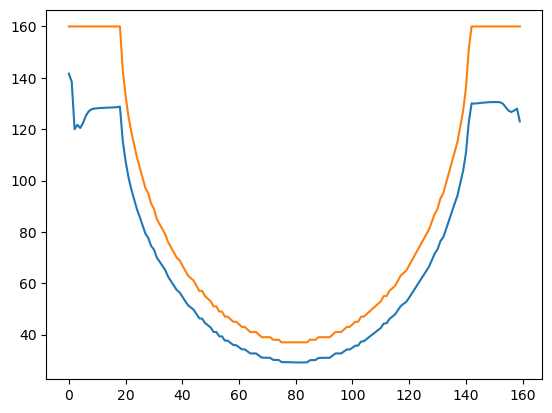

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


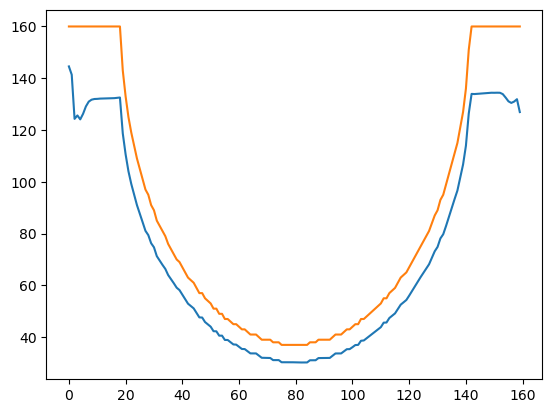

img:  torch.Size([1, 1, 160, 160])485
torch.Size([160])


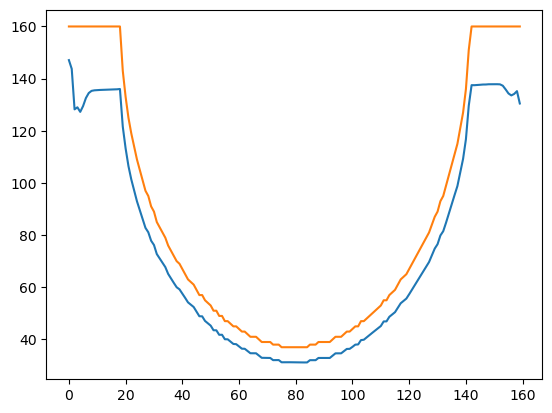

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


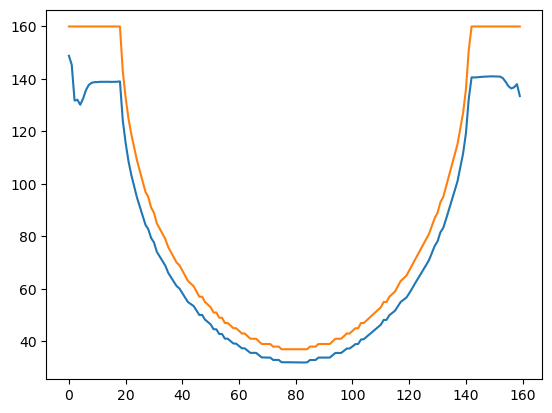

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


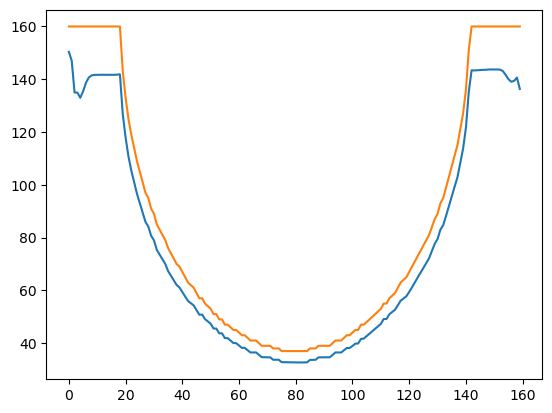

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


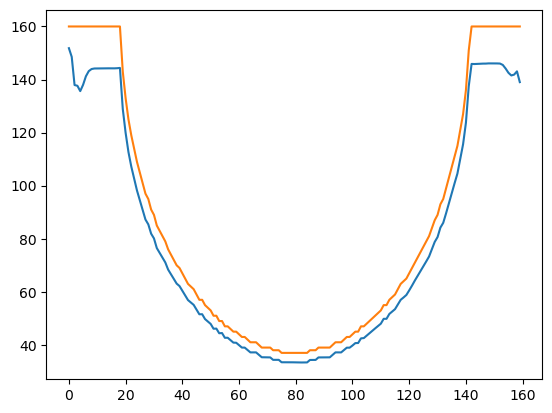

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


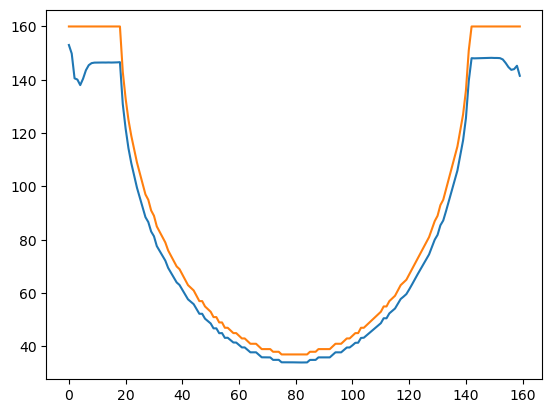

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


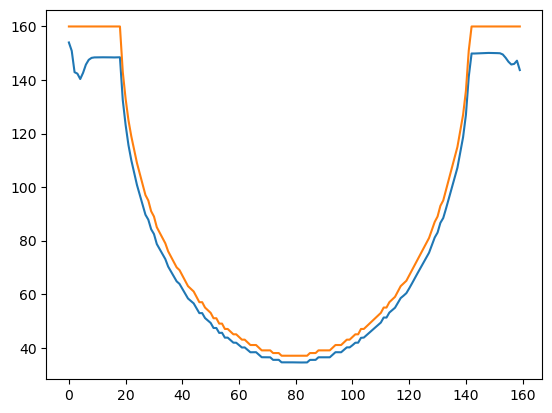

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


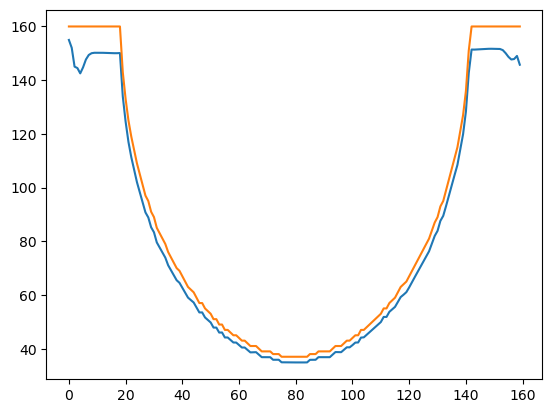

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


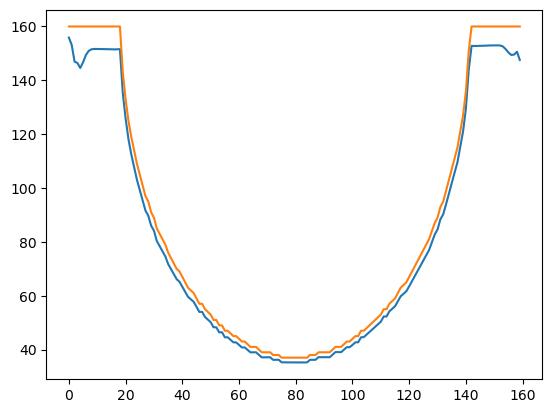

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


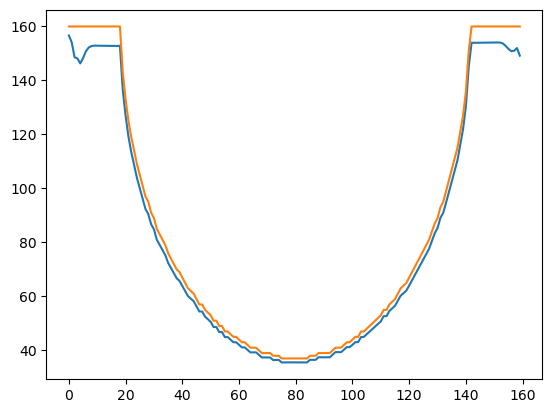

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


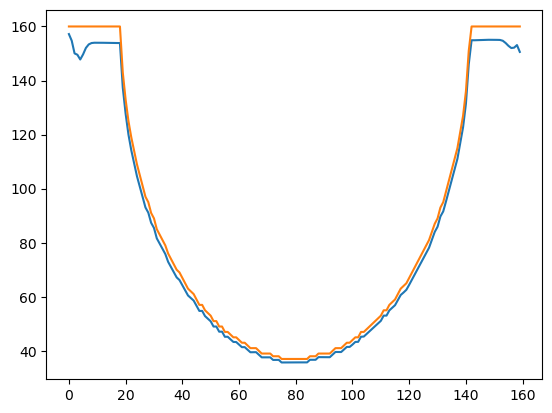

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


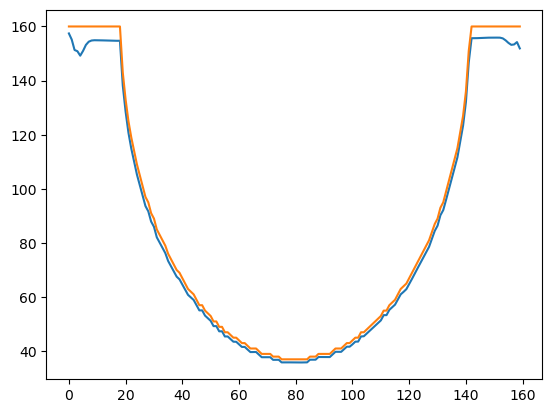

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


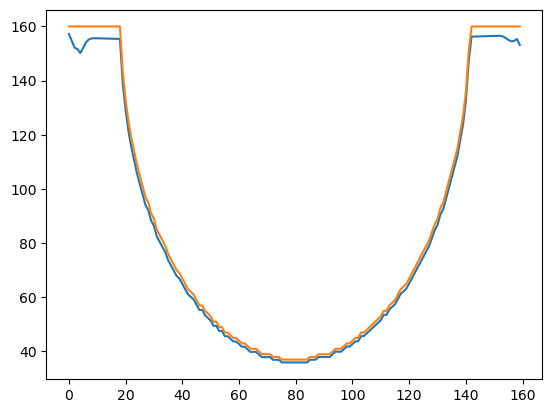

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


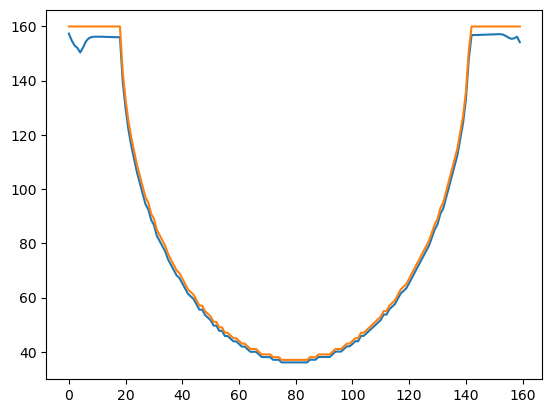

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


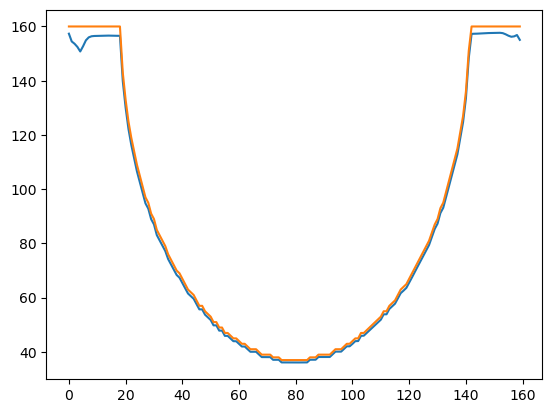

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


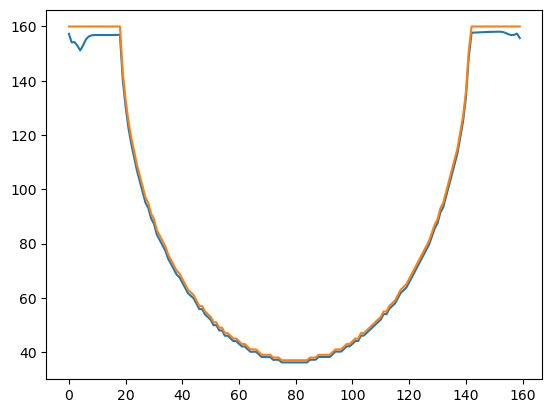

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


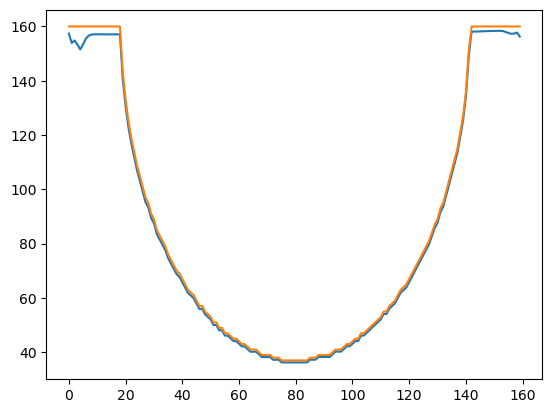

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


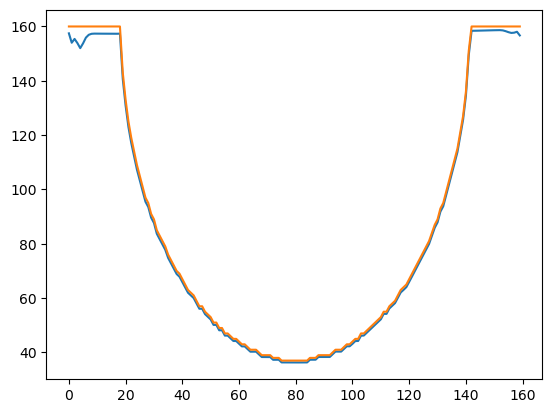

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


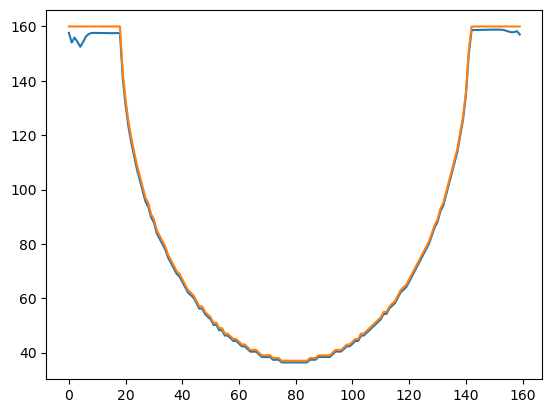

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


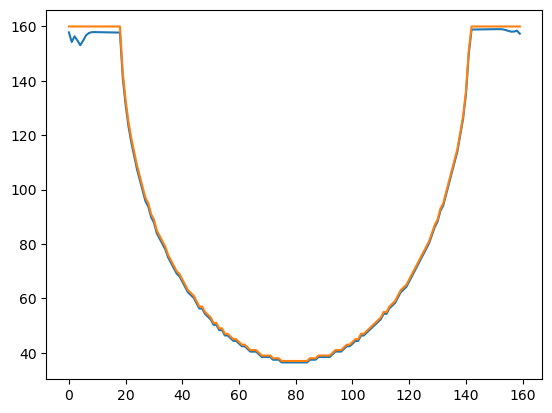

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


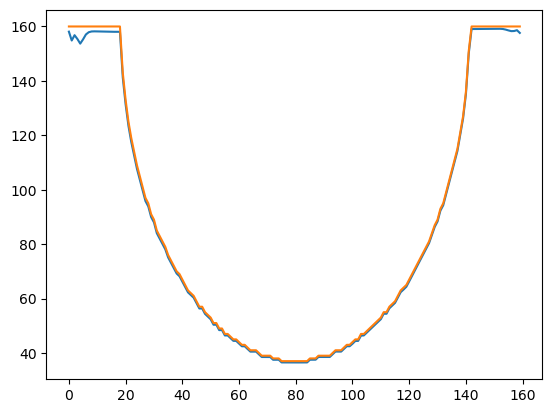

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


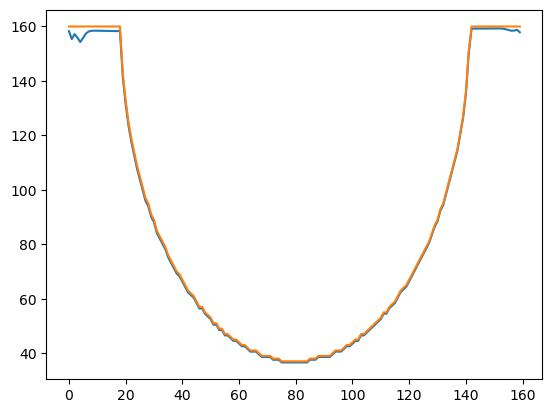

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


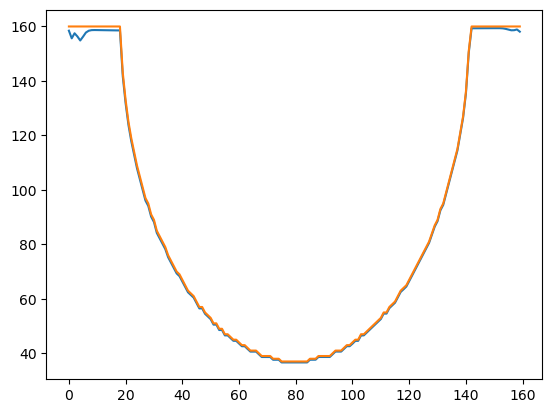

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


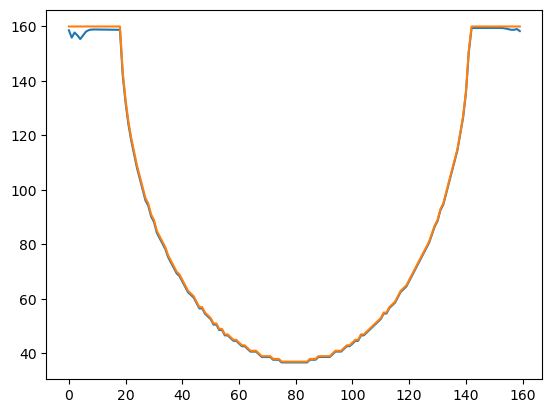

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


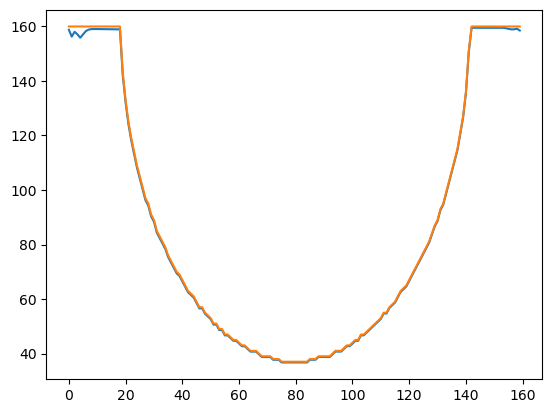

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


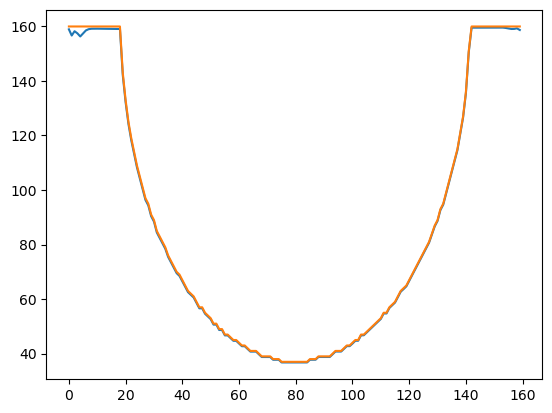

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


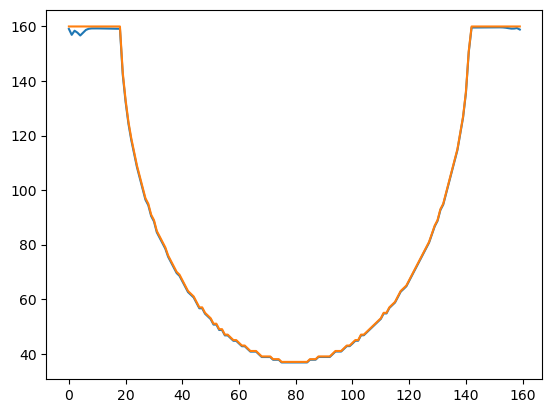

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


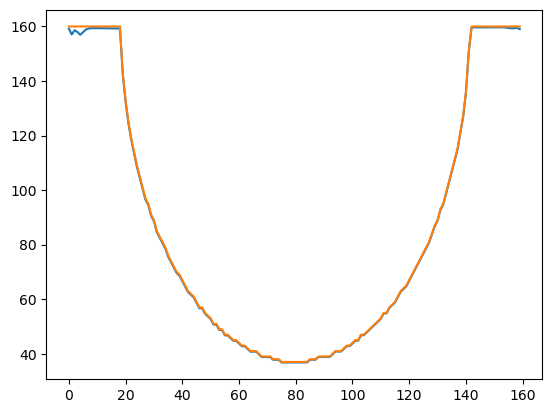

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


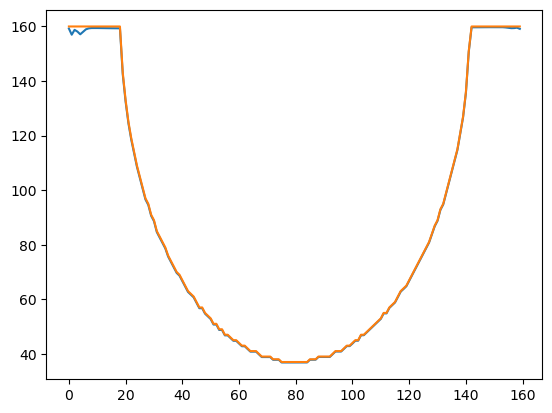

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


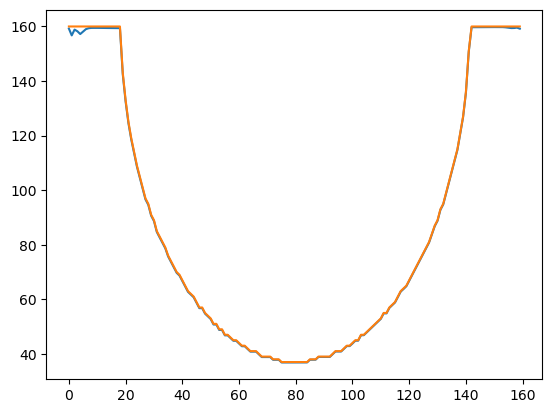

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


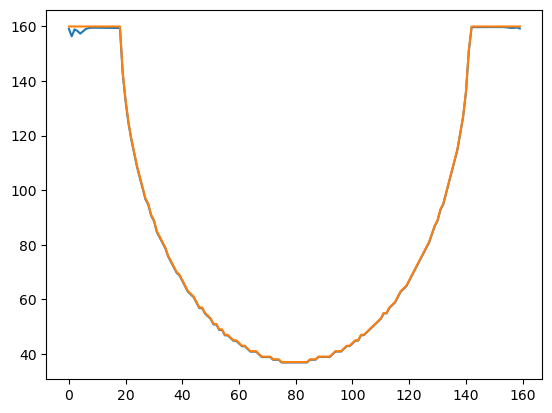

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


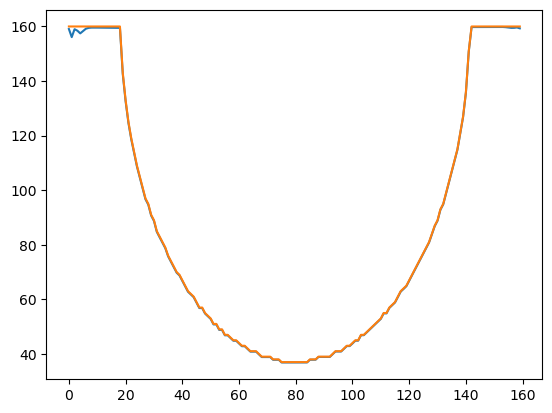

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


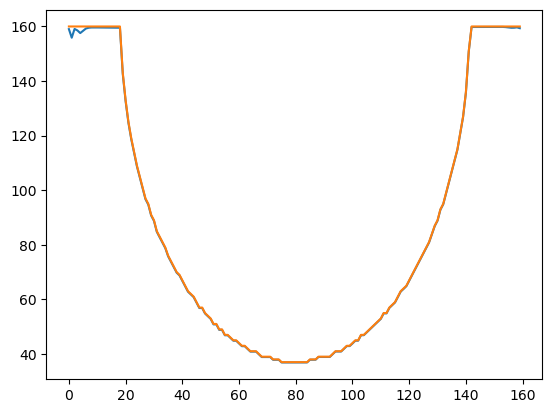

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


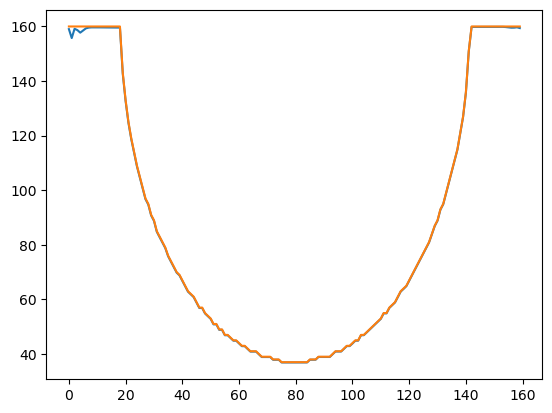

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


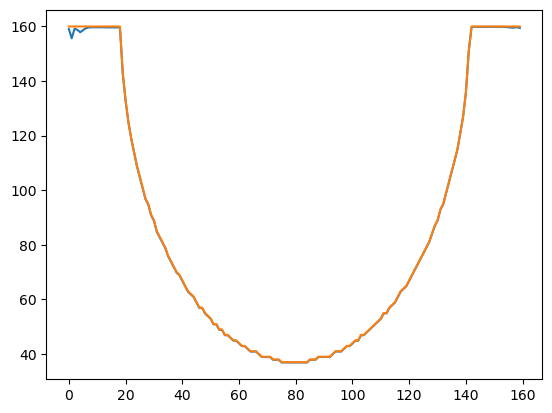

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


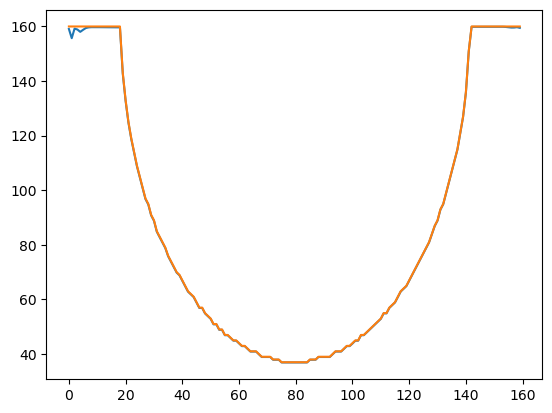

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


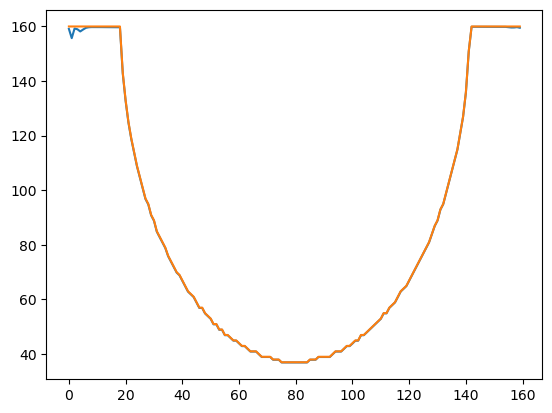

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


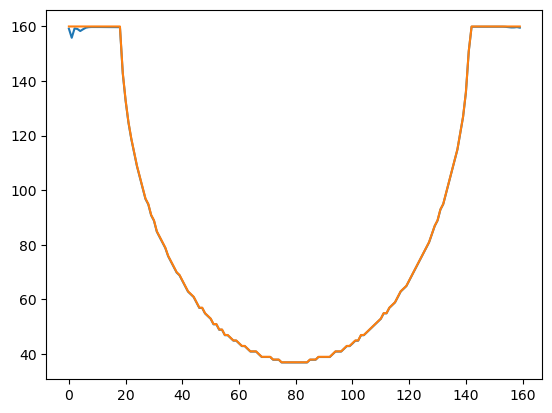

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


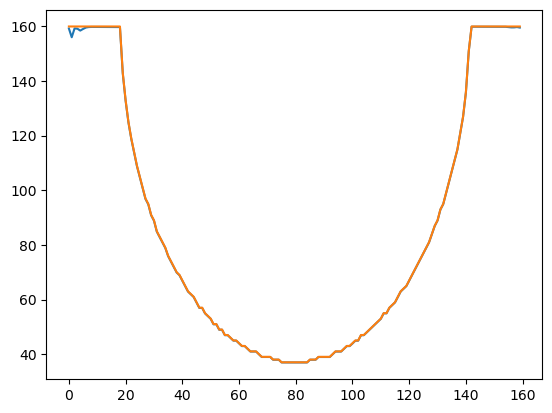

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


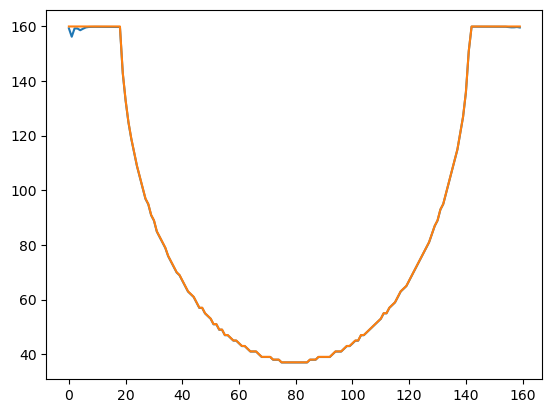

img:  torch.Size([1, 1, 160, 160]) 485
torch.Size([160])


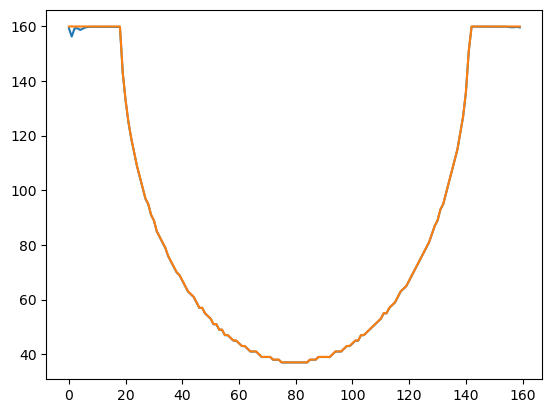

illusory_brigntness 	em step:  484 485
Processing:  illusory_brigntness_reverse
Making grayscale:  torch.Size([1, 3, 160, 160])
torch.Size([1, 1, 160, 160])
Opening image ./optical_illusions/illusory_brigntness_reverse.png with test strip file ./optical_illusions/test_strips/illusory_brigntness_reverse_teststrip_part_a.png
Test strip stats:  tensor(0.0842, dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(1., dtype=torch.float32)
Test strip stats:  tensor(0.6371, dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(1., dtype=torch.float32)
img:  torch.Size([1, 1, 160, 160])ep:  0 485
torch.Size([160])


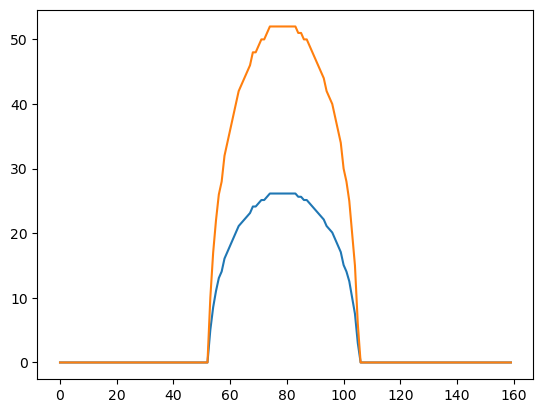

img:  torch.Size([1, 1, 160, 160])ep:  10 485
torch.Size([160])


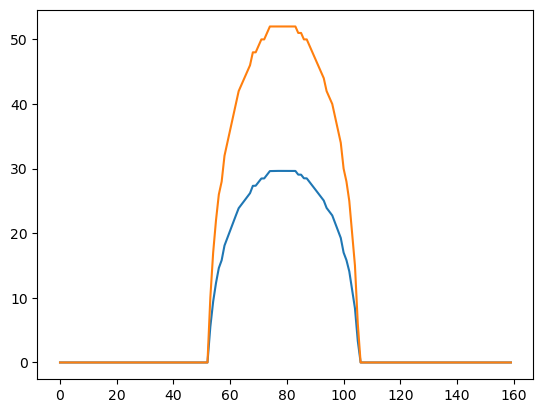

img:  torch.Size([1, 1, 160, 160])ep:  20 485
torch.Size([160])


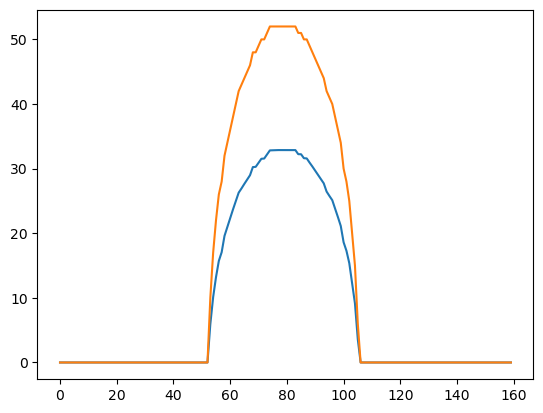

img:  torch.Size([1, 1, 160, 160])ep:  30 485
torch.Size([160])


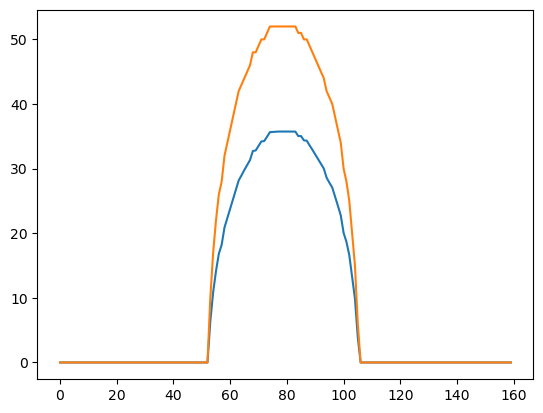

img:  torch.Size([1, 1, 160, 160])ep:  40 485
torch.Size([160])


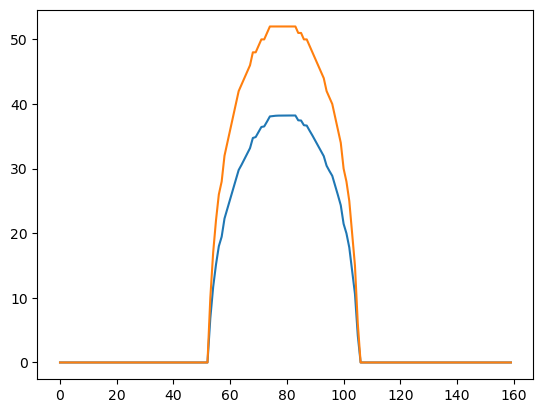

img:  torch.Size([1, 1, 160, 160])ep:  50 485
torch.Size([160])


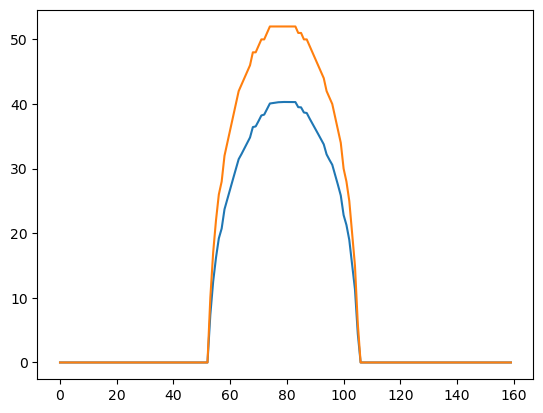

img:  torch.Size([1, 1, 160, 160])ep:  60 485
torch.Size([160])


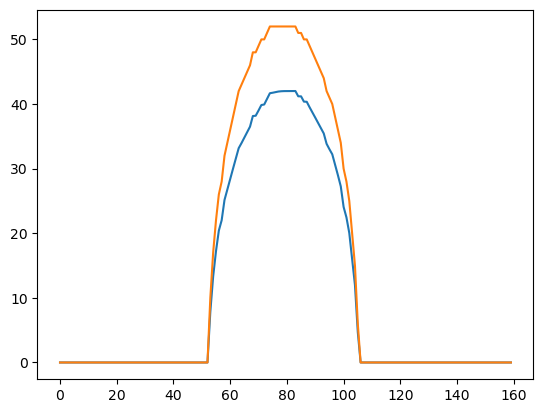

img:  torch.Size([1, 1, 160, 160])ep:  70 485
torch.Size([160])


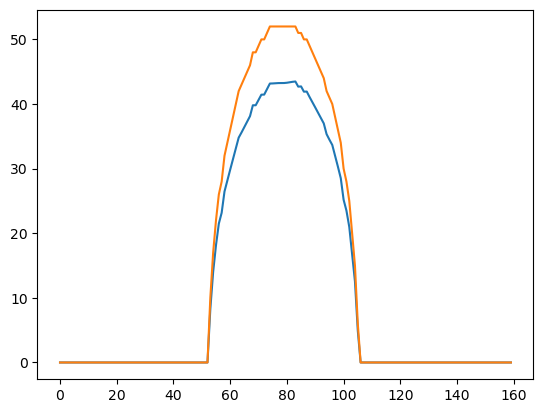

img:  torch.Size([1, 1, 160, 160])ep:  80 485
torch.Size([160])


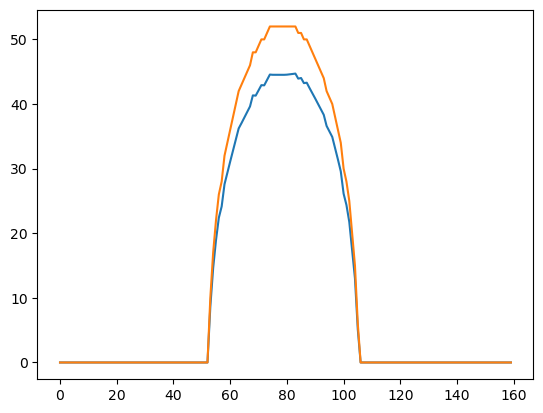

img:  torch.Size([1, 1, 160, 160])ep:  90 485
torch.Size([160])


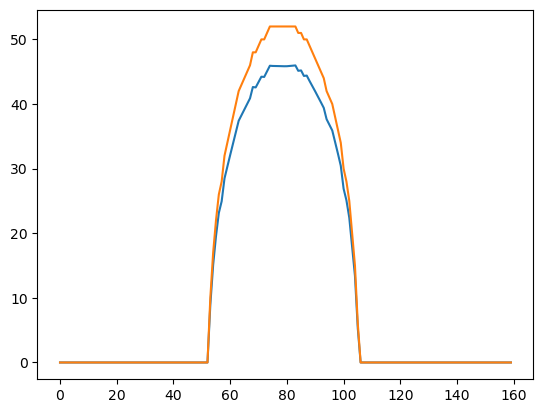

img:  torch.Size([1, 1, 160, 160])ep:  100 485
torch.Size([160])


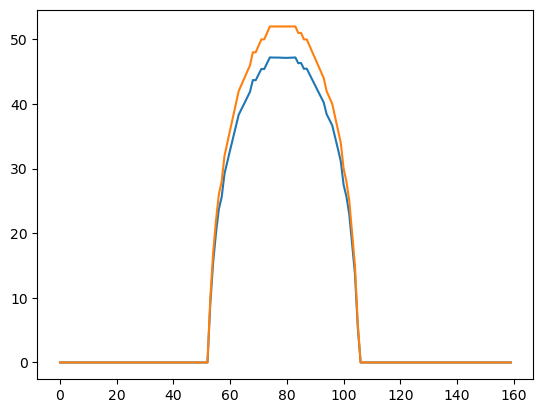

img:  torch.Size([1, 1, 160, 160])ep:  110 485
torch.Size([160])


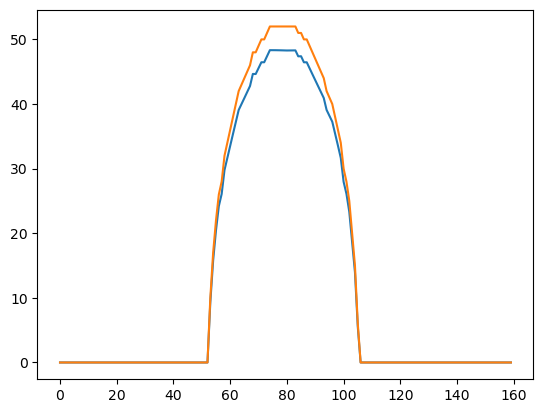

img:  torch.Size([1, 1, 160, 160])ep:  120 485
torch.Size([160])


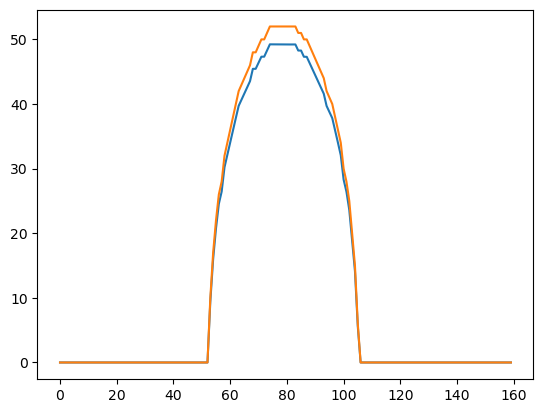

img:  torch.Size([1, 1, 160, 160])ep:  130 485
torch.Size([160])


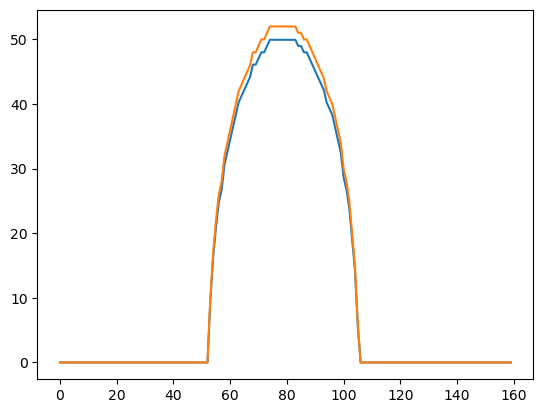

img:  torch.Size([1, 1, 160, 160])ep:  140 485
torch.Size([160])


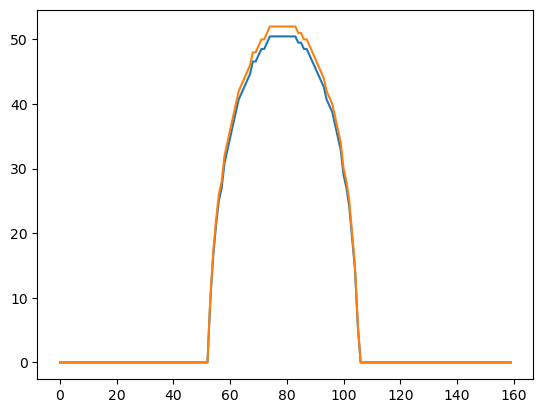

img:  torch.Size([1, 1, 160, 160])ep:  150 485
torch.Size([160])


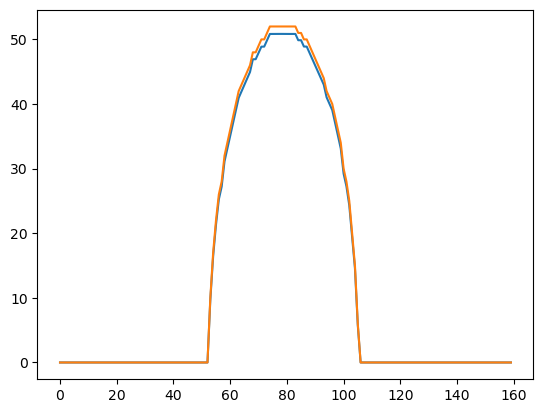

img:  torch.Size([1, 1, 160, 160])ep:  160 485
torch.Size([160])


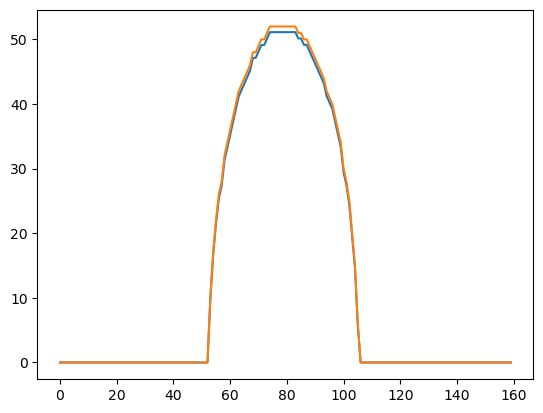

img:  torch.Size([1, 1, 160, 160])ep:  170 485
torch.Size([160])


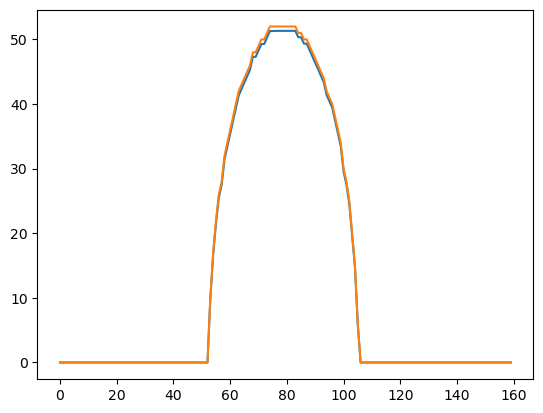

img:  torch.Size([1, 1, 160, 160])ep:  180 485
torch.Size([160])


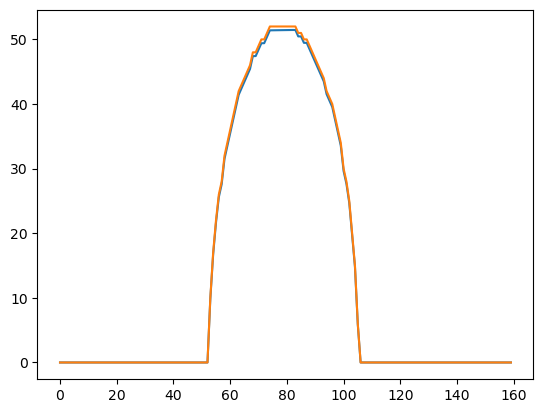

img:  torch.Size([1, 1, 160, 160])ep:  190 485
torch.Size([160])


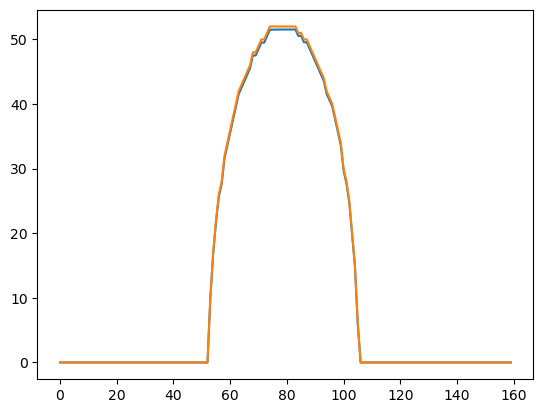

img:  torch.Size([1, 1, 160, 160])ep:  200 485
torch.Size([160])


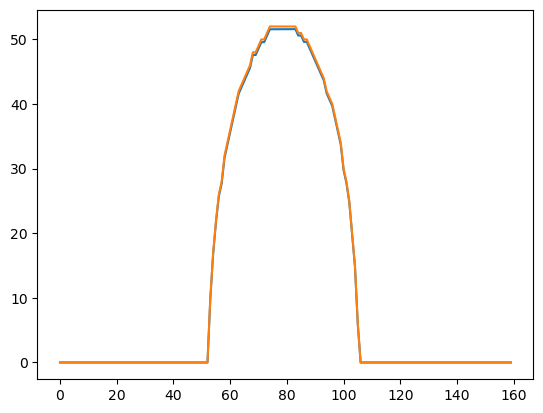

img:  torch.Size([1, 1, 160, 160])ep:  210 485
torch.Size([160])


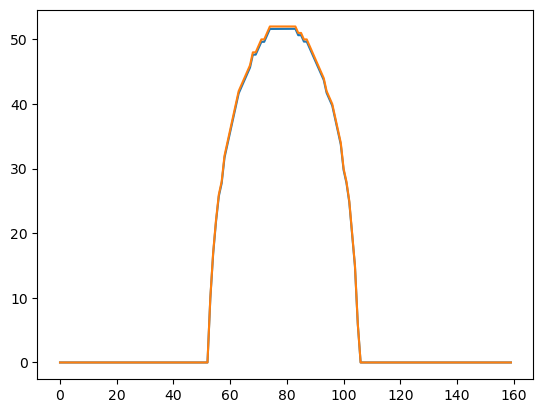

img:  torch.Size([1, 1, 160, 160])ep:  220 485
torch.Size([160])


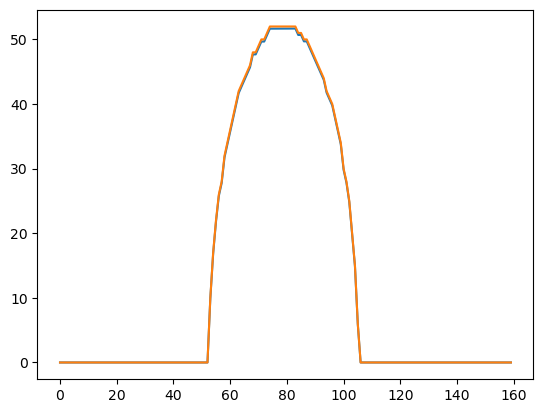

img:  torch.Size([1, 1, 160, 160])ep:  230 485
torch.Size([160])


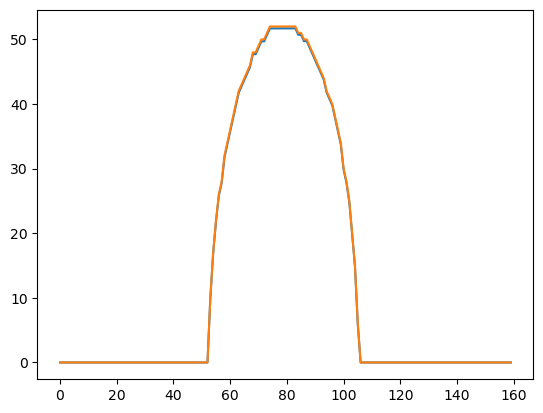

img:  torch.Size([1, 1, 160, 160])ep:  240 485
torch.Size([160])


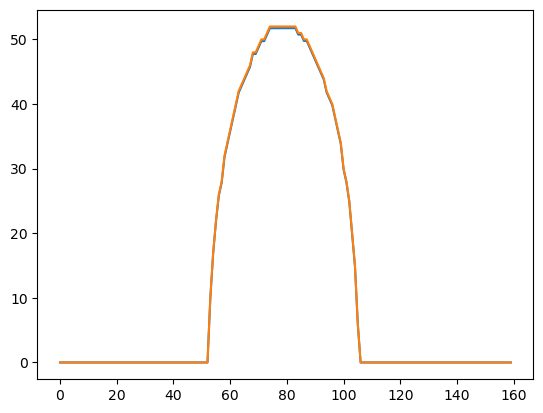

img:  torch.Size([1, 1, 160, 160])ep:  250 485
torch.Size([160])


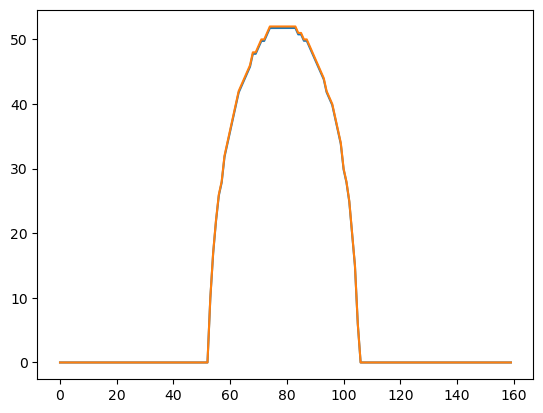

img:  torch.Size([1, 1, 160, 160])ep:  260 485
torch.Size([160])


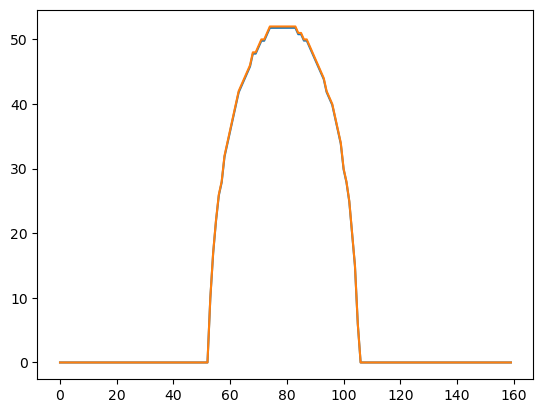

img:  torch.Size([1, 1, 160, 160])ep:  270 485
torch.Size([160])


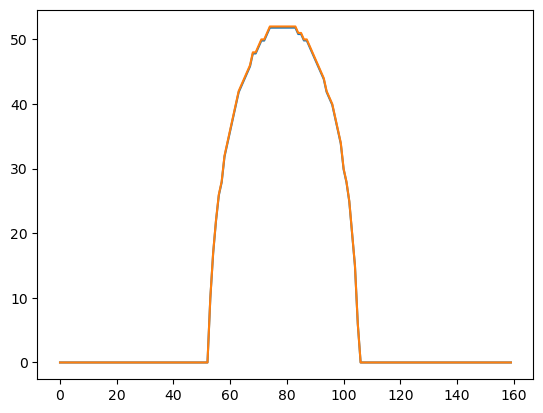

img:  torch.Size([1, 1, 160, 160])ep:  280 485
torch.Size([160])


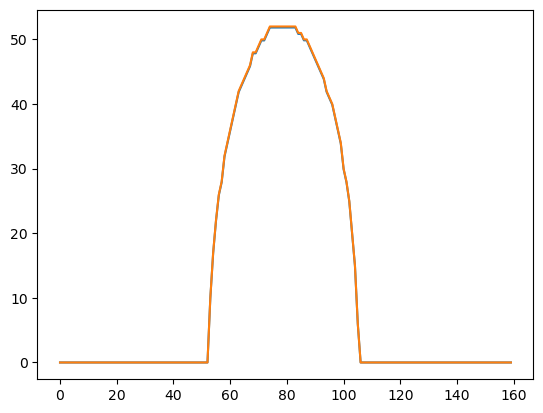

img:  torch.Size([1, 1, 160, 160])ep:  290 485
torch.Size([160])


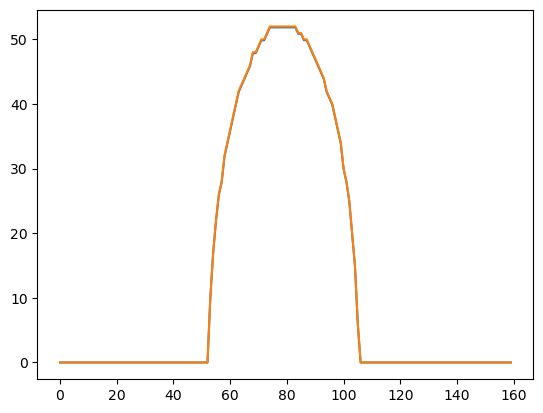

img:  torch.Size([1, 1, 160, 160])ep:  300 485
torch.Size([160])


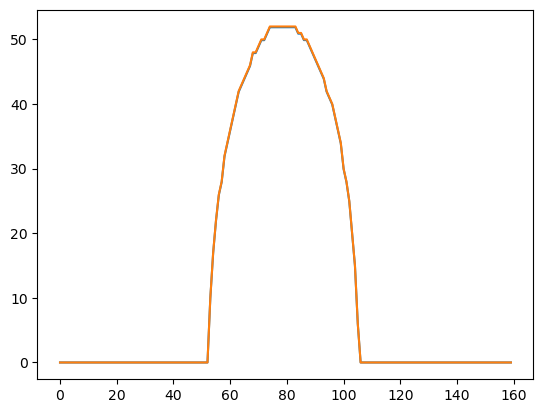

img:  torch.Size([1, 1, 160, 160])ep:  310 485
torch.Size([160])


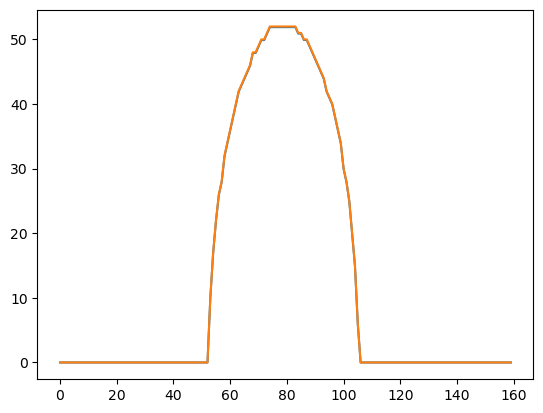

img:  torch.Size([1, 1, 160, 160])ep:  320 485
torch.Size([160])


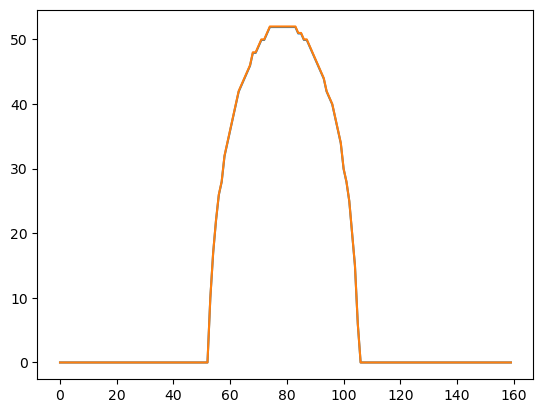

img:  torch.Size([1, 1, 160, 160])ep:  330 485
torch.Size([160])


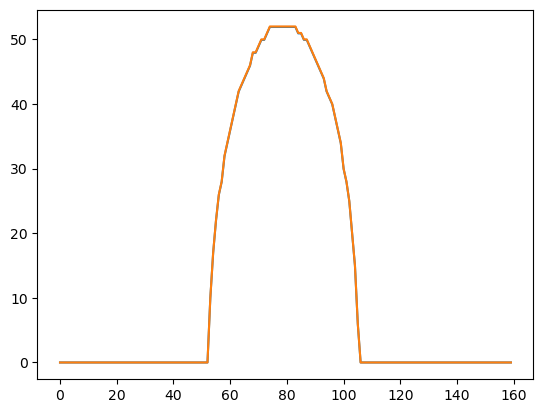

img:  torch.Size([1, 1, 160, 160])ep:  340 485
torch.Size([160])


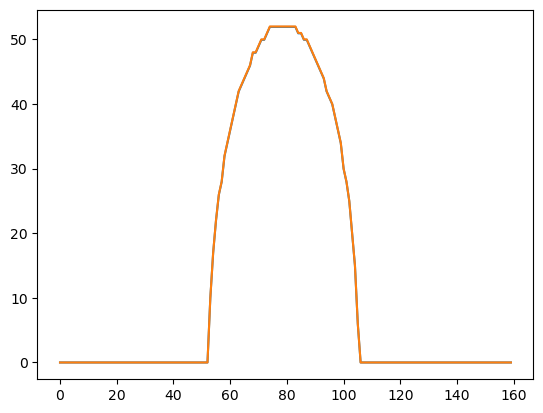

img:  torch.Size([1, 1, 160, 160])ep:  350 485
torch.Size([160])


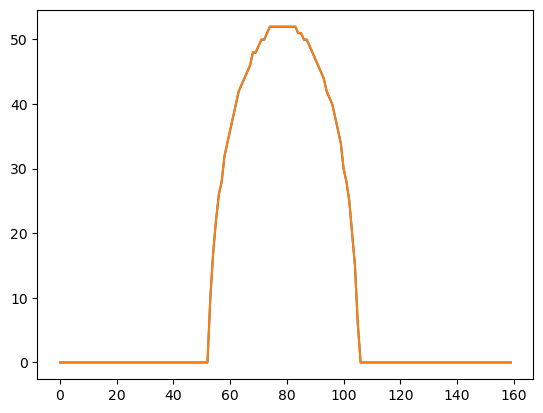

img:  torch.Size([1, 1, 160, 160])ep:  360 485
torch.Size([160])


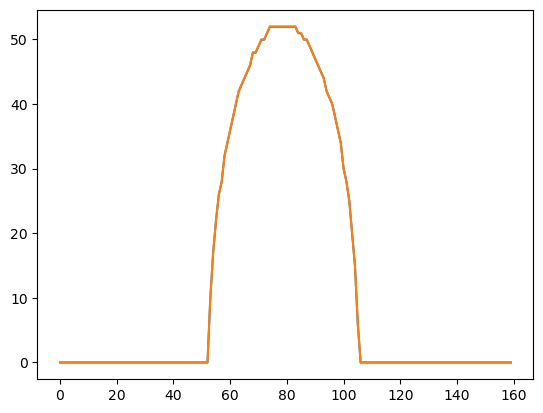

img:  torch.Size([1, 1, 160, 160])ep:  370 485
torch.Size([160])


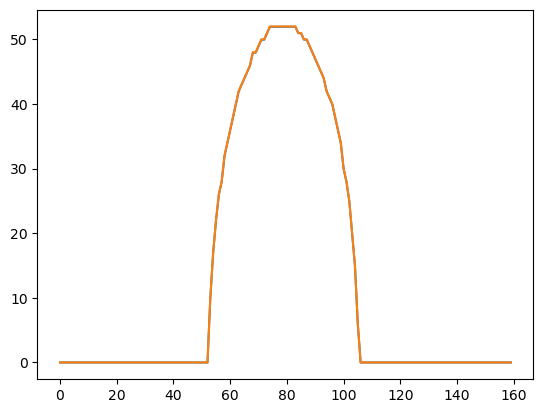

img:  torch.Size([1, 1, 160, 160])ep:  380 485
torch.Size([160])


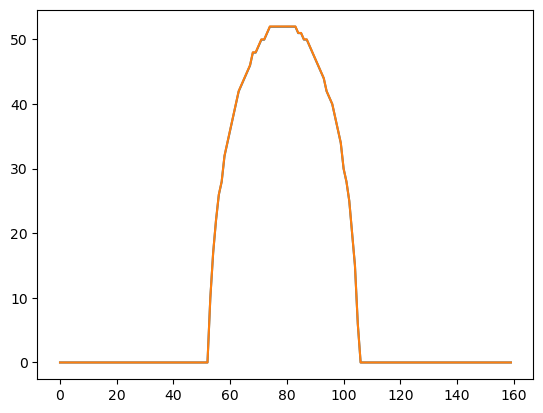

img:  torch.Size([1, 1, 160, 160])ep:  390 485
torch.Size([160])


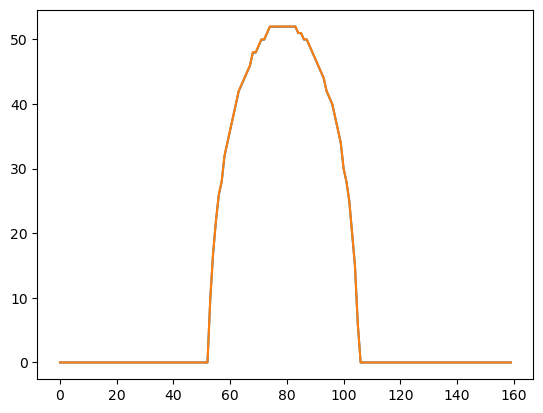

img:  torch.Size([1, 1, 160, 160])ep:  400 485
torch.Size([160])


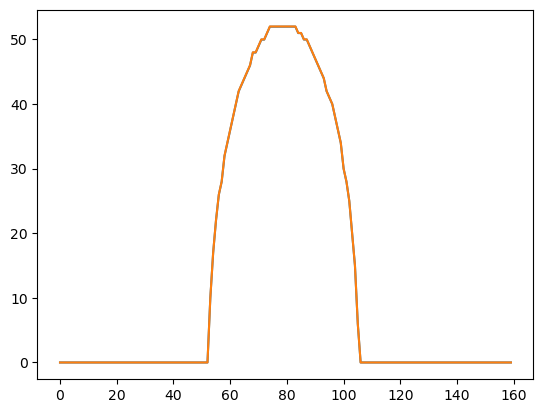

img:  torch.Size([1, 1, 160, 160])ep:  410 485
torch.Size([160])


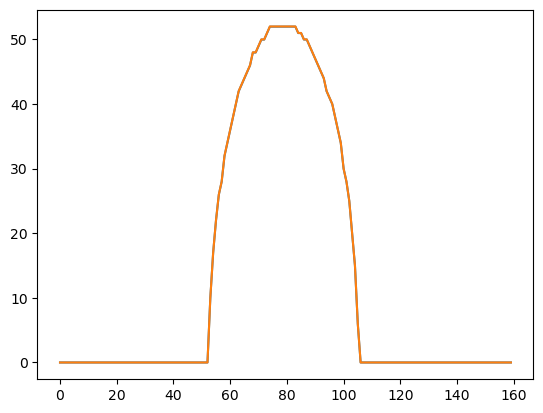

img:  torch.Size([1, 1, 160, 160])ep:  420 485
torch.Size([160])


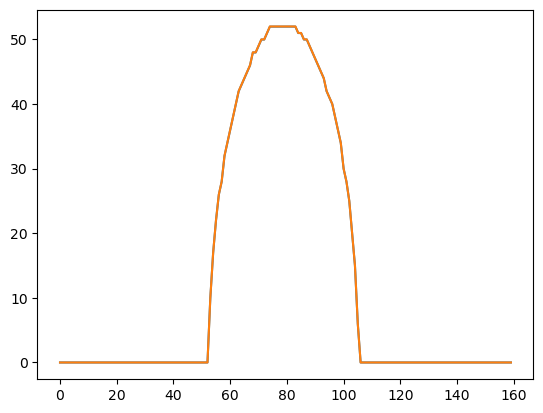

img:  torch.Size([1, 1, 160, 160])ep:  430 485
torch.Size([160])


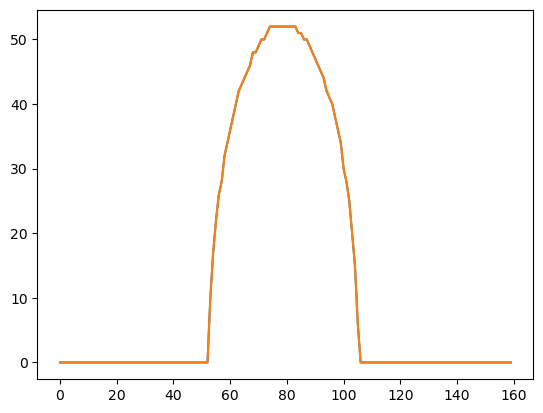

img:  torch.Size([1, 1, 160, 160])ep:  440 485
torch.Size([160])


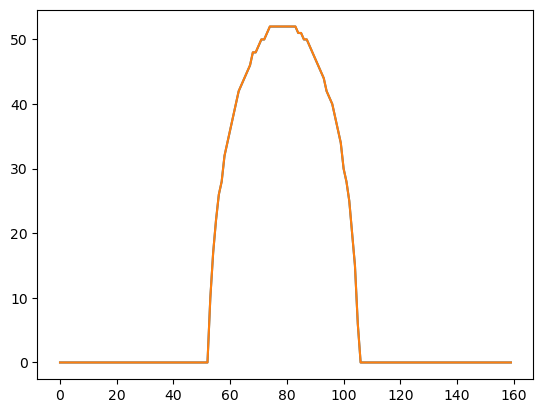

img:  torch.Size([1, 1, 160, 160])ep:  450 485
torch.Size([160])


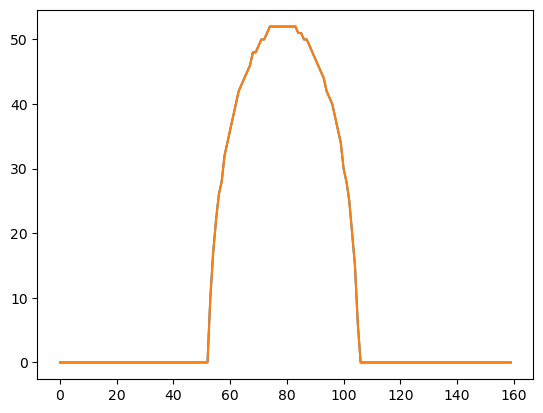

img:  torch.Size([1, 1, 160, 160])ep:  460 485
torch.Size([160])


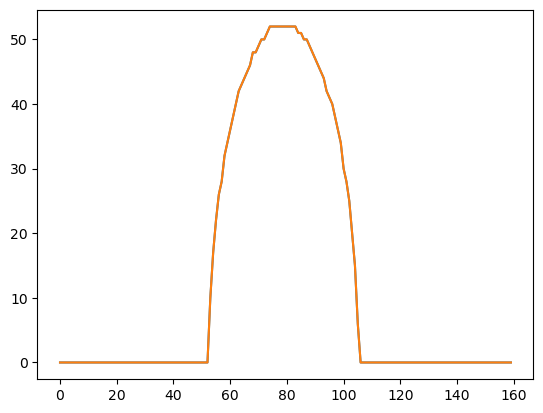

img:  torch.Size([1, 1, 160, 160])ep:  470 485
torch.Size([160])


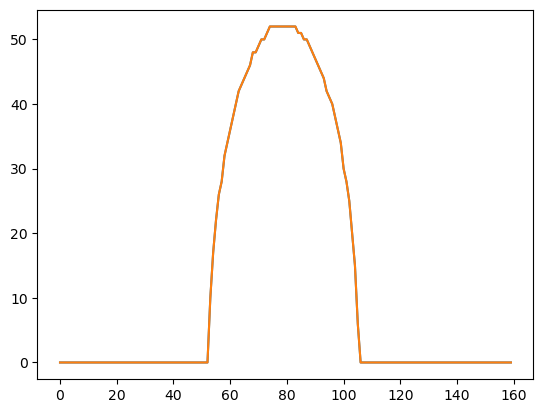

img:  torch.Size([1, 1, 160, 160])ep:  480 485
torch.Size([160])


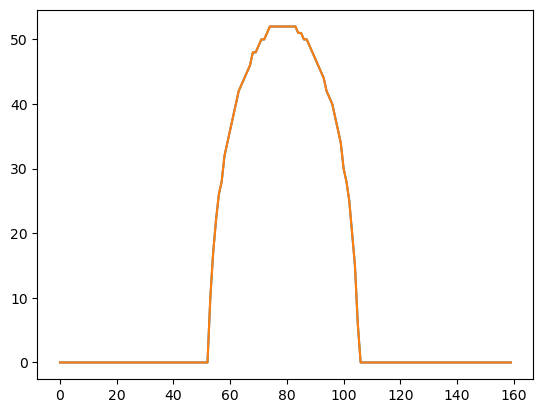

illusory_brigntness_reverse 	em step:  484 485
Processing:  rectangle_Brightness-Optical-Illusion2
Making grayscale:  torch.Size([1, 3, 160, 160])
torch.Size([1, 1, 160, 160])
Opening image ./optical_illusions/rectangle_Brightness-Optical-Illusion2.png with test strip file ./optical_illusions/test_strips/rectangle_Brightness-Optical-Illusion2_teststrip_part_a.png
Could not find ./optical_illusions/test_strips/rectangle_Brightness-Optical-Illusion2_teststrip_part_b.png, making zeros.
Test strip stats:  tensor(0.0875, dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(1., dtype=torch.float32)
Test strip stats:  tensor(0., dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(0., dtype=torch.float32)
img:  torch.Size([1, 1, 160, 160])ion2 	em step:  0 485
torch.Size([160])


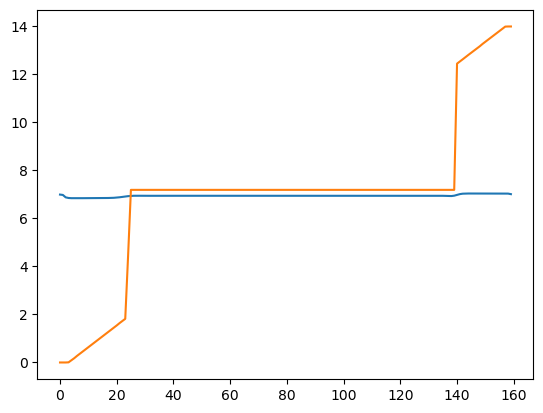

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  10 485
torch.Size([160])


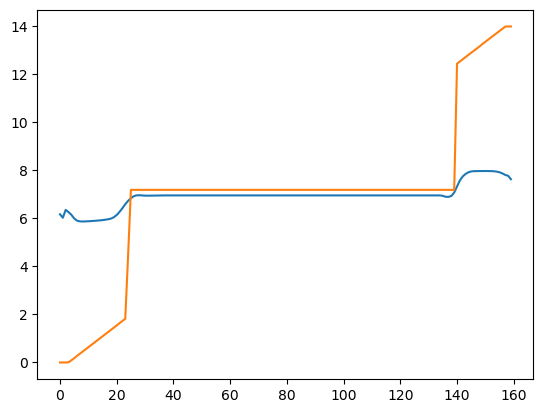

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  20 485
torch.Size([160])


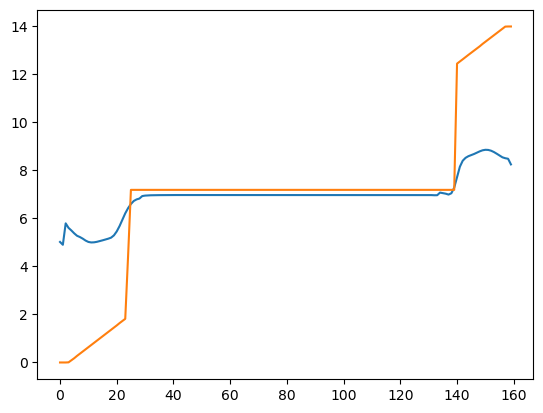

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  30 485
torch.Size([160])


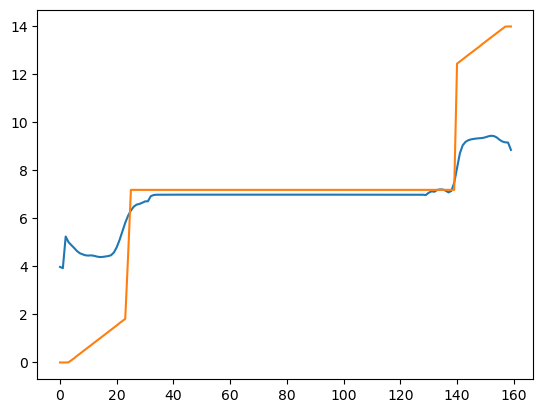

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  40 485
torch.Size([160])


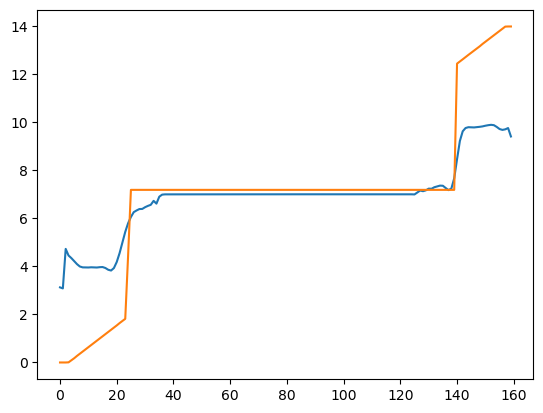

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  50 485
torch.Size([160])


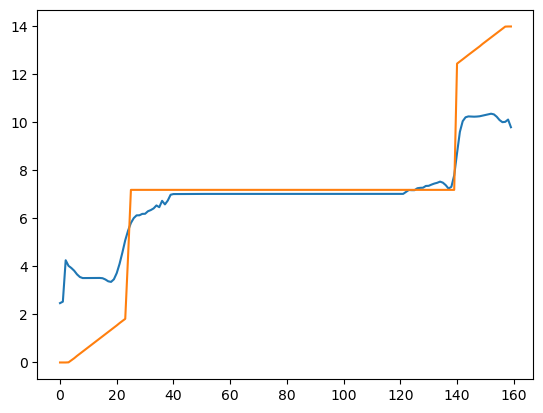

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  60 485
torch.Size([160])


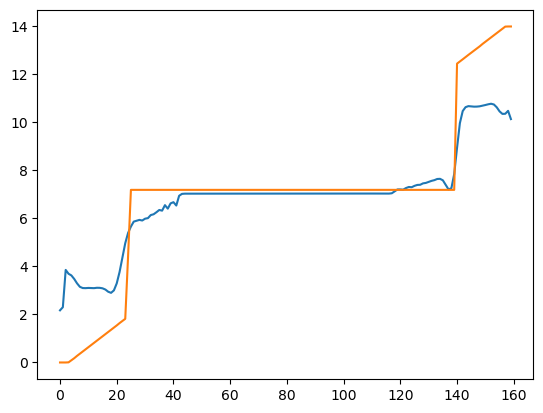

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  70 485
torch.Size([160])


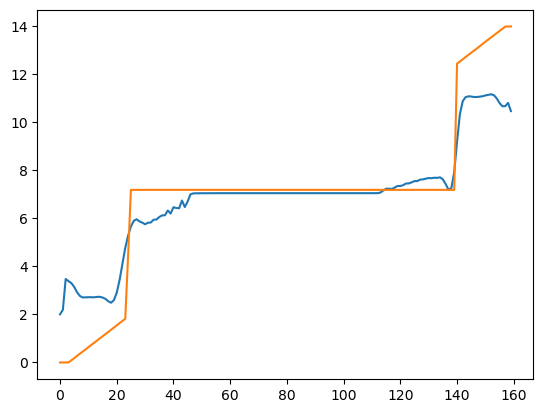

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  80 485
torch.Size([160])


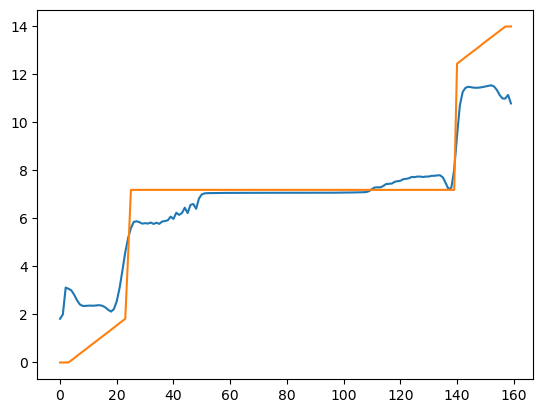

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  90 485
torch.Size([160])


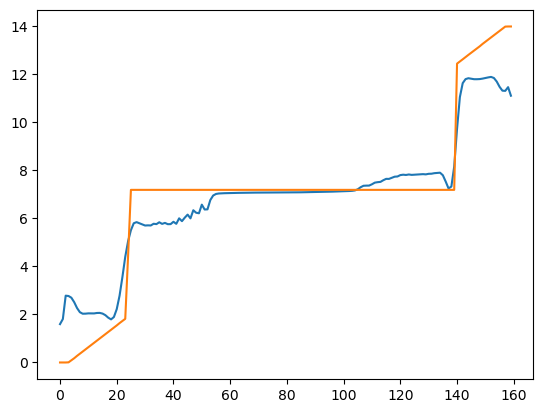

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  100 485
torch.Size([160])


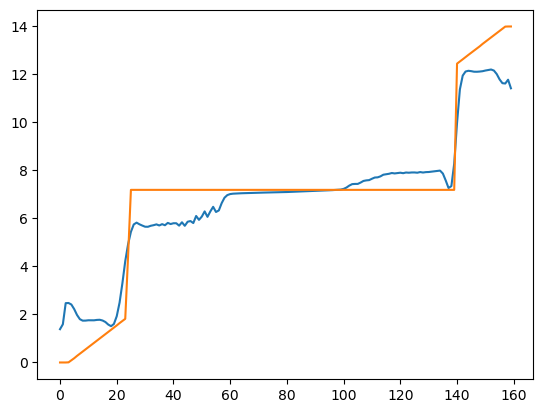

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  110 485
torch.Size([160])


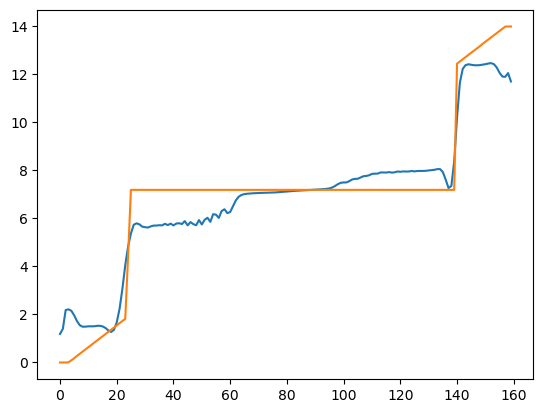

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  120 485
torch.Size([160])


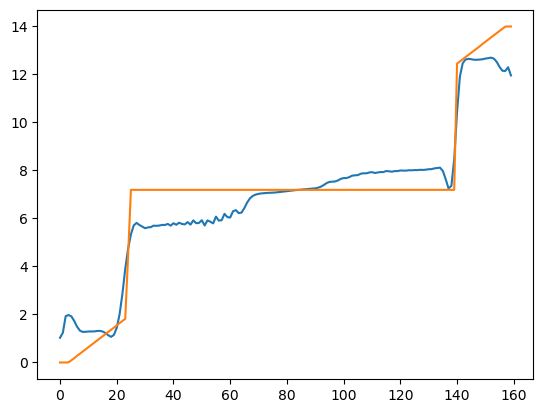

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  130 485
torch.Size([160])


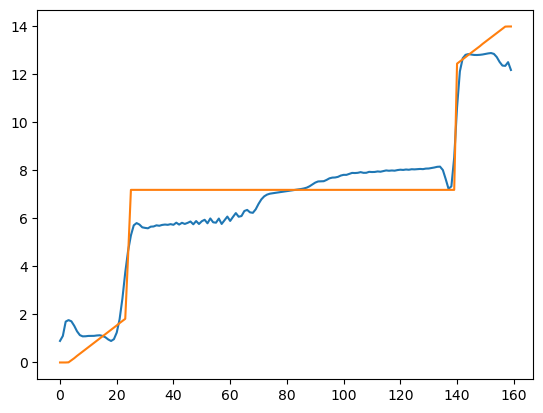

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  140 485
torch.Size([160])


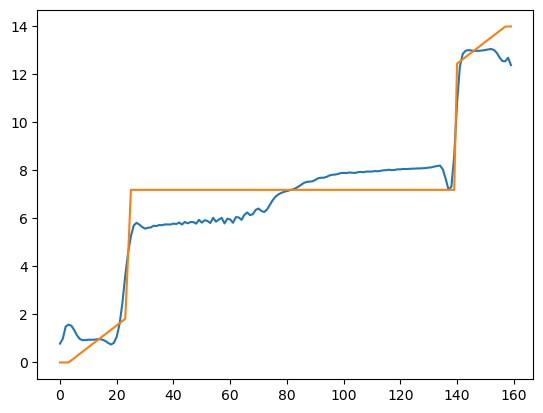

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  150 485
torch.Size([160])


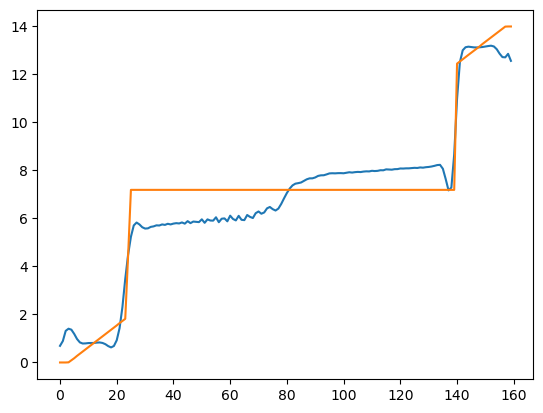

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  160 485
torch.Size([160])


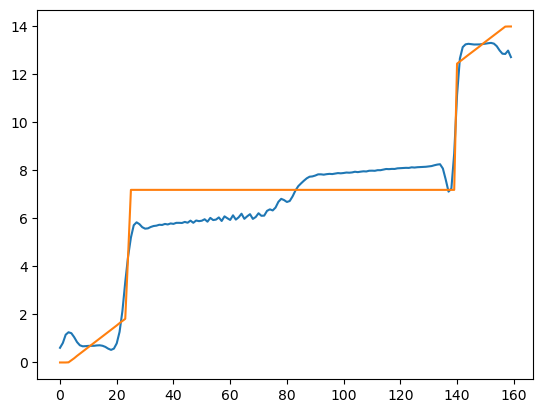

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  170 485
torch.Size([160])


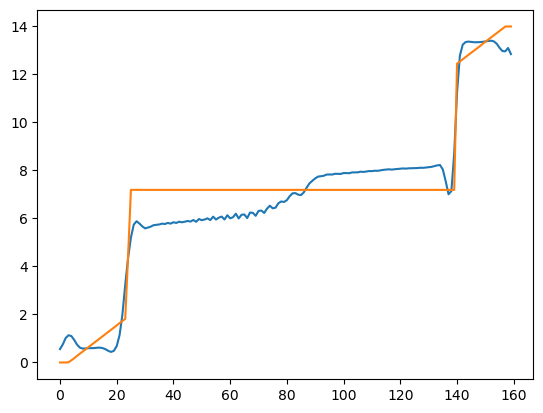

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  180 485
torch.Size([160])


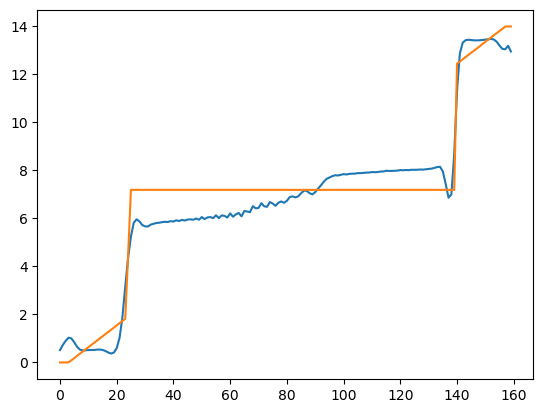

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  190 485
torch.Size([160])


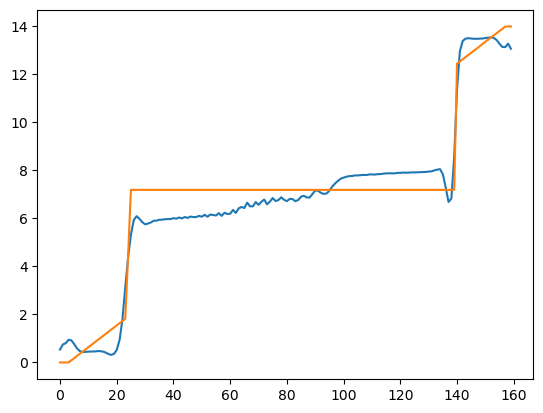

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  200 485
torch.Size([160])


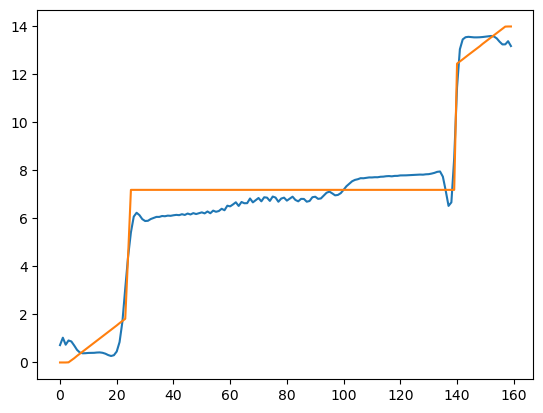

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  210 485
torch.Size([160])


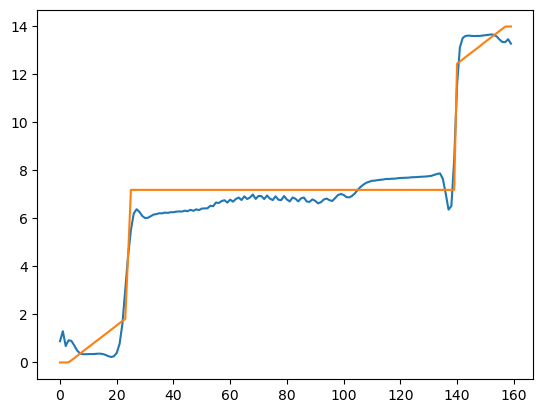

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  220 485
torch.Size([160])


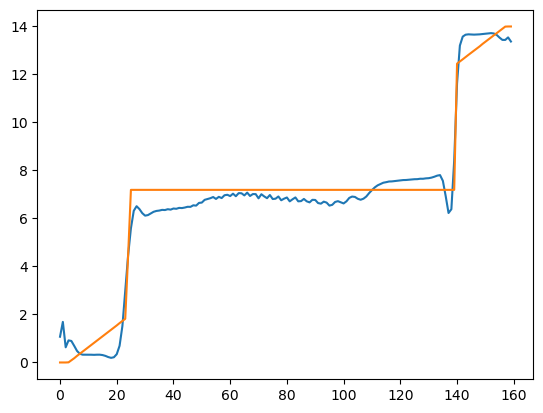

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  230 485
torch.Size([160])


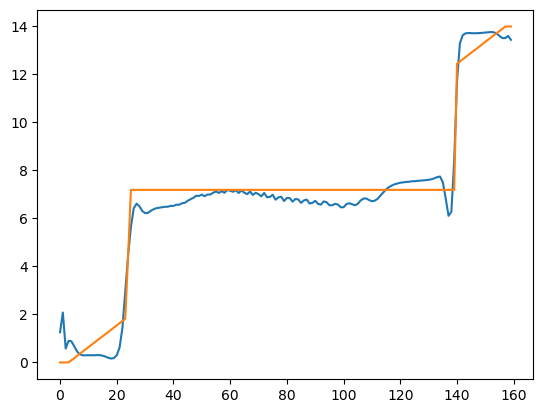

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  240 485
torch.Size([160])


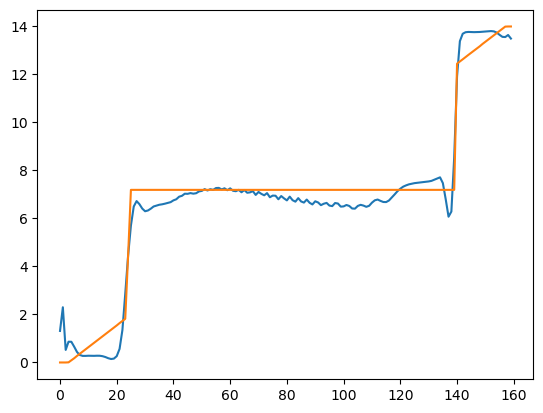

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  250 485
torch.Size([160])


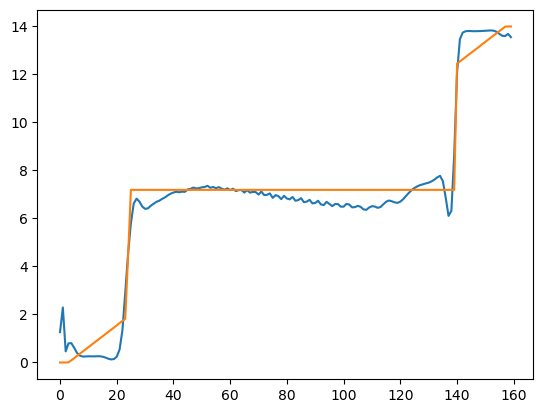

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  260 485
torch.Size([160])


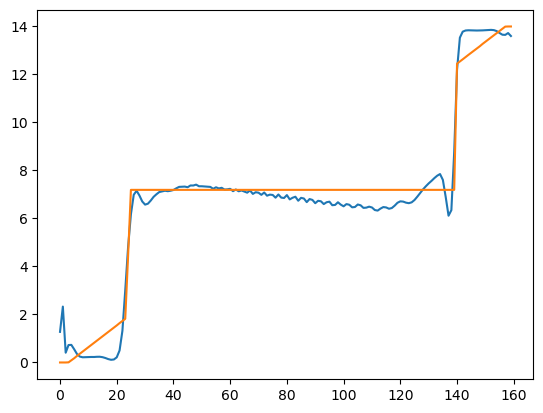

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  270 485
torch.Size([160])


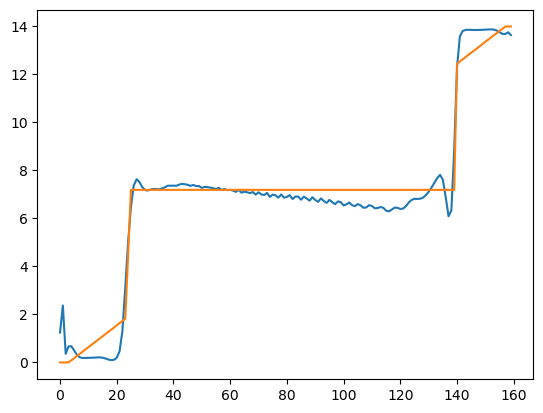

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  280 485
torch.Size([160])


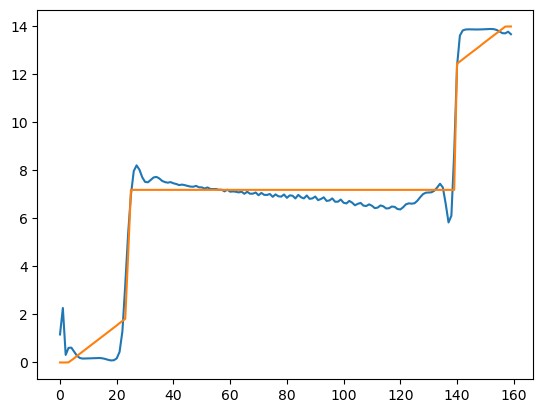

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  290 485
torch.Size([160])


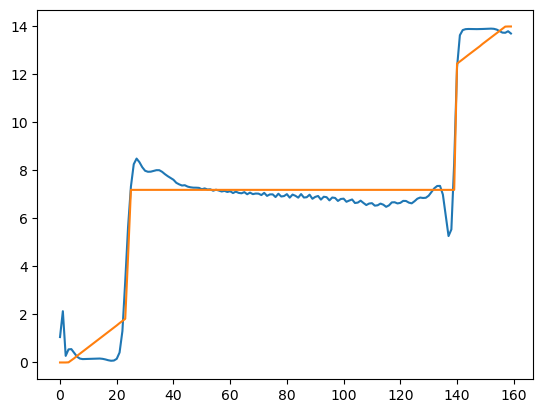

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  300 485
torch.Size([160])


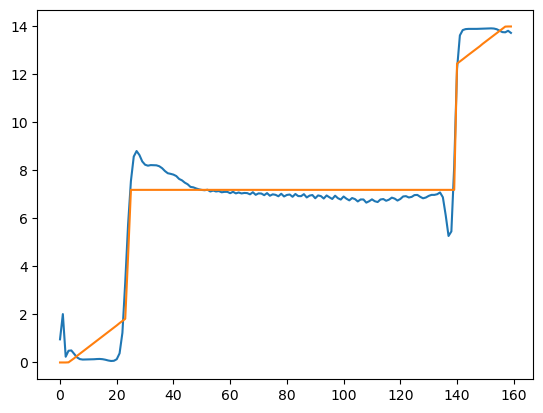

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  310 485
torch.Size([160])


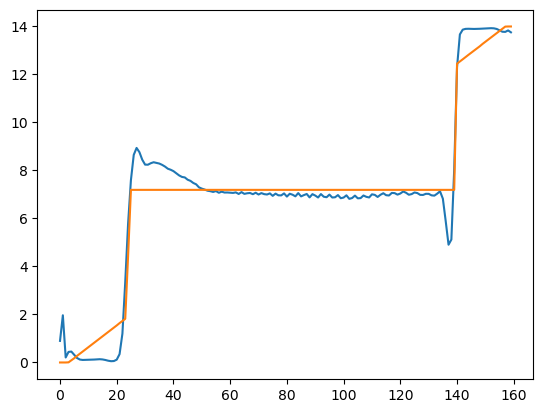

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  320 485
torch.Size([160])


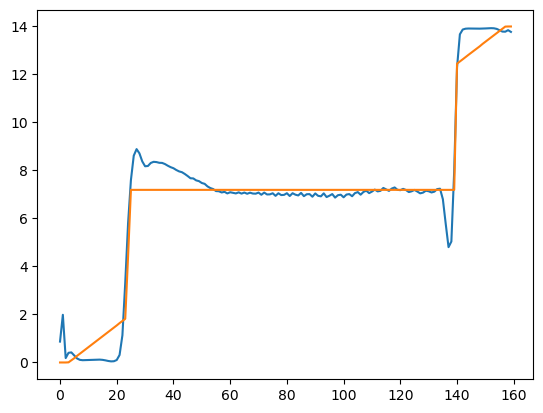

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  330 485
torch.Size([160])


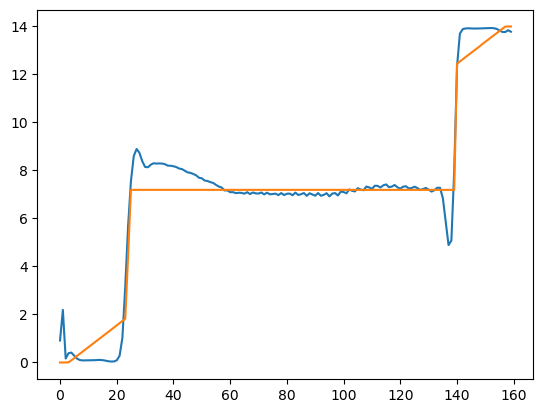

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  340 485
torch.Size([160])


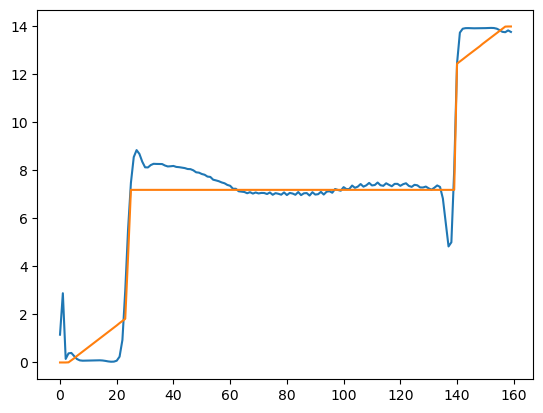

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  350 485
torch.Size([160])


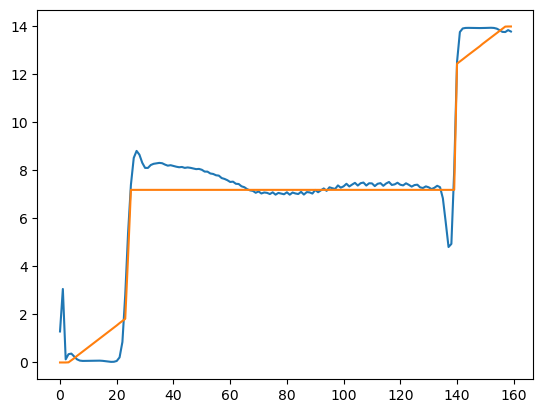

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  360 485
torch.Size([160])


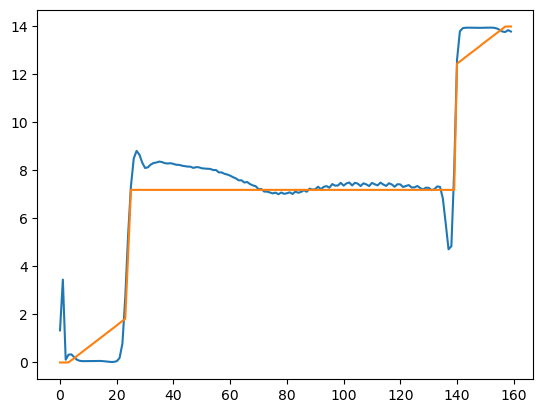

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  370 485
torch.Size([160])


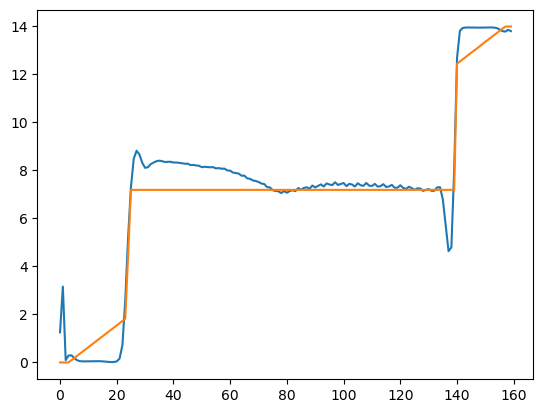

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  380 485
torch.Size([160])


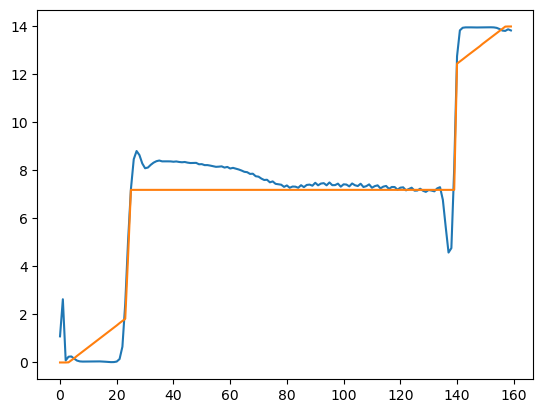

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  390 485
torch.Size([160])


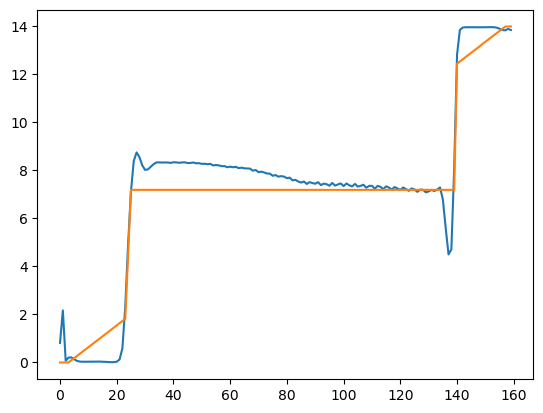

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  400 485
torch.Size([160])


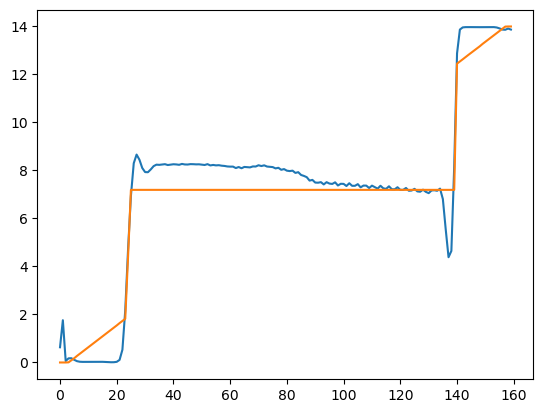

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  410 485
torch.Size([160])


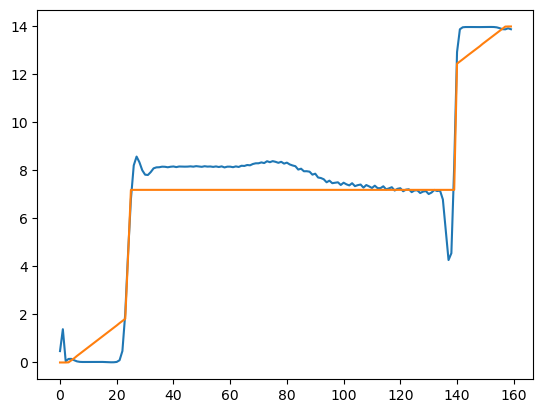

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  420 485
torch.Size([160])


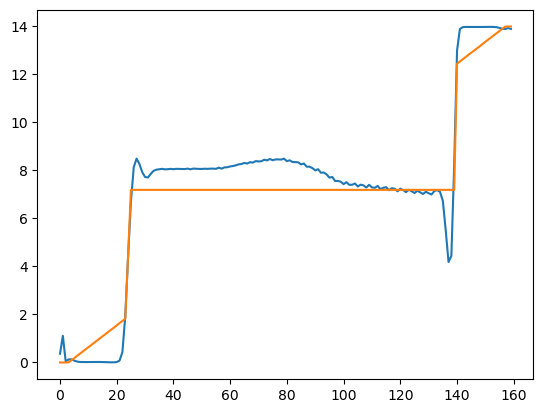

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  430 485
torch.Size([160])


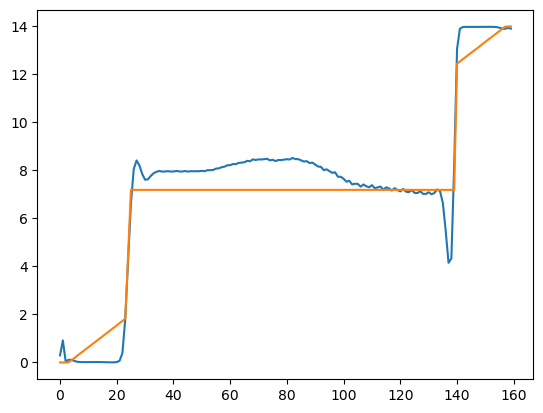

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  440 485
torch.Size([160])


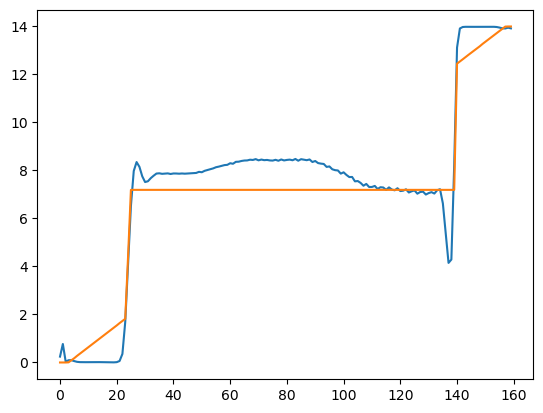

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  450 485
torch.Size([160])


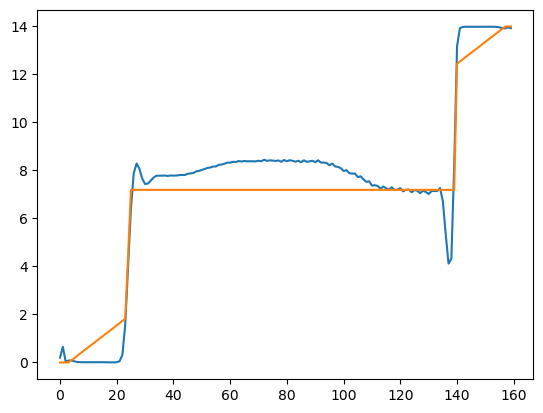

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  460 485
torch.Size([160])


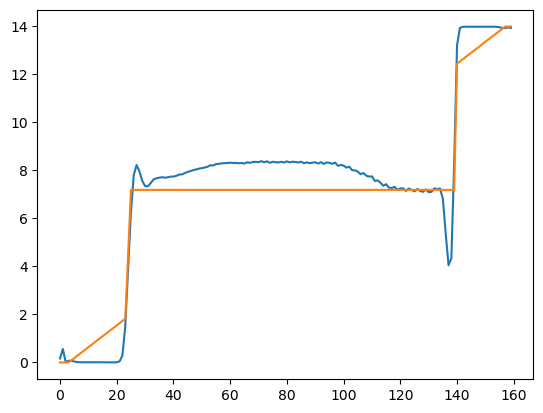

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  470 485
torch.Size([160])


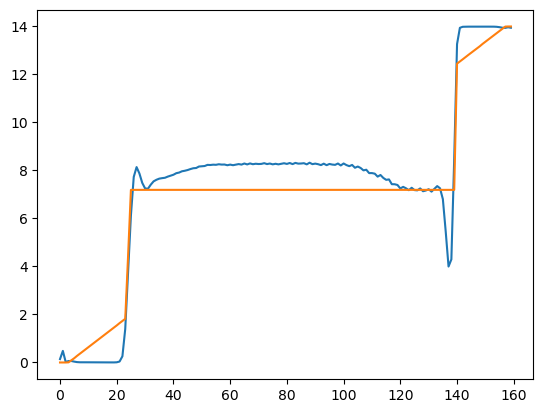

img:  torch.Size([1, 1, 160, 160])ion2 	em step:  480 485
torch.Size([160])


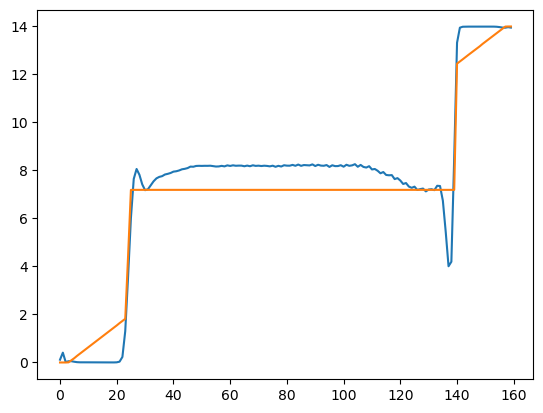

rectangle_Brightness-Optical-Illusion2 	em step:  484 485


In [67]:
loss_list = []
E_energy_jump_list = []
H_energy_jump_list = []
energy_loss = 0
last_energy_E = 0
last_energy_H = 0 
# Get sample from training data
em_step_loss_weight_dist = softmax(loss_step_weights)
argmax_step = torch.argmax(torch.squeeze(loss_step_weights))

# Only process one image if this is set
if(args.target_img):
    img_paths = [args.target_img]

for img_file in img_paths:
    # Reset the grid
    grid.reset()
    # Load an image
    img_name = img_file.split('/')[-1].split('.')[0]
    print('Processing: ', img_name)
    img = Image.open(img_file)
    img = image_transform(img)[None, ...]
    if(args.grayscale):
        print('Making grayscale: ', img.shape)
        img = torchvision.transforms.Grayscale()(img)[None, 0, ...]
        print(img.shape)
        #break
    else:
        print('NOT making grayscale: ', img.shape)
        img = torchvision.transforms.Grayscale()(img)
        print(img.shape)
        #break
    
    # Get the path of the test strip
    illusion_path, illusion_filename = img_file.rsplit('/', 1)
    test_strip_pref = illusion_path + '/test_strips/' + illusion_filename.split('.')[0]
    test_strip_file_a = test_strip_pref + '_teststrip_part_a.png'
    test_strip_file_b = test_strip_pref + '_teststrip_part_b.png'
    print('Opening image {0} with test strip file {1}'.format(img_file, test_strip_file_a))
    
    try:
        test_strip_img_a = np.array(Image.open(test_strip_file_a))
    except:
        print('Could not find {0}, skipping'.format(test_strip_file_a))
        continue
    try:
        test_strip_img_b = np.array(Image.open(test_strip_file_b))
    except:
        print('Could not find {0}, making zeros.'.format(test_strip_file_b))
        test_strip_img_b = np.zeros_like(test_strip_img_a)
    # Make sure it is binary.
    assert np.sum(((test_strip_img_a > 0) * (test_strip_img_a < 1)).astype(np.int)) <= 0
    assert np.sum(((test_strip_img_b > 0) * (test_strip_img_b < 1)).astype(np.int)) <= 0
    test_strip_img_a = image_transform(test_strip_img_a)[None, ...]
    test_strip_img_b = image_transform(test_strip_img_b)[None, ...]
    # Re-binarize after the resize.
    test_strip_img_a = (test_strip_img_a > 0.5).float()
    test_strip_img_b = (test_strip_img_b > 0.5).float()
    print('Test strip stats: ', torch.mean(test_strip_img_a), torch.min(test_strip_img_a), torch.max(test_strip_img_a))
    print('Test strip stats: ', torch.mean(test_strip_img_b), torch.min(test_strip_img_b), torch.max(test_strip_img_b))

    for em_step, (img_hat_em, em_field) in enumerate(model(img, summary_writer=None, train_step=0)):
        print(img_name, '\tem step: ', em_step, em_steps, end='\r')
        
        # Save the em field and energy at the target step.
        e_field_img = em_field[0:3,...]
        h_field_img = em_field[3:6,...]
        
        #if(em_step == argmax_step):
        if(em_step % 10 == 0):
            masked_output_a = test_strip_img_a * torch.unsqueeze(img_hat_em, 0)
            masked_output_b = test_strip_img_b * torch.unsqueeze(img_hat_em, 0)
            masked_output_a = torch.squeeze(masked_output_a)
            masked_output_b = torch.squeeze(masked_output_b)
            masked_output_a = torch.sum(masked_output_a, axis=-2)
            masked_output_b = torch.sum(masked_output_b, axis=-2)
            # Sum the input image over the y dimension.
            print('img: ', img.shape)
            input_img_masked_sum = test_strip_img_a * img
            input_img_masked_sum = torch.squeeze(input_img_masked_sum)
            input_img_masked_sum = torch.sum(input_img_masked_sum, axis=-2)
            plt.plot(masked_output_a.detach().numpy())
            plt.plot(input_img_masked_sum.detach().numpy())
            print(input_img_masked_sum.shape)
            plt.show()
        # Add the argmaxxed images to tensorboard
        if(args.grayscale):
            img_save =  img.expand(-1, 3, -1, -1)
            #img_hat_em_save =  img_hat_em_save.expand(3, -1, -1)
            img_hat_em_save =  img_hat_em.expand(3, -1, -1)
        img_grid = torchvision.utils.make_grid([img_save[0,...], img_hat_em_save,
            util.norm_img_by_chan(e_field_img), 
            util.norm_img_by_chan(h_field_img)])
        #save_image(img_grid, './images/{0}_step_{1}.png'.format(img_name, str(em_step).zfill(12)))
    print('')
